<a href="https://colab.research.google.com/github/beyzoskaya/CS-566-Deep-Learning/blob/main/assignment_4_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Generative Adversarial Network(GAN) using Keras
In this assignment you will use GAN, a network of Generator and Discriminator, to generate images for digits using MNIST datasets.

GAN is an unsupervised deep learning algorithm where we have a Generator pitted against an adversarial network called Discriminator. Generator’s objective will be to generate data that is very similar to the training data. Data generated from Generator should be indistinguishable from the real data. Discriminator takes two sets of input, one input comes from the training dataset(real data) and the other input is the dataset generated by Generator.

GAN will use the MNIST data and identify the latent feature representation for generating digits. At the end you will see how the Generators are able to generate real-looking MNIST digits.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)


physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

Loading the data from mnist dataset. we create a function load_data() function

In [167]:
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5

    # convert shape of x_train from (60000, 28, 28) to (60000, 784)
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

(X_train, y_train,X_test, y_test)=load_data()
print(X_train.shape)

(60000, 784)


In [3]:
def adam_optimizer():
    return Adam(learning_rate=0.0002, beta_1=0.5)

We create Generator which uses MLP using simple dense layers activated by tanh

In [4]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(units=784, activation='tanh'))

    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator

g=create_generator()
g.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │          25,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 784)                 │         803,600 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,486,352 (5.67 MB)

 Trainable params: 1,486,352 (5.67 MB)

 Non-trainable params: 0 (0.00 B)

We now create the Discriminator which is also MLP. Discriminator will take the input from real data which is of the size 784 and also the images generated from Generator.

In [5]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))


    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(units=1, activation='sigmoid'))

    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator

d =create_discriminator()
d.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 1024)                │         803,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,460,225 (5.57 MB)

 Trainable params: 1,460,225 (5.57 MB)

 Non-trainable params: 0 (0.00 B)

We can now create the GAN where we combine the Generator and Discriminator. When we train the generator we will freeze the Discriminator.

We will input the noise image of size 100 to the Generator. The output generated from the Generator will be fed to the Discriminator.

In [7]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

gan = create_gan(d,g)
gan.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 784)                 │       1,486,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_17 (Cast)                       │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 1)                   │       1,460,225 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,946,577 (11.24 MB)

 Trainable params: 1,486,352 (5.67 MB)

 Non-trainable params: 1,460,225 (5.57 MB)

Before we start training the model, we will write a function plot_generated_images to plot the generated images. This way we can see how the images are generated. We save the generated images to file that we can view later

In [8]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise = tf.random.normal([examples, 100], dtype=tf.float16)
    generated_images = generator.predict(noise)
    generated_images = tf.cast(generated_images, tf.float32)
    generated_images = generated_images.numpy().reshape(100, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Generated images after epoch {epoch}', y=0.995)
    plt.tight_layout()
    plt.show()
    plt.savefig(f'gan_generated_image_{epoch}.png')
    plt.close()

We finally start to train GAN:

In [ ]:
class GAN:
    def __init__(self):
        # Initialize models
        self.generator = create_generator()
        self.discriminator = create_discriminator()

        # Initialize optimizers with mixed precision
        self.g_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        self.d_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

        # Loss function
        self.loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    @tf.function(reduce_retracing=True)
    def train_discriminator(self, real_images, batch_size):
        real_images = tf.cast(real_images, tf.float16)
        noise = tf.random.normal([batch_size, 100], dtype=tf.float16)

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Get predictions
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            # Create labels
            real_labels = tf.ones_like(real_output)
            fake_labels = tf.zeros_like(fake_output)

            # Calculate losses
            real_loss = self.loss_fn(real_labels, real_output)
            fake_loss = self.loss_fn(fake_labels, fake_output)
            total_loss = real_loss + fake_loss

        # Calculate gradients
        gradients = tape.gradient(total_loss, self.discriminator.trainable_variables)

        # Apply gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))

        return total_loss

    @tf.function(reduce_retracing=True)
    def train_generator(self, batch_size):
        noise = tf.random.normal([batch_size, 100], dtype=tf.float16)

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Get predictions
            fake_output = self.discriminator(generated_images, training=False)

            # Calculate loss
            labels = tf.ones_like(fake_output)
            loss = self.loss_fn(labels, fake_output)

        # Calculate gradients
        gradients = tape.gradient(loss, self.generator.trainable_variables)

        # Apply gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        return loss



def train(epochs=50, batch_size=128):
    # Load and prepare data
    x_train, _, _, _ = load_data()
    dataset_size = x_train.shape[0]

    # Create dataset with fixed shapes and types
    dataset = tf.data.Dataset.from_tensor_slices(x_train) \
        .shuffle(dataset_size) \
        .batch(batch_size, drop_remainder=True) \
        .prefetch(tf.data.AUTOTUNE)

    # Initialize GAN
    gan = GAN()

    # Training loop
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        for batch_idx, real_images in enumerate(dataset):
            d_loss = gan.train_discriminator(real_images, batch_size)
            g_loss = gan.train_generator(batch_size)

            if batch_idx % 100 == 0:
                print(f"\rBatch {batch_idx}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}", end="")

        # Generate and save images every 10 epochs
        if (epoch + 1) % 10 == 0:
            plot_generated_images(epoch + 1, gan.generator)


Epoch 1/50
Batch 400, D Loss: 0.6812, G Loss: 2.0321
Epoch 2/50
Batch 400, D Loss: 0.8226, G Loss: 1.6050
Epoch 3/50
Batch 400, D Loss: 0.8637, G Loss: 1.4589
Epoch 4/50
Batch 400, D Loss: 0.7824, G Loss: 2.2190
Epoch 5/50
Batch 400, D Loss: 0.8207, G Loss: 1.8708
Epoch 6/50
Batch 400, D Loss: 0.9062, G Loss: 1.7818
Epoch 7/50
Batch 400, D Loss: 1.0365, G Loss: 1.6375
Epoch 8/50
Batch 400, D Loss: 1.0933, G Loss: 1.1205
Epoch 9/50
Batch 400, D Loss: 1.1476, G Loss: 1.2316
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


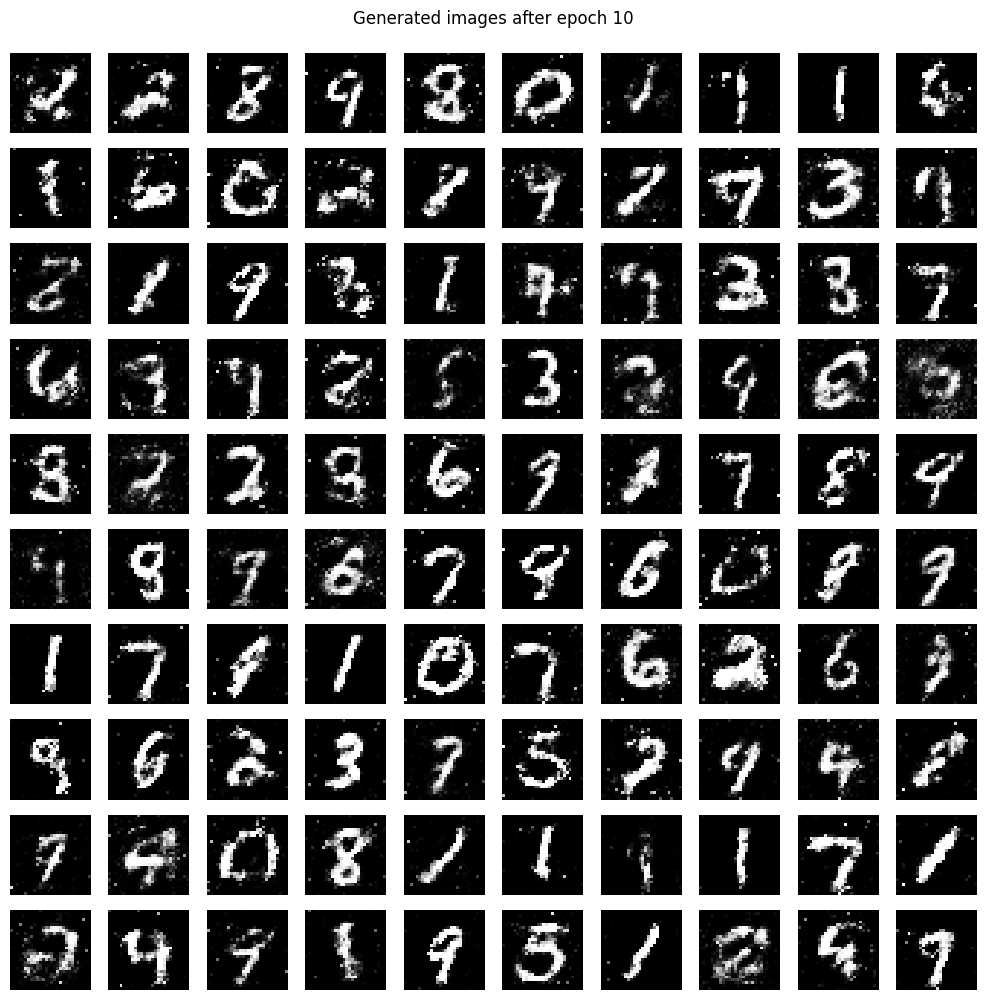


Epoch 11/50
Batch 400, D Loss: 1.0905, G Loss: 1.2065
Epoch 12/50
Batch 400, D Loss: 1.2173, G Loss: 1.3637
Epoch 13/50
Batch 400, D Loss: 1.2061, G Loss: 1.1347
Epoch 14/50
Batch 400, D Loss: 1.1928, G Loss: 1.0190
Epoch 15/50
Batch 400, D Loss: 1.2605, G Loss: 0.9990
Epoch 16/50
Batch 400, D Loss: 1.2443, G Loss: 1.0539
Epoch 17/50
Batch 400, D Loss: 1.2148, G Loss: 1.0225
Epoch 18/50
Batch 400, D Loss: 1.2529, G Loss: 1.0704
Epoch 19/50
Batch 400, D Loss: 1.2782, G Loss: 0.9839
Epoch 20/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


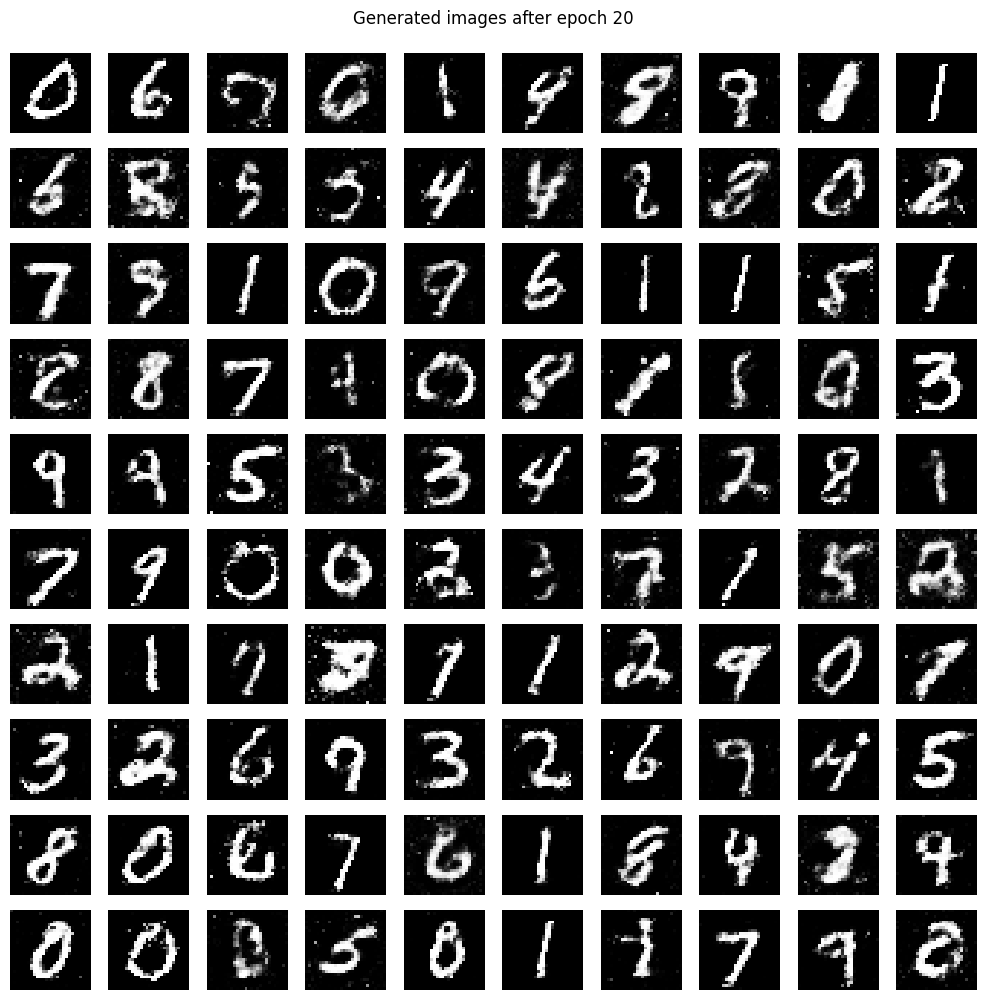


Epoch 21/50
Batch 400, D Loss: 1.2780, G Loss: 0.9663
Epoch 22/50
Batch 400, D Loss: 1.3549, G Loss: 0.9989
Epoch 23/50
Batch 400, D Loss: 1.2122, G Loss: 1.0414
Epoch 24/50
Batch 400, D Loss: 1.3158, G Loss: 1.0292
Epoch 25/50
Batch 400, D Loss: 1.2189, G Loss: 1.0168
Epoch 26/50
Batch 400, D Loss: 1.3652, G Loss: 0.9688
Epoch 27/50
Batch 400, D Loss: 1.3114, G Loss: 0.9615
Epoch 28/50
Batch 400, D Loss: 1.2448, G Loss: 0.9352
Epoch 29/50
Batch 400, D Loss: 1.3154, G Loss: 0.8871
Epoch 30/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


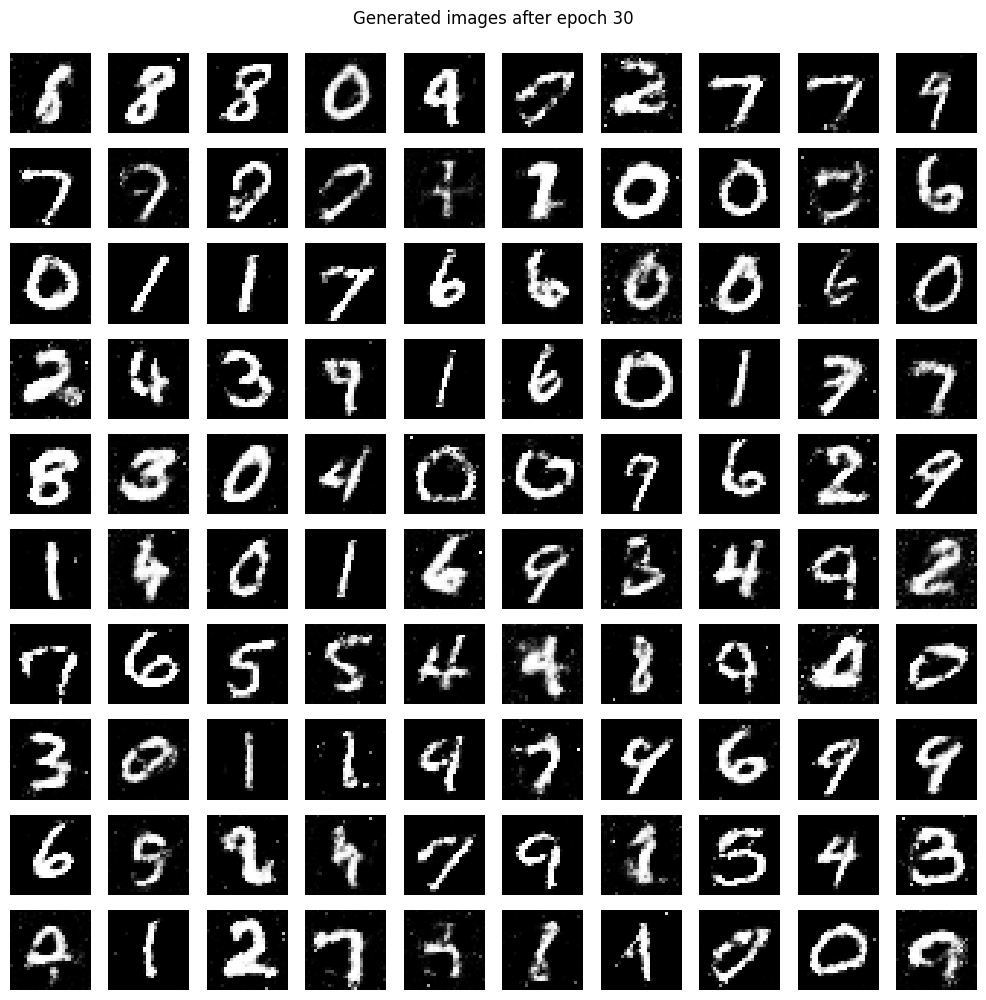


Epoch 31/50
Batch 400, D Loss: 1.3042, G Loss: 0.9155
Epoch 32/50
Batch 400, D Loss: 1.2354, G Loss: 0.9646
Epoch 33/50
Batch 400, D Loss: 1.2990, G Loss: 0.8636
Epoch 34/50
Batch 400, D Loss: 1.2736, G Loss: 0.9842
Epoch 35/50
Batch 400, D Loss: 1.3243, G Loss: 1.1180
Epoch 36/50
Batch 400, D Loss: 1.2877, G Loss: 0.8501
Epoch 37/50
Batch 400, D Loss: 1.3700, G Loss: 0.9213
Epoch 38/50
Batch 400, D Loss: 1.3375, G Loss: 0.9685
Epoch 39/50
Batch 400, D Loss: 1.2847, G Loss: 0.9451
Epoch 40/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


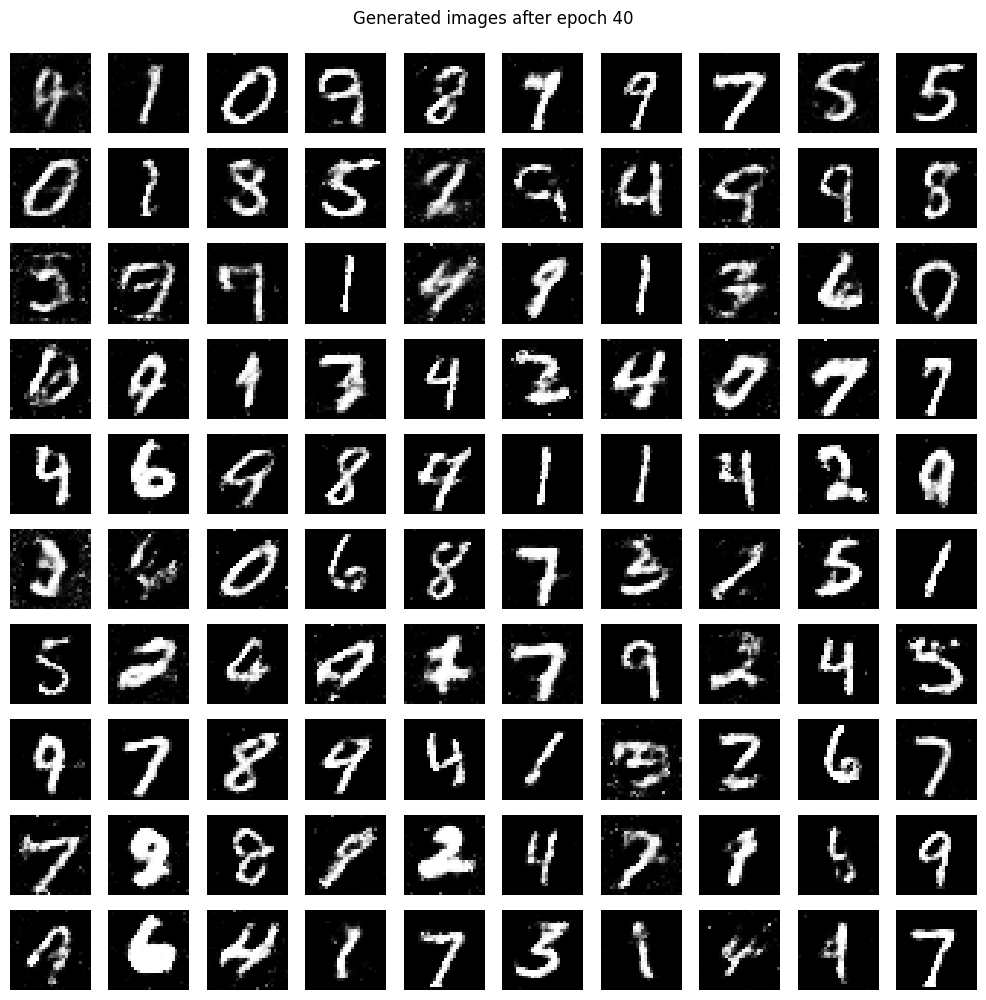


Epoch 41/50
Batch 400, D Loss: 1.2815, G Loss: 1.0298
Epoch 42/50
Batch 400, D Loss: 1.3584, G Loss: 0.9228
Epoch 43/50
Batch 400, D Loss: 1.3147, G Loss: 1.0221
Epoch 44/50
Batch 400, D Loss: 1.3044, G Loss: 0.9139
Epoch 45/50
Batch 400, D Loss: 1.3121, G Loss: 0.9563
Epoch 46/50
Batch 400, D Loss: 1.3098, G Loss: 0.9099
Epoch 47/50
Batch 400, D Loss: 1.3641, G Loss: 0.8866
Epoch 48/50
Batch 400, D Loss: 1.2938, G Loss: 1.0347
Epoch 49/50
Batch 400, D Loss: 1.3690, G Loss: 1.0384
Epoch 50/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


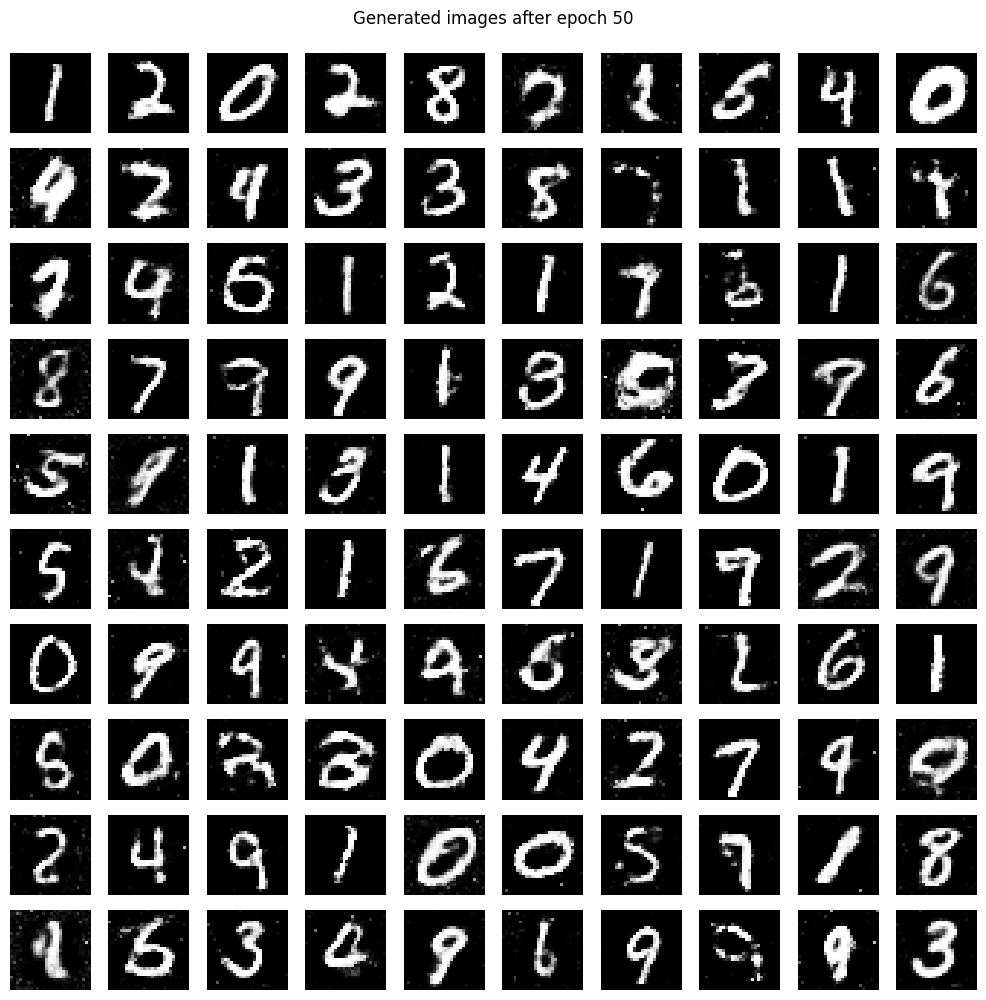

In [ ]:
train(epochs=50, batch_size=128)

## Assignment
### PART-1:

Modify the discriminator based on the following:

1. Use at least 2 convolutional layers in the discriminator.
2. Do not use dense layers, except for the output layer.
2. The input should be 2D image of size 28x28 (You can use Reshape layer of Keras to get correct shaped input from the discriminator).

Re-train your GAN and make sure that you get similar quality output images as the original GAN.

### PART-2:

Now, modify the generator as well, so that the whole GAN becomes a convolutional neural network:

1. Use at least 2 convolutional layers in the generator. You may also like to use batch normalization layers after each convolutional layer. Try using ReLU or Leaky ReLU for activation.
2. Do not use any dense layers.
2. The input should be 2D noise image of size 10x10 (You can use Transposed convolution layer of Keras (Conv2DTranspose) to go from 10x10 sized input to 28x28 sized output).

Re-train your GAN and make sure that you get similar quality output images as the original GAN.

Finally, compare the three GAN networks in terms of complexity (training/testing times and total number of trainable parameters) and quality of generated images of digits. Which approach (convolutional or fully connected network) is preferable?


### PART-1 Modify discriminator

In [168]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, Dropout, Reshape, Flatten, Dense

def create_discriminator_part1():
    discriminator = Sequential()

    # from 784 to 28x28
    discriminator.add(Reshape((28, 28, 1), input_shape=(784,)))

    discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(28, 28, 1)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Conv2D(256, kernel_size=3, strides=2, padding='same'))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))

    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer(), metrics=['accuracy'])
    return discriminator


In [169]:
def adam_optimizer():
    return Adam(learning_rate=0.0005, beta_1=0.5)

In [172]:
class GAN:
    def __init__(self):
        # Initialize models
        self.generator = create_generator()
        self.discriminator = create_discriminator_part1()

        learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.0002,
        decay_steps=10000,
        decay_rate=0.9,
        staircase=True)

        # Initialize optimizers with mixed precision
        self.g_optimizer = Adam(learning_rate=learning_rate, beta_1=0.5)
        self.d_optimizer = Adam(learning_rate=learning_rate, beta_1=0.5)

        # Loss function
        self.loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    @tf.function(reduce_retracing=True)
    def train_discriminator(self, real_images, batch_size):
        real_images = tf.cast(real_images, tf.float16)
        noise = tf.random.normal([batch_size, 100], dtype=tf.float16)

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Get predictions
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            # Create labels
            real_labels = tf.ones_like(real_output)*0.9
            fake_labels = tf.zeros_like(fake_output)

            # Calculate losses
            real_loss = self.loss_fn(real_labels, real_output)
            fake_loss = self.loss_fn(fake_labels, fake_output)
            total_loss = real_loss + fake_loss

        # Calculate gradients
        gradients = tape.gradient(total_loss, self.discriminator.trainable_variables)

        # Apply gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))

        return total_loss

    @tf.function(reduce_retracing=True)
    def train_generator(self, batch_size):
        noise = tf.random.normal([batch_size, 100], dtype=tf.float16)

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Get predictions
            fake_output = self.discriminator(generated_images, training=False)

            # Calculate loss
            labels = tf.ones_like(fake_output)
            loss = self.loss_fn(labels, fake_output)

        # Calculate gradients
        gradients = tape.gradient(loss, self.generator.trainable_variables)

        # Apply gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        return loss



def train(epochs=50, batch_size=128):
    # Load and prepare data
    x_train, _, _, _ = load_data()
    dataset_size = x_train.shape[0]

    # Create dataset with fixed shapes and types
    dataset = tf.data.Dataset.from_tensor_slices(x_train) \
        .shuffle(dataset_size) \
        .batch(batch_size, drop_remainder=True) \
        .prefetch(tf.data.AUTOTUNE)

    # Initialize GAN
    gan = GAN()

    # Training loop
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        for batch_idx, real_images in enumerate(dataset):
            d_loss = gan.train_discriminator(real_images, batch_size)
            g_loss = gan.train_generator(batch_size)

            if batch_idx % 100 == 0:
                print(f"\rBatch {batch_idx}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}", end="")

        # Generate and save images every 10 epochs
        if (epoch + 1) % 10 == 0:
            plot_generated_images(epoch + 1, gan.generator)


Epoch 1/50
Batch 400, D Loss: 1.3030, G Loss: 2.2691
Epoch 2/50
Batch 400, D Loss: 0.6807, G Loss: 2.7677
Epoch 3/50
Batch 400, D Loss: 0.5982, G Loss: 2.9943
Epoch 4/50
Batch 400, D Loss: 0.6410, G Loss: 2.6574
Epoch 5/50
Batch 400, D Loss: 0.5420, G Loss: 3.3990
Epoch 6/50
Batch 400, D Loss: 0.5097, G Loss: 3.6048
Epoch 7/50
Batch 400, D Loss: 0.5456, G Loss: 3.8630
Epoch 8/50
Batch 400, D Loss: 0.6608, G Loss: 3.3845
Epoch 9/50
Batch 400, D Loss: 0.5359, G Loss: 3.5652
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step


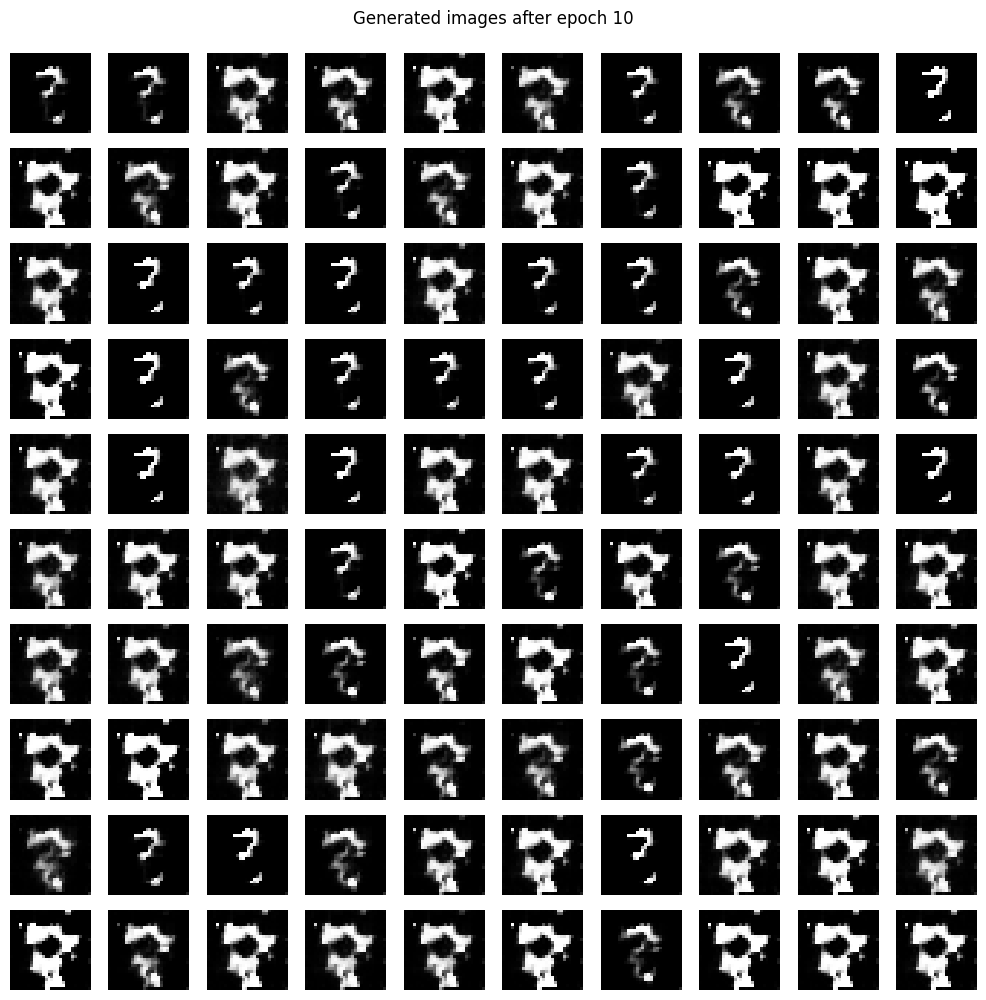


Epoch 11/50
Batch 400, D Loss: 0.5434, G Loss: 3.6062
Epoch 12/50
Batch 400, D Loss: 0.4643, G Loss: 4.2409
Epoch 13/50
Batch 400, D Loss: 0.5982, G Loss: 3.1121
Epoch 14/50
Batch 400, D Loss: 0.5392, G Loss: 3.4043
Epoch 15/50
Batch 400, D Loss: 0.4821, G Loss: 3.9147
Epoch 16/50
Batch 400, D Loss: 0.5894, G Loss: 3.1580
Epoch 17/50
Batch 400, D Loss: 0.5930, G Loss: 3.1269
Epoch 18/50
Batch 400, D Loss: 0.5208, G Loss: 3.6548
Epoch 19/50
Batch 400, D Loss: 0.5816, G Loss: 2.8174
Epoch 20/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


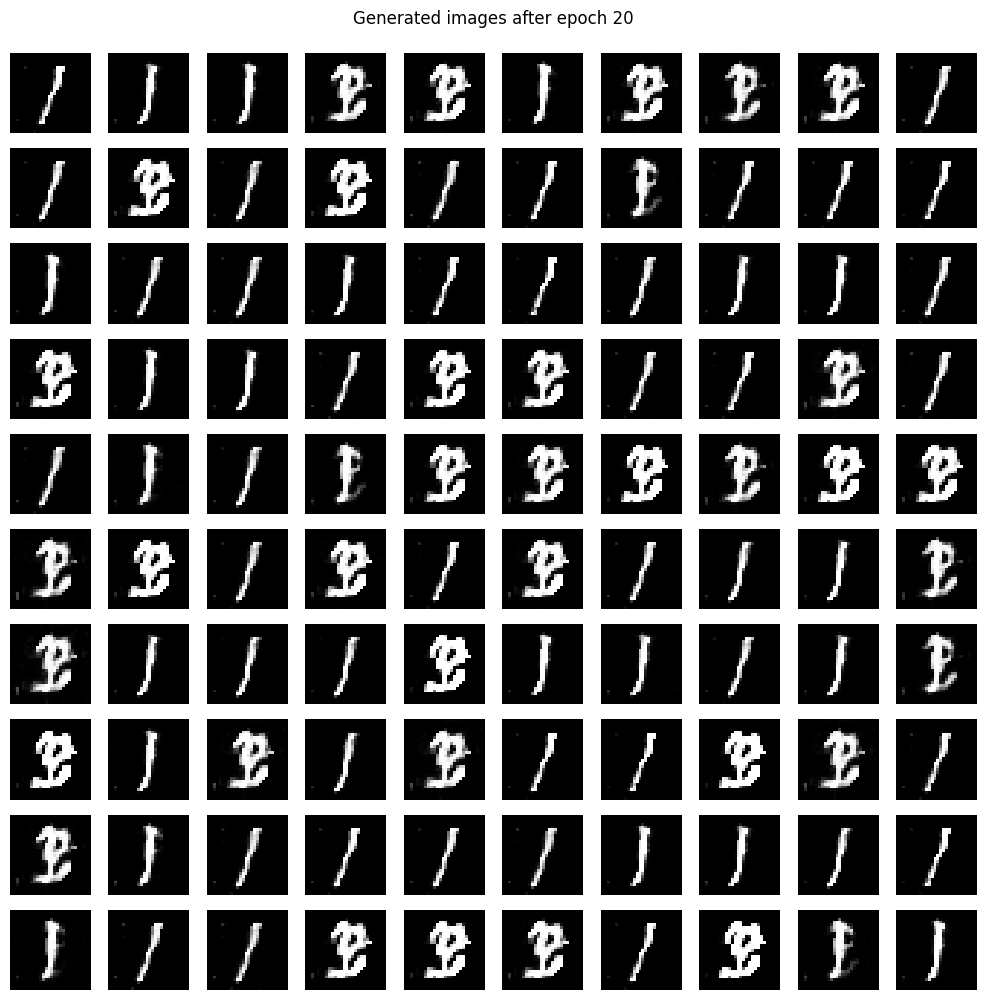


Epoch 21/50
Batch 400, D Loss: 0.5407, G Loss: 3.1572
Epoch 22/50
Batch 400, D Loss: 0.6639, G Loss: 2.8939
Epoch 23/50
Batch 400, D Loss: 0.6813, G Loss: 2.9698
Epoch 24/50
Batch 400, D Loss: 0.5655, G Loss: 3.0469
Epoch 25/50
Batch 400, D Loss: 0.6239, G Loss: 3.0292
Epoch 26/50
Batch 400, D Loss: 0.6024, G Loss: 2.9956
Epoch 27/50
Batch 400, D Loss: 0.5889, G Loss: 3.2299
Epoch 28/50
Batch 400, D Loss: 0.6254, G Loss: 3.0262
Epoch 29/50
Batch 400, D Loss: 0.5709, G Loss: 3.1662
Epoch 30/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


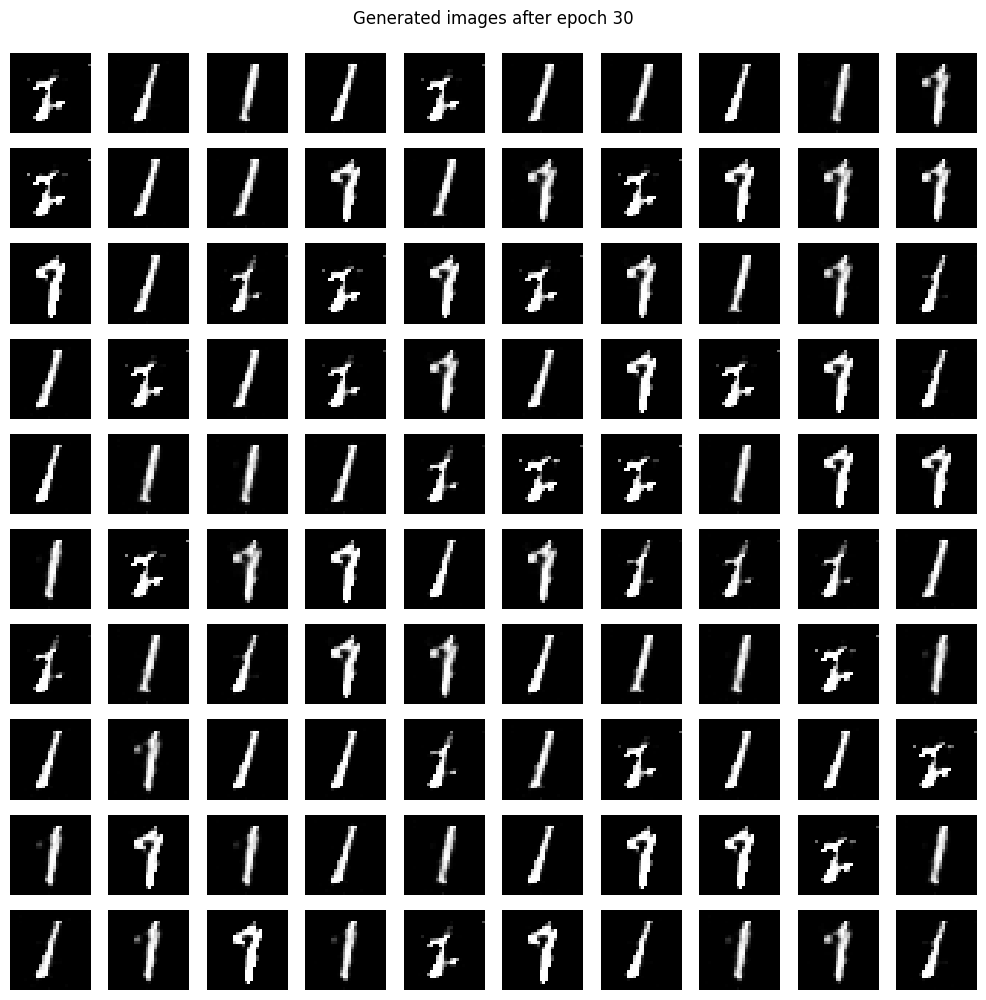


Epoch 31/50
Batch 400, D Loss: 0.5969, G Loss: 3.1949
Epoch 32/50
Batch 400, D Loss: 0.5545, G Loss: 2.9211
Epoch 33/50
Batch 400, D Loss: 0.5837, G Loss: 3.3758
Epoch 34/50
Batch 400, D Loss: 0.6281, G Loss: 2.7723
Epoch 35/50
Batch 400, D Loss: 0.5307, G Loss: 3.2522
Epoch 36/50
Batch 400, D Loss: 0.5740, G Loss: 3.2971
Epoch 37/50
Batch 400, D Loss: 0.6936, G Loss: 2.9577
Epoch 38/50
Batch 400, D Loss: 0.5674, G Loss: 3.0668
Epoch 39/50
Batch 400, D Loss: 0.5723, G Loss: 3.0693
Epoch 40/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


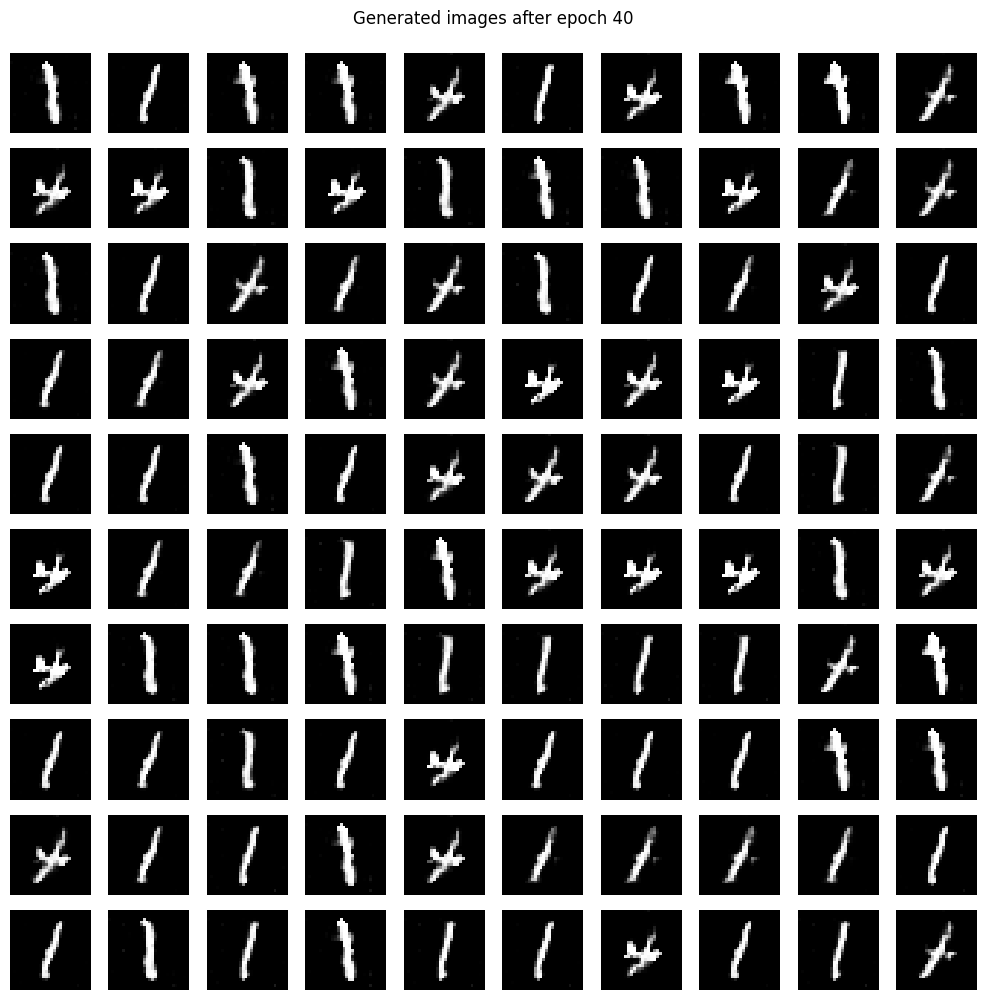


Epoch 41/50
Batch 400, D Loss: 0.6309, G Loss: 3.0633
Epoch 42/50
Batch 400, D Loss: 0.6277, G Loss: 2.9720
Epoch 43/50
Batch 400, D Loss: 0.5638, G Loss: 3.2102
Epoch 44/50
Batch 400, D Loss: 0.5730, G Loss: 3.0451
Epoch 45/50
Batch 400, D Loss: 0.5734, G Loss: 3.3182
Epoch 46/50
Batch 400, D Loss: 0.5567, G Loss: 3.3065
Epoch 47/50
Batch 400, D Loss: 0.5260, G Loss: 3.2978
Epoch 48/50
Batch 400, D Loss: 0.5884, G Loss: 2.7872
Epoch 49/50
Batch 400, D Loss: 0.6513, G Loss: 2.9554
Epoch 50/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


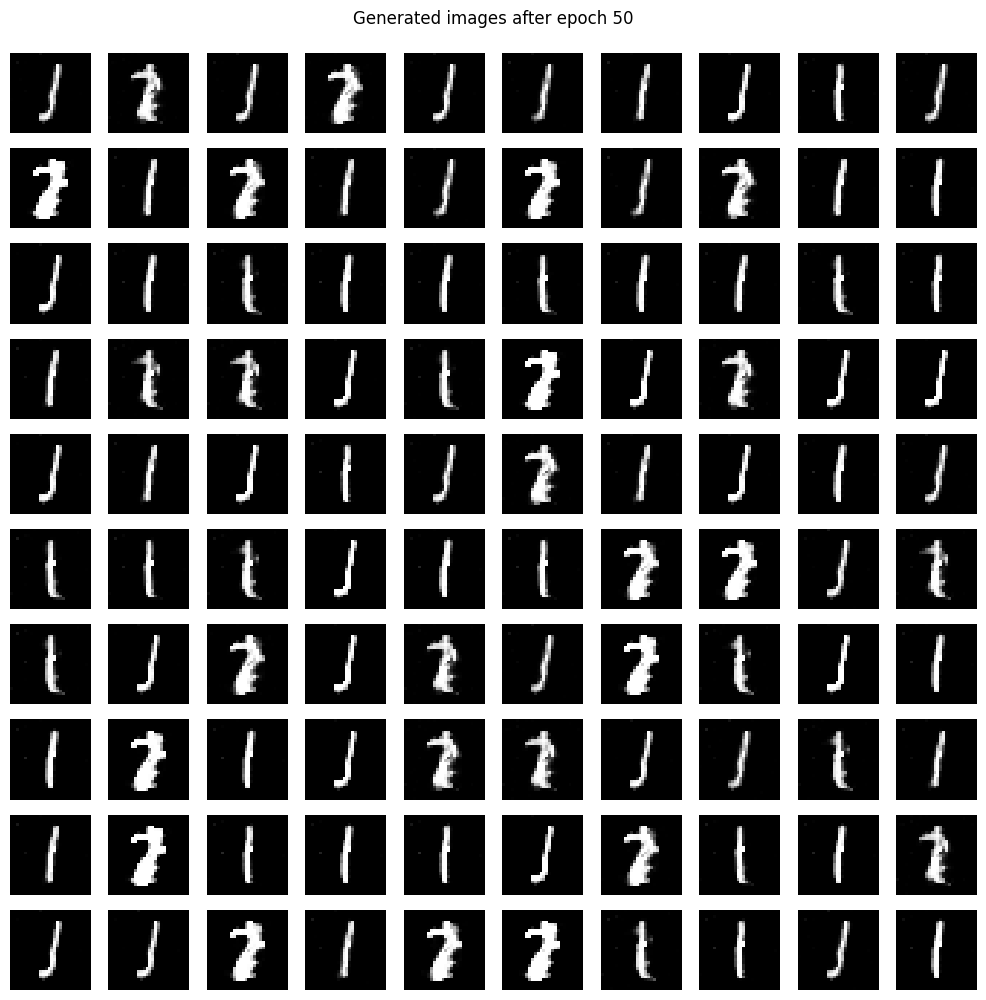

In [173]:
train(epochs=50, batch_size=128)

With 3 Conv layer, model cannot generate numbers clearly

In [174]:
def create_discriminator_with_4_conv():
    discriminator = Sequential()

    discriminator.add(Reshape((28, 28, 1), input_shape=(784,)))

    discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Conv2D(256, kernel_size=3, strides=2, padding='same'))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Conv2D(512, kernel_size=3, strides=2, padding='same'))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))

    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer(), metrics=['accuracy'])
    return discriminator


In [175]:
def adam_optimizer():
    return Adam(learning_rate=0.0005, beta_1=0.5)

In [176]:
class GAN:
    def __init__(self):
        # Initialize models
        self.generator = create_generator()
        self.discriminator = create_discriminator_with_4_conv()
        learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.0002,
        decay_steps=10000,
        decay_rate=0.9,
        staircase=True)

        # Initialize optimizers with mixed precision
        self.g_optimizer = Adam(learning_rate=learning_rate, beta_1=0.5)
        self.d_optimizer = Adam(learning_rate=learning_rate, beta_1=0.5)

        # Loss function
        self.loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    @tf.function(reduce_retracing=True)
    def train_discriminator(self, real_images, batch_size):
        real_images = tf.cast(real_images, tf.float16)
        noise = tf.random.normal([batch_size, 100], dtype=tf.float16)

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Get predictions
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            # Create labels
            real_labels = tf.ones_like(real_output)* 0.9 # label smoothing
            fake_labels = tf.zeros_like(fake_output)

            # Calculate losses
            real_loss = self.loss_fn(real_labels, real_output)
            fake_loss = self.loss_fn(fake_labels, fake_output)
            total_loss = real_loss + fake_loss

        # Calculate gradients
        gradients = tape.gradient(total_loss, self.discriminator.trainable_variables)

        # Apply gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))

        return total_loss

    @tf.function(reduce_retracing=True)
    def train_generator(self, batch_size):
        noise = tf.random.normal([batch_size, 100], dtype=tf.float16)

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Get predictions
            fake_output = self.discriminator(generated_images, training=False)

            # Calculate loss
            labels = tf.ones_like(fake_output)
            loss = self.loss_fn(labels, fake_output)

        # Calculate gradients
        gradients = tape.gradient(loss, self.generator.trainable_variables)

        # Apply gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        return loss



def train(epochs=50, batch_size=128):
    # Load and prepare data
    x_train, _, _, _ = load_data()
    dataset_size = x_train.shape[0]

    # Create dataset with fixed shapes and types
    dataset = tf.data.Dataset.from_tensor_slices(x_train) \
        .shuffle(dataset_size) \
        .batch(batch_size, drop_remainder=True) \
        .prefetch(tf.data.AUTOTUNE)

    # Initialize GAN
    gan = GAN()

    # Training loop
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        for batch_idx, real_images in enumerate(dataset):
            d_loss = gan.train_discriminator(real_images, batch_size)
            g_loss = gan.train_generator(batch_size)

            if batch_idx % 100 == 0:
                print(f"\rBatch {batch_idx}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}", end="")

        # Generate and save images every 10 epochs
        if (epoch + 1) % 10 == 0:
            plot_generated_images(epoch + 1, gan.generator)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1/50
Batch 400, D Loss: 0.6454, G Loss: 3.5971
Epoch 2/50
Batch 400, D Loss: 0.4450, G Loss: 5.2309
Epoch 3/50
Batch 400, D Loss: 0.4489, G Loss: 5.5631
Epoch 4/50
Batch 400, D Loss: 0.4149, G Loss: 5.5460
Epoch 5/50
Batch 400, D Loss: 0.3862, G Loss: 6.2793
Epoch 6/50
Batch 400, D Loss: 0.4308, G Loss: 5.7632
Epoch 7/50
Batch 400, D Loss: 0.4202, G Loss: 6.0928
Epoch 8/50
Batch 400, D Loss: 0.3653, G Loss: 8.2415
Epoch 9/50
Batch 400, D Loss: 0.4558, G Loss: 5.2199
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step


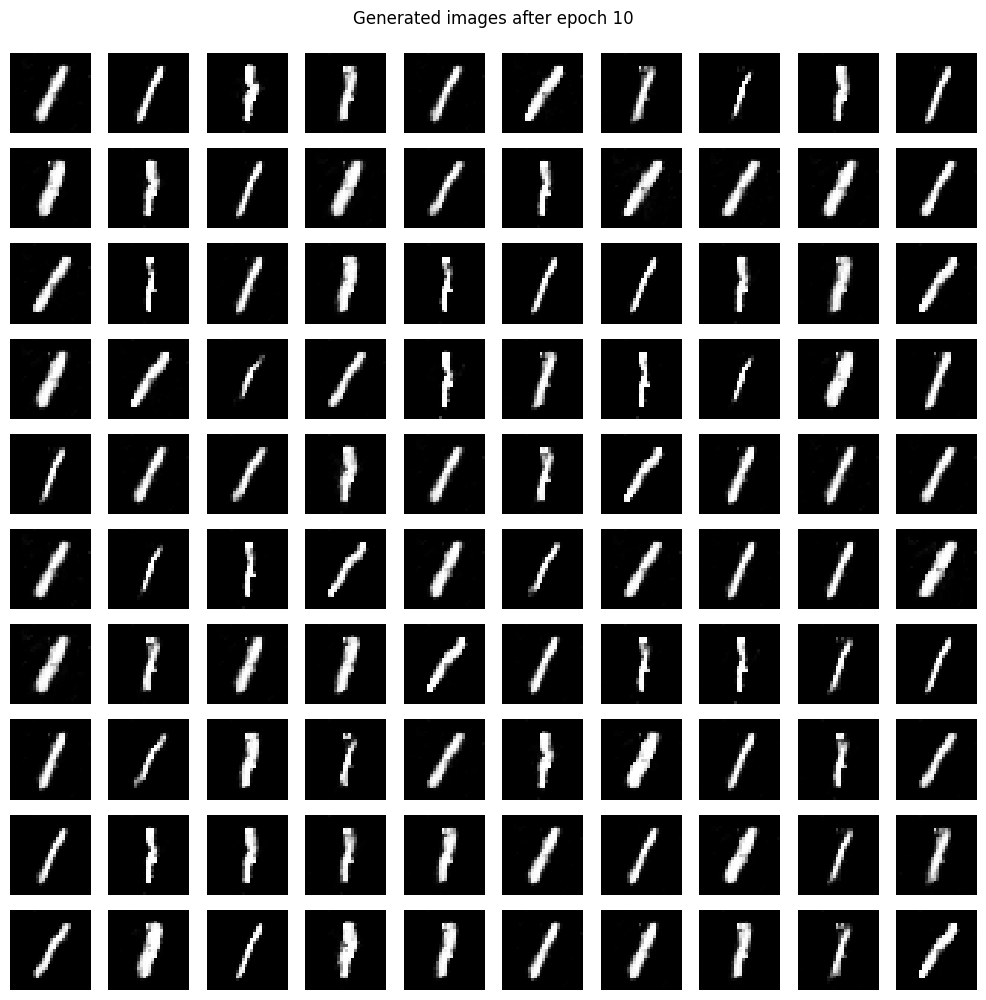


Epoch 11/50
Batch 400, D Loss: 0.5776, G Loss: 3.2599
Epoch 12/50
Batch 400, D Loss: 0.5763, G Loss: 3.0544
Epoch 13/50
Batch 400, D Loss: 0.6775, G Loss: 2.9675
Epoch 14/50
Batch 400, D Loss: 0.7055, G Loss: 2.5129
Epoch 15/50
Batch 400, D Loss: 0.6464, G Loss: 2.9333
Epoch 16/50
Batch 400, D Loss: 0.6006, G Loss: 2.7170
Epoch 17/50
Batch 400, D Loss: 0.7493, G Loss: 2.4540
Epoch 18/50
Batch 400, D Loss: 0.5887, G Loss: 3.1800
Epoch 19/50
Batch 400, D Loss: 0.6294, G Loss: 2.7996
Epoch 20/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


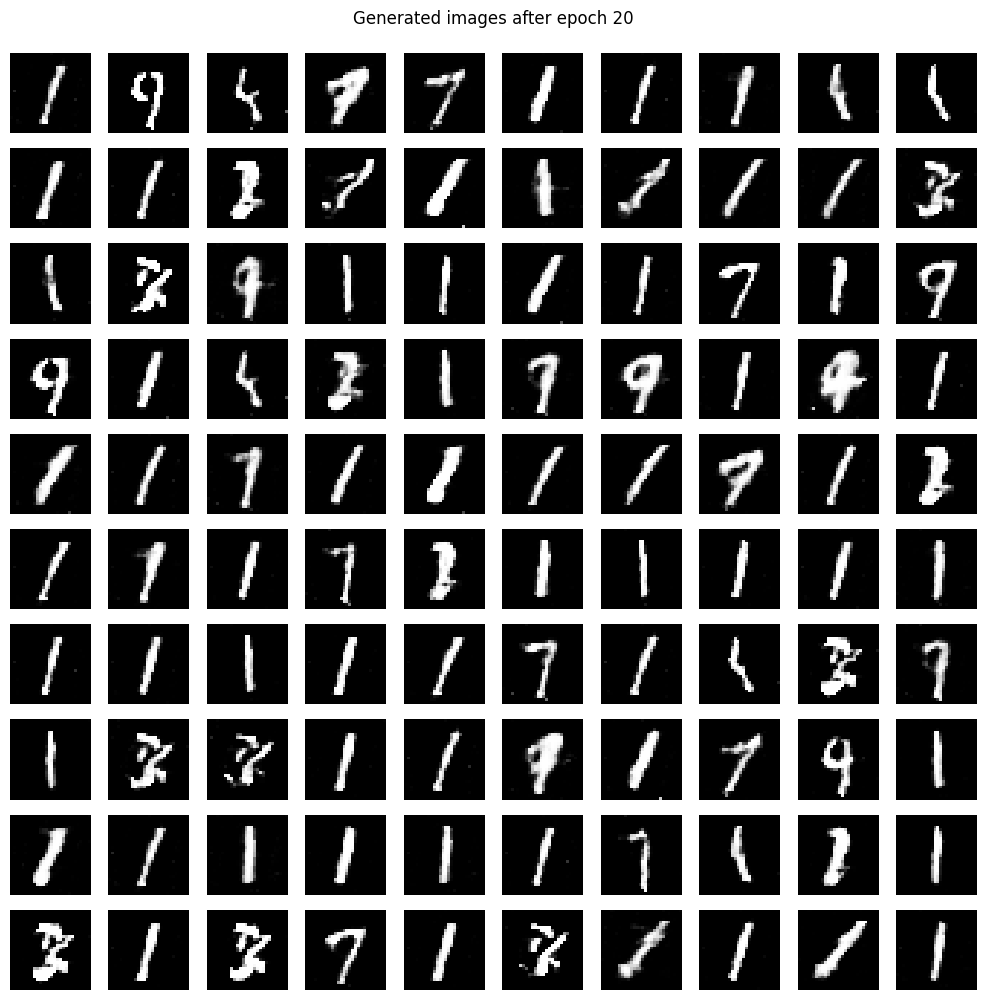


Epoch 21/50
Batch 400, D Loss: 0.8365, G Loss: 2.2800
Epoch 22/50
Batch 400, D Loss: 0.6529, G Loss: 2.7684
Epoch 23/50
Batch 400, D Loss: 0.7177, G Loss: 2.5990
Epoch 24/50
Batch 400, D Loss: 0.7630, G Loss: 2.4040
Epoch 25/50
Batch 400, D Loss: 0.9199, G Loss: 2.3780
Epoch 26/50
Batch 400, D Loss: 0.7897, G Loss: 2.1563
Epoch 27/50
Batch 400, D Loss: 0.7348, G Loss: 2.5737
Epoch 28/50
Batch 400, D Loss: 0.8009, G Loss: 2.3355
Epoch 29/50
Batch 400, D Loss: 0.6445, G Loss: 2.5948
Epoch 30/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


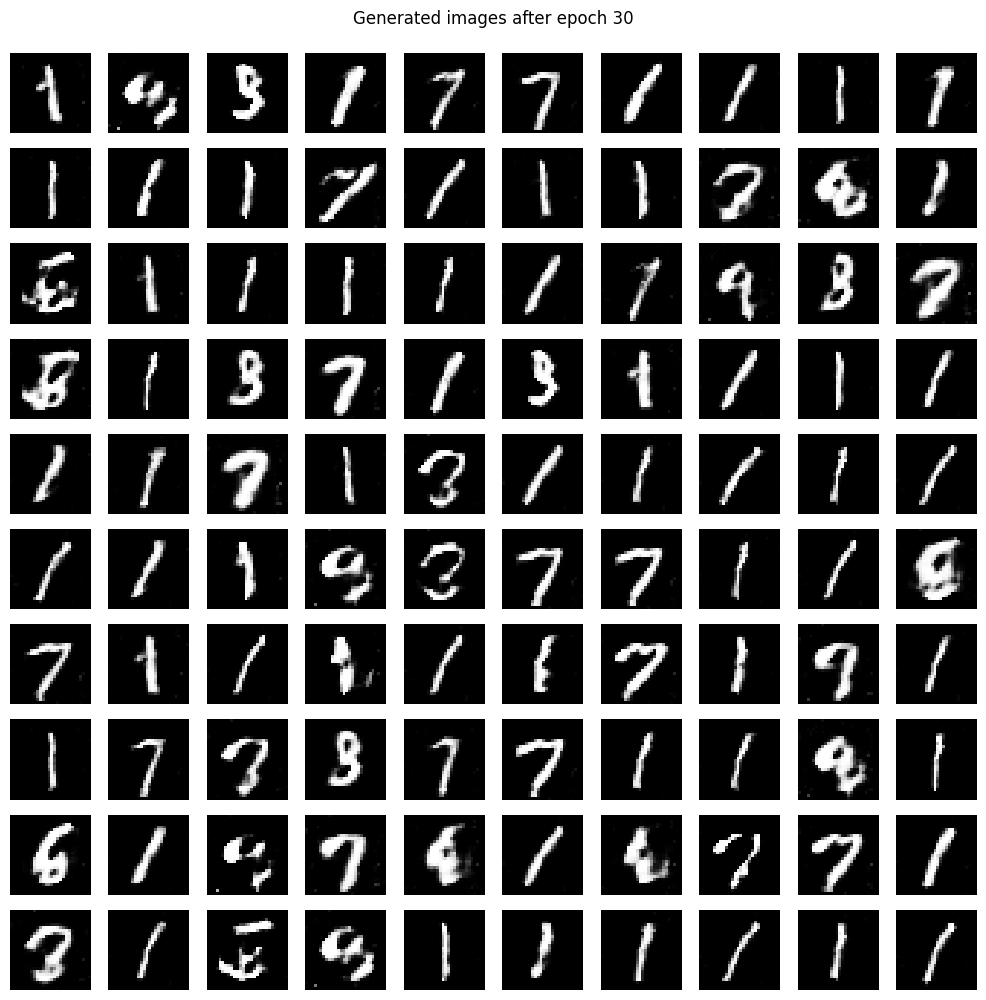


Epoch 31/50
Batch 400, D Loss: 0.8356, G Loss: 2.3020
Epoch 32/50
Batch 400, D Loss: 0.8027, G Loss: 2.3806
Epoch 33/50
Batch 400, D Loss: 0.8304, G Loss: 2.2956
Epoch 34/50
Batch 400, D Loss: 0.8472, G Loss: 2.2518
Epoch 35/50
Batch 400, D Loss: 0.6813, G Loss: 2.8897
Epoch 36/50
Batch 400, D Loss: 0.7223, G Loss: 2.4394
Epoch 37/50
Batch 400, D Loss: 0.8116, G Loss: 2.3237
Epoch 38/50
Batch 400, D Loss: 0.7891, G Loss: 2.3014
Epoch 39/50
Batch 400, D Loss: 0.8048, G Loss: 2.0778
Epoch 40/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


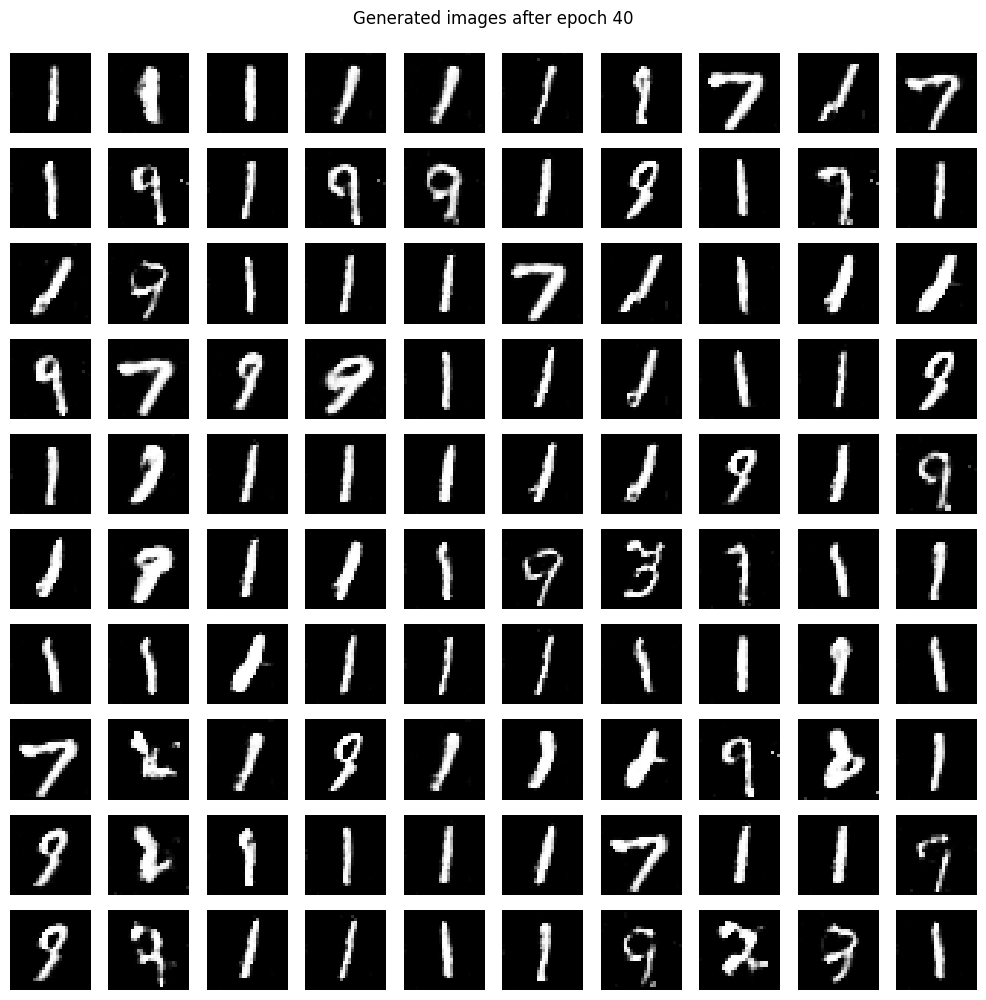


Epoch 41/50
Batch 400, D Loss: 0.7786, G Loss: 2.1805
Epoch 42/50
Batch 400, D Loss: 0.6787, G Loss: 2.7097
Epoch 43/50
Batch 400, D Loss: 0.7752, G Loss: 2.3636
Epoch 44/50
Batch 400, D Loss: 0.8206, G Loss: 2.0498
Epoch 45/50
Batch 400, D Loss: 0.9202, G Loss: 2.1476
Epoch 46/50
Batch 400, D Loss: 0.8079, G Loss: 2.1176
Epoch 47/50
Batch 400, D Loss: 0.7095, G Loss: 2.6681
Epoch 48/50
Batch 400, D Loss: 0.7732, G Loss: 2.4783
Epoch 49/50
Batch 400, D Loss: 0.7135, G Loss: 2.5337
Epoch 50/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


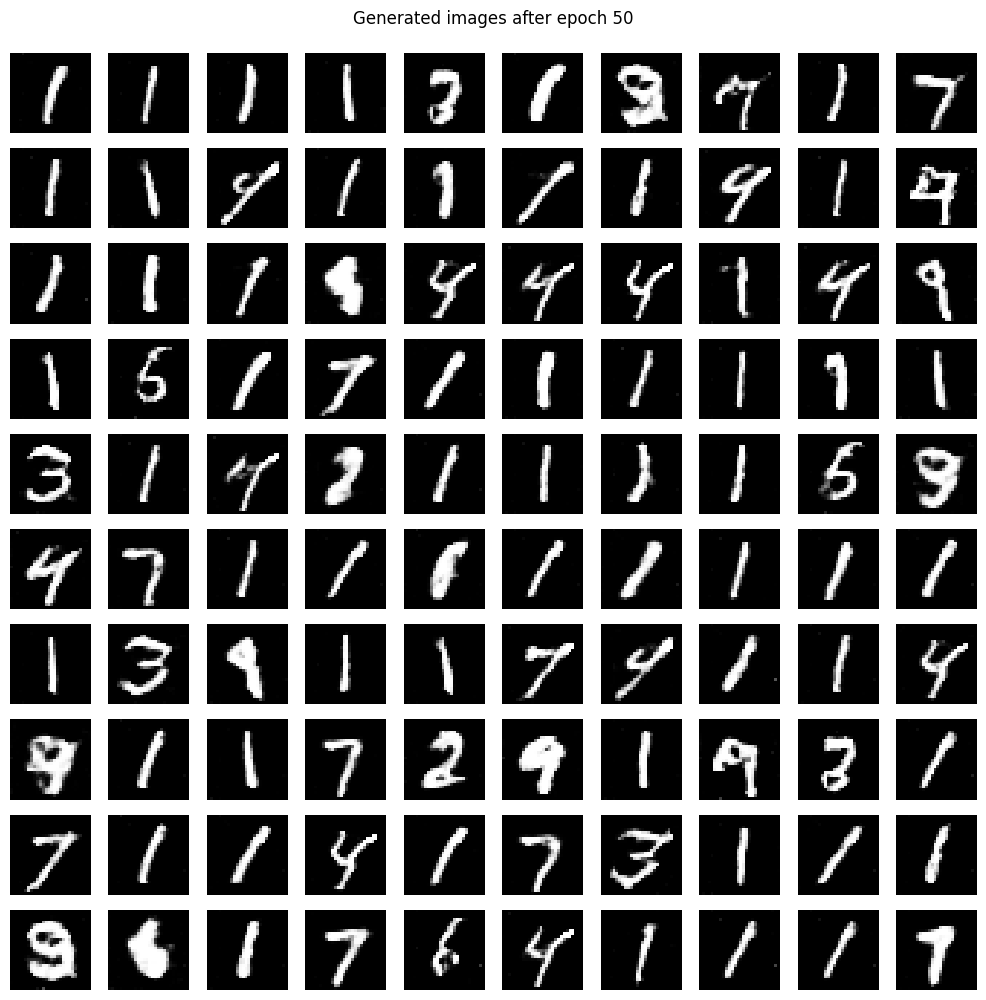

In [177]:
train(epochs=50, batch_size=128)

I tried same model with learning rate = 0.0004

In [178]:
def adam_optimizer():
    return Adam(learning_rate=0.0004, beta_1=0.5)


Epoch 1/50
Batch 400, D Loss: 0.4488, G Loss: 4.4971
Epoch 2/50
Batch 400, D Loss: 0.5007, G Loss: 4.4129
Epoch 3/50
Batch 400, D Loss: 0.3951, G Loss: 5.6060
Epoch 4/50
Batch 400, D Loss: 0.4757, G Loss: 6.0809
Epoch 5/50
Batch 400, D Loss: 0.3538, G Loss: 7.6124
Epoch 6/50
Batch 400, D Loss: 0.3697, G Loss: 7.6063
Epoch 7/50
Batch 400, D Loss: 0.3609, G Loss: 7.2853
Epoch 8/50
Batch 400, D Loss: 0.4166, G Loss: 5.5888
Epoch 9/50
Batch 400, D Loss: 0.6484, G Loss: 3.0104
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step


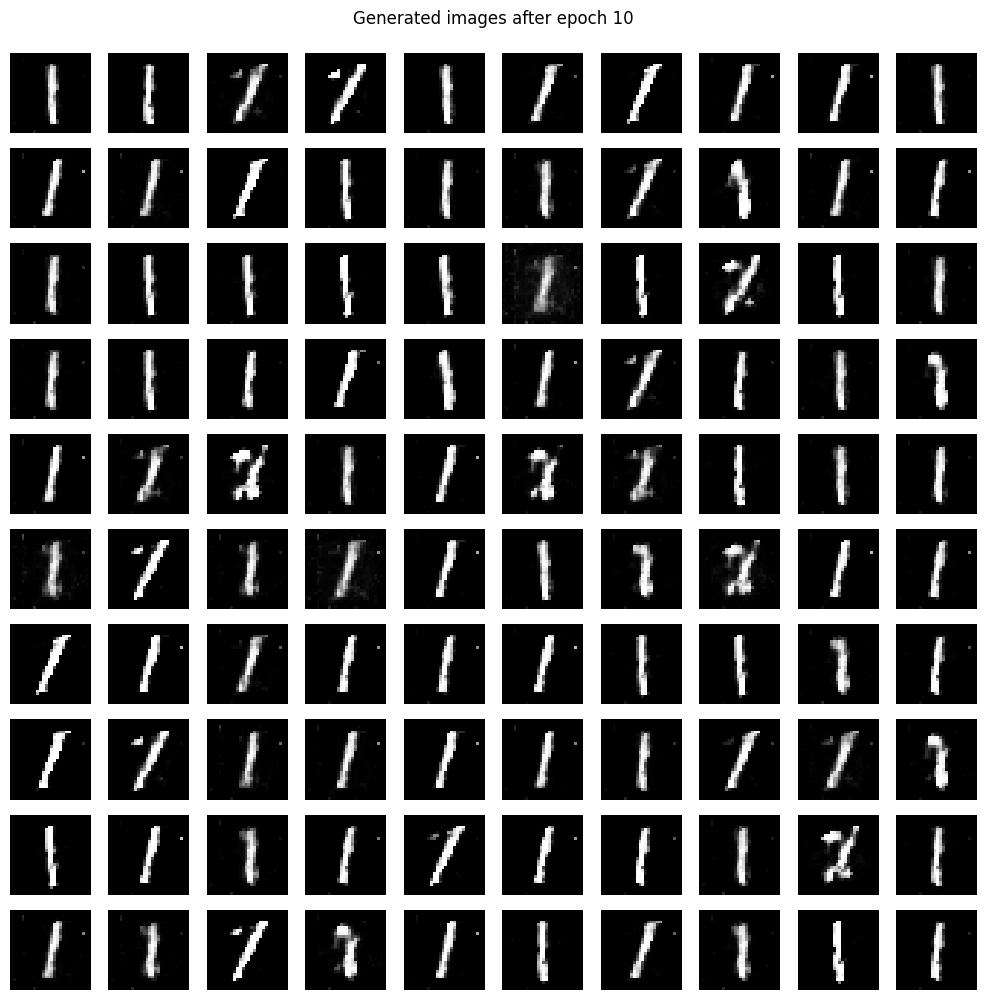


Epoch 11/50
Batch 400, D Loss: 0.5210, G Loss: 3.8441
Epoch 12/50
Batch 400, D Loss: 0.5882, G Loss: 2.8136
Epoch 13/50
Batch 400, D Loss: 0.6157, G Loss: 2.8580
Epoch 14/50
Batch 400, D Loss: 0.5802, G Loss: 2.9258
Epoch 15/50
Batch 400, D Loss: 0.5807, G Loss: 3.1974
Epoch 16/50
Batch 400, D Loss: 0.6805, G Loss: 2.9804
Epoch 17/50
Batch 400, D Loss: 0.7737, G Loss: 2.6442
Epoch 18/50
Batch 400, D Loss: 0.6535, G Loss: 2.9359
Epoch 19/50
Batch 400, D Loss: 0.6670, G Loss: 2.6250
Epoch 20/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


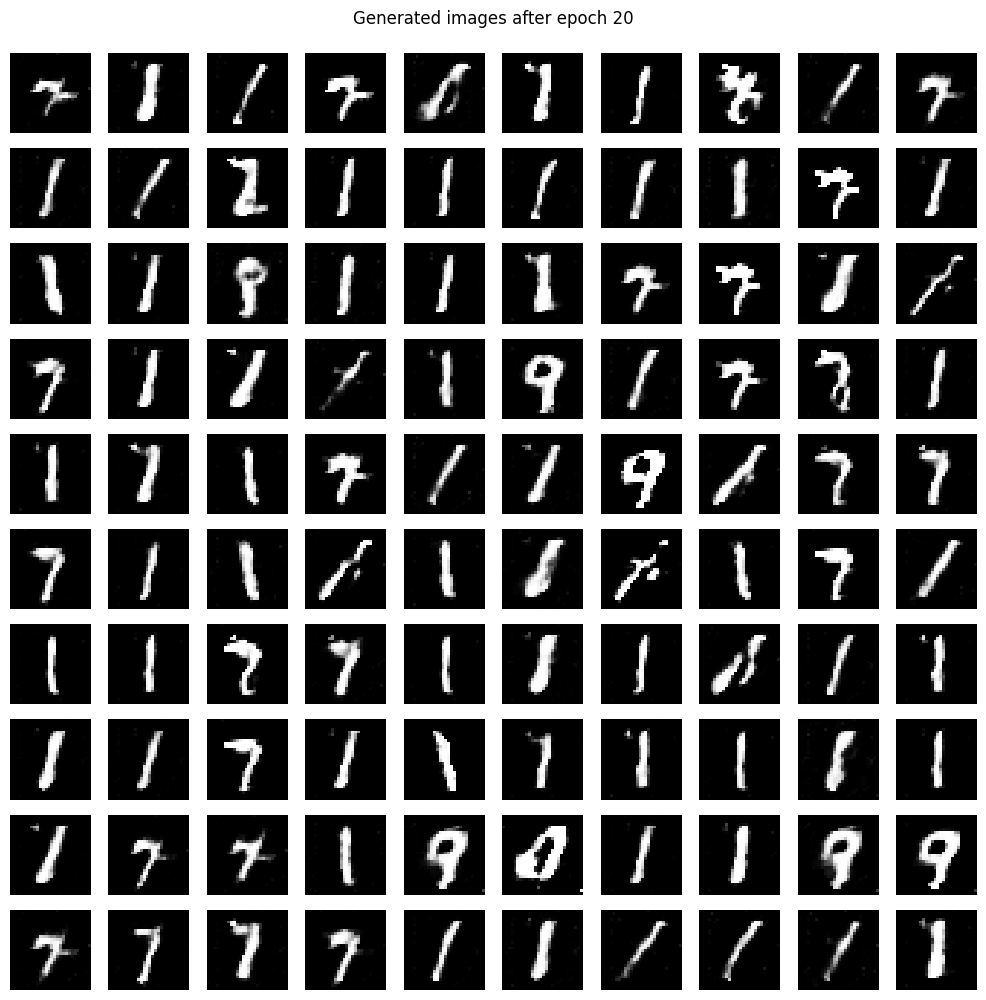


Epoch 21/50
Batch 400, D Loss: 0.7461, G Loss: 2.6835
Epoch 22/50
Batch 400, D Loss: 0.7889, G Loss: 2.4215
Epoch 23/50
Batch 400, D Loss: 0.7646, G Loss: 2.5540
Epoch 24/50
Batch 400, D Loss: 0.7039, G Loss: 2.7344
Epoch 25/50
Batch 400, D Loss: 0.8157, G Loss: 2.1937
Epoch 26/50
Batch 400, D Loss: 0.8540, G Loss: 2.4730
Epoch 27/50
Batch 400, D Loss: 0.7713, G Loss: 2.5824
Epoch 28/50
Batch 400, D Loss: 0.7432, G Loss: 2.4967
Epoch 29/50
Batch 400, D Loss: 0.7601, G Loss: 2.5801
Epoch 30/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


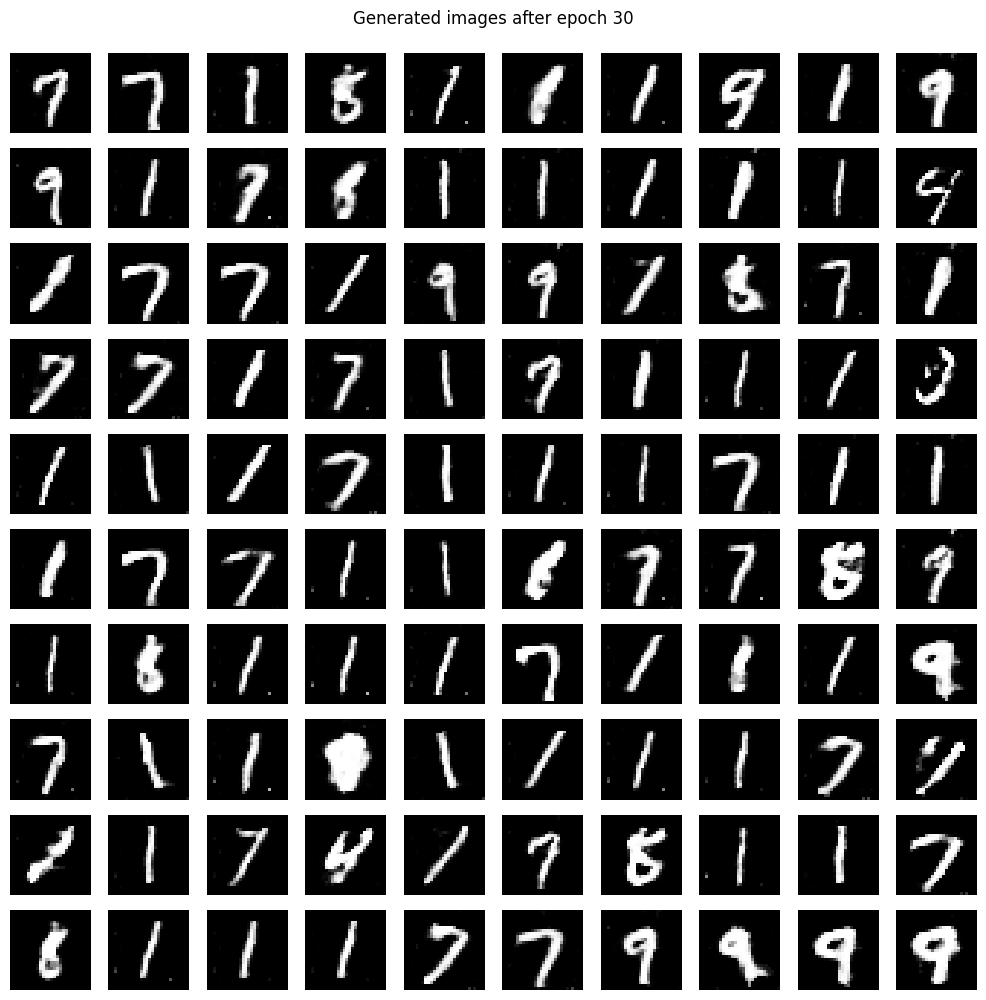


Epoch 31/50
Batch 400, D Loss: 0.7642, G Loss: 2.5269
Epoch 32/50
Batch 400, D Loss: 0.8621, G Loss: 2.2964
Epoch 33/50
Batch 400, D Loss: 0.8216, G Loss: 2.4495
Epoch 34/50
Batch 400, D Loss: 0.7676, G Loss: 2.6077
Epoch 35/50
Batch 400, D Loss: 0.7365, G Loss: 2.3478
Epoch 36/50
Batch 400, D Loss: 0.7540, G Loss: 2.5570
Epoch 37/50
Batch 400, D Loss: 0.8132, G Loss: 2.3083
Epoch 38/50
Batch 400, D Loss: 0.7941, G Loss: 1.9074
Epoch 39/50
Batch 400, D Loss: 0.7440, G Loss: 2.4050
Epoch 40/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


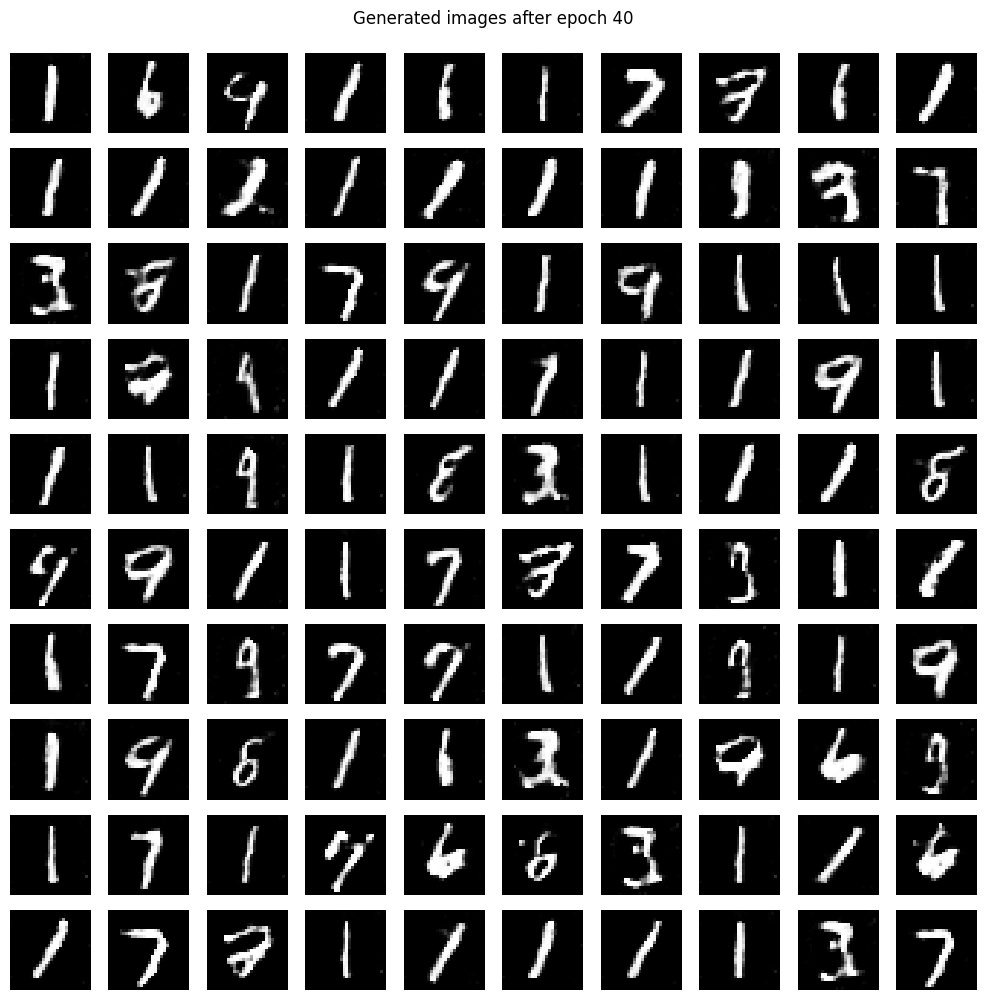


Epoch 41/50
Batch 400, D Loss: 0.8962, G Loss: 2.2928
Epoch 42/50
Batch 400, D Loss: 0.8704, G Loss: 2.4582
Epoch 43/50
Batch 400, D Loss: 0.7892, G Loss: 2.2904
Epoch 44/50
Batch 400, D Loss: 0.7666, G Loss: 2.5258
Epoch 45/50
Batch 400, D Loss: 0.7312, G Loss: 2.3420
Epoch 46/50
Batch 400, D Loss: 0.7827, G Loss: 2.3591
Epoch 47/50
Batch 400, D Loss: 0.8197, G Loss: 2.3435
Epoch 48/50
Batch 400, D Loss: 0.8662, G Loss: 2.2177
Epoch 49/50
Batch 400, D Loss: 0.8908, G Loss: 2.1781
Epoch 50/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


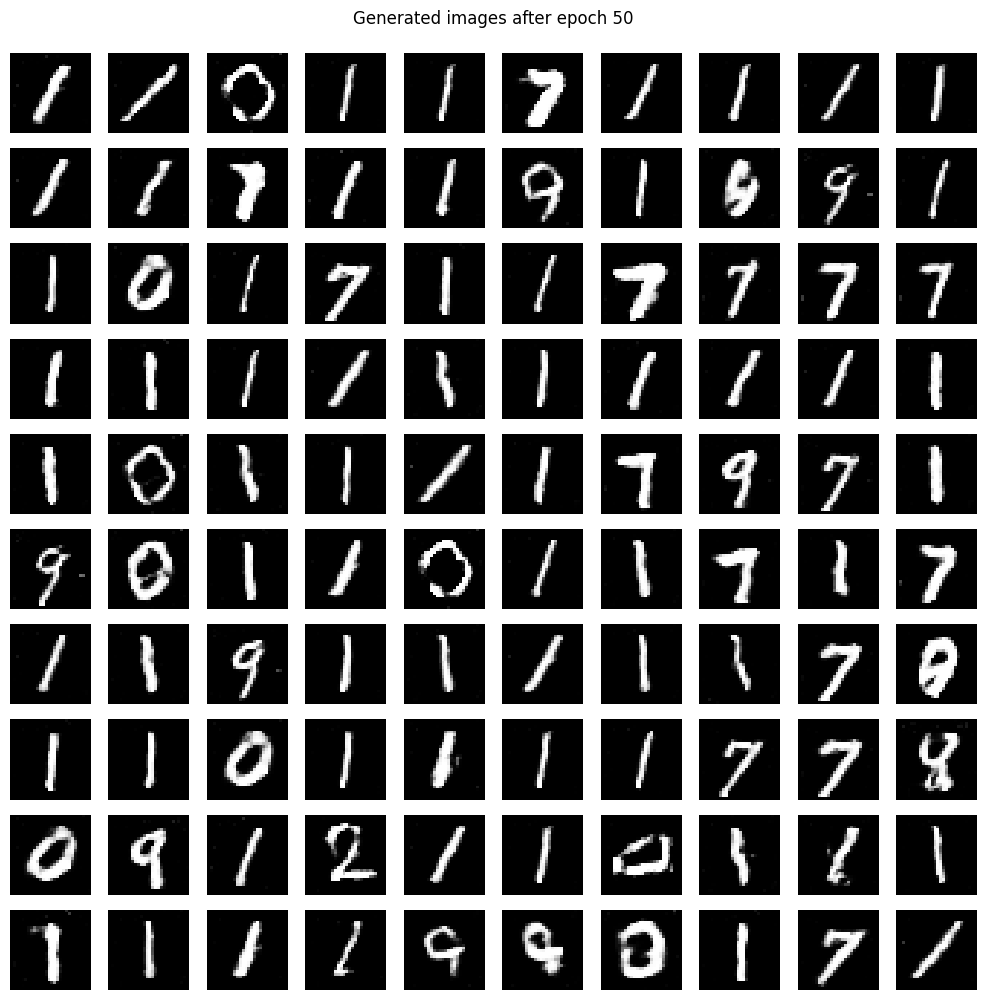

In [179]:
train(epochs=50, batch_size=128)

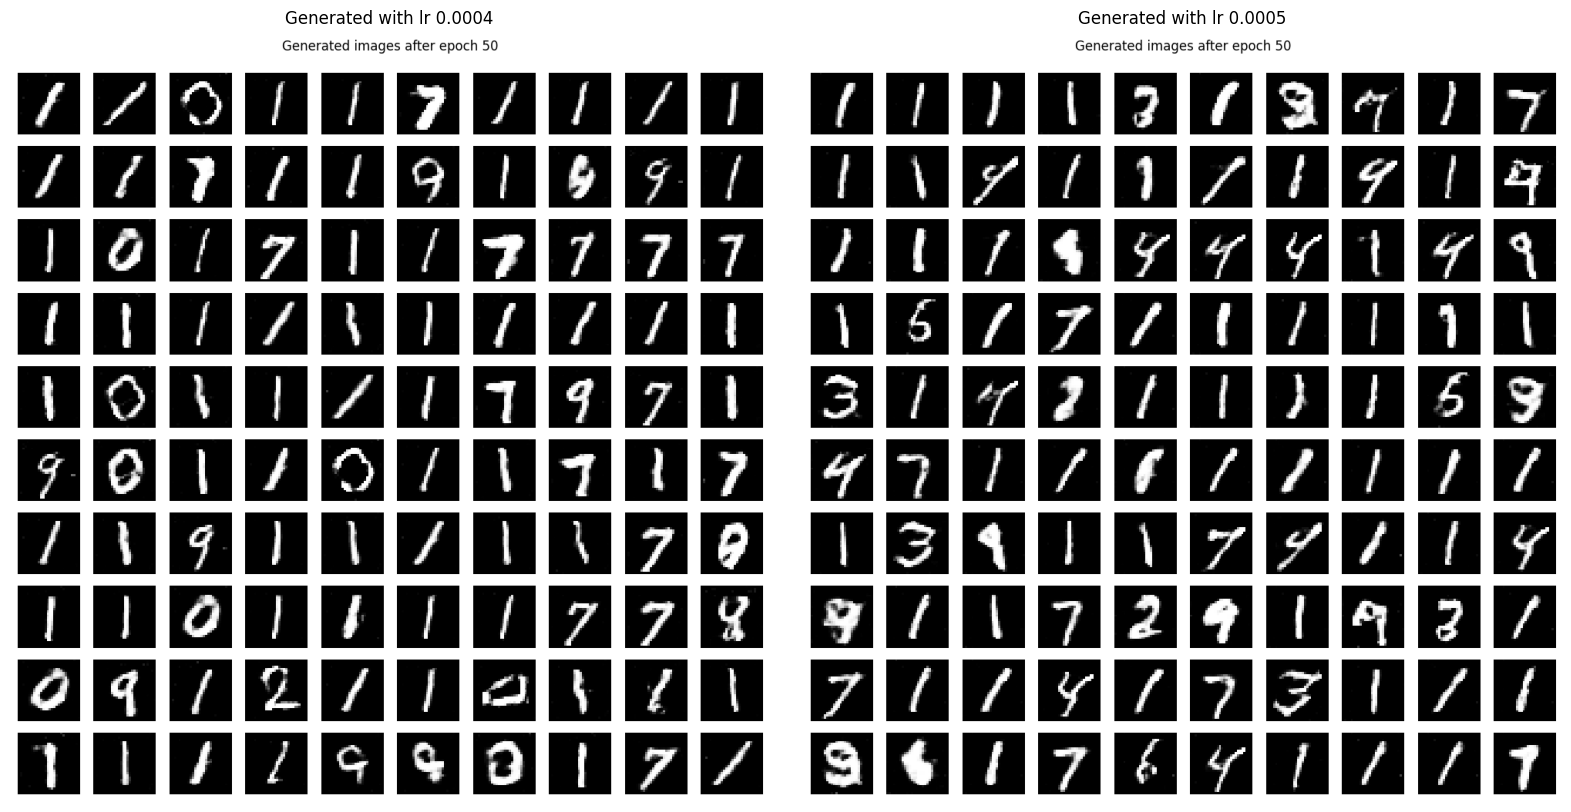

In [184]:
import matplotlib.pyplot as plt
from PIL import Image

img1 = Image.open('/content/same_model_lr_0.0004')
img2 = Image.open('/content/same_model_lr_0.0005')


fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(img1)
axes[0].axis('off')
axes[0].set_title('Generated with lr 0.0004')

axes[1].imshow(img2)
axes[1].axis('off')
axes[1].set_title('Generated with lr 0.0005')

plt.tight_layout()
plt.show()


I tried with 2 Conv layers

In [185]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

def create_discriminator_part1_conv2():
    discriminator = Sequential()
    discriminator.add(Reshape((28, 28, 1), input_shape=(784,)))

    discriminator.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    discriminator.add(layers.LeakyReLU(0.2))
    discriminator.add(layers.Dropout(0.3))

    discriminator.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    discriminator.add(layers.LeakyReLU(0.2))
    discriminator.add(layers.Dropout(0.3))

    discriminator.add(layers.Flatten())

    discriminator.add(layers.Dense(256))
    discriminator.add(layers.LeakyReLU(0.2))

    discriminator.add(layers.Dense(1, activation='sigmoid'))  # Output layer to predict real/fake

    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer(), metrics=['accuracy'])
    return discriminator


In [190]:
def adam_optimizer():
    return Adam(learning_rate=0.0005, beta_1=0.5)

In [187]:
class GAN:
    def __init__(self):
        # Initialize models
        self.generator = create_generator()
        self.discriminator = create_discriminator_part1_conv2()
        learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.0002,
        decay_steps=10000,
        decay_rate=0.9,
        staircase=True)
        # Initialize optimizers with mixed precision
        self.g_optimizer = Adam(learning_rate=learning_rate, beta_1=0.5)
        self.d_optimizer = Adam(learning_rate=learning_rate, beta_1=0.5)

        # Loss function
        self.loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    @tf.function(reduce_retracing=True)
    def train_discriminator(self, real_images, batch_size):
        real_images = tf.cast(real_images, tf.float16)
        noise = tf.random.normal([batch_size, 100], dtype=tf.float16)

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Get predictions
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            # Create labels
            real_labels = tf.ones_like(real_output)* 0.9
            fake_labels = tf.zeros_like(fake_output)

            # Calculate losses
            real_loss = self.loss_fn(real_labels, real_output)
            fake_loss = self.loss_fn(fake_labels, fake_output)
            total_loss = real_loss + fake_loss

        # Calculate gradients
        gradients = tape.gradient(total_loss, self.discriminator.trainable_variables)

        # Apply gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))

        return total_loss

    @tf.function(reduce_retracing=True)
    def train_generator(self, batch_size):
        noise = tf.random.normal([batch_size, 100], dtype=tf.float16)

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Get predictions
            fake_output = self.discriminator(generated_images, training=False)

            # Calculate loss
            labels = tf.ones_like(fake_output)
            loss = self.loss_fn(labels, fake_output)

        # Calculate gradients
        gradients = tape.gradient(loss, self.generator.trainable_variables)

        # Apply gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        return loss



def train(epochs=50, batch_size=128):
    # Load and prepare data
    x_train, _, _, _ = load_data()
    dataset_size = x_train.shape[0]

    # Create dataset with fixed shapes and types
    dataset = tf.data.Dataset.from_tensor_slices(x_train) \
        .shuffle(dataset_size) \
        .batch(batch_size, drop_remainder=True) \
        .prefetch(tf.data.AUTOTUNE)

    # Initialize GAN
    gan = GAN()

    # Training loop
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        for batch_idx, real_images in enumerate(dataset):
            d_loss = gan.train_discriminator(real_images, batch_size)
            g_loss = gan.train_generator(batch_size)

            if batch_idx % 100 == 0:
                print(f"\rBatch {batch_idx}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}", end="")

        # Generate and save images every 10 epochs
        if (epoch + 1) % 10 == 0:
            plot_generated_images(epoch + 1, gan.generator)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1/50
Batch 400, D Loss: 0.7178, G Loss: 2.2393
Epoch 2/50
Batch 400, D Loss: 0.6840, G Loss: 2.6780
Epoch 3/50
Batch 400, D Loss: 0.5017, G Loss: 3.5099
Epoch 4/50
Batch 400, D Loss: 0.5116, G Loss: 4.1950
Epoch 5/50
Batch 400, D Loss: 0.5429, G Loss: 3.4967
Epoch 6/50
Batch 400, D Loss: 0.4163, G Loss: 4.1547
Epoch 7/50
Batch 400, D Loss: 0.4909, G Loss: 4.5203
Epoch 8/50
Batch 400, D Loss: 0.4999, G Loss: 3.9434
Epoch 9/50
Batch 400, D Loss: 0.6151, G Loss: 3.2116
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step


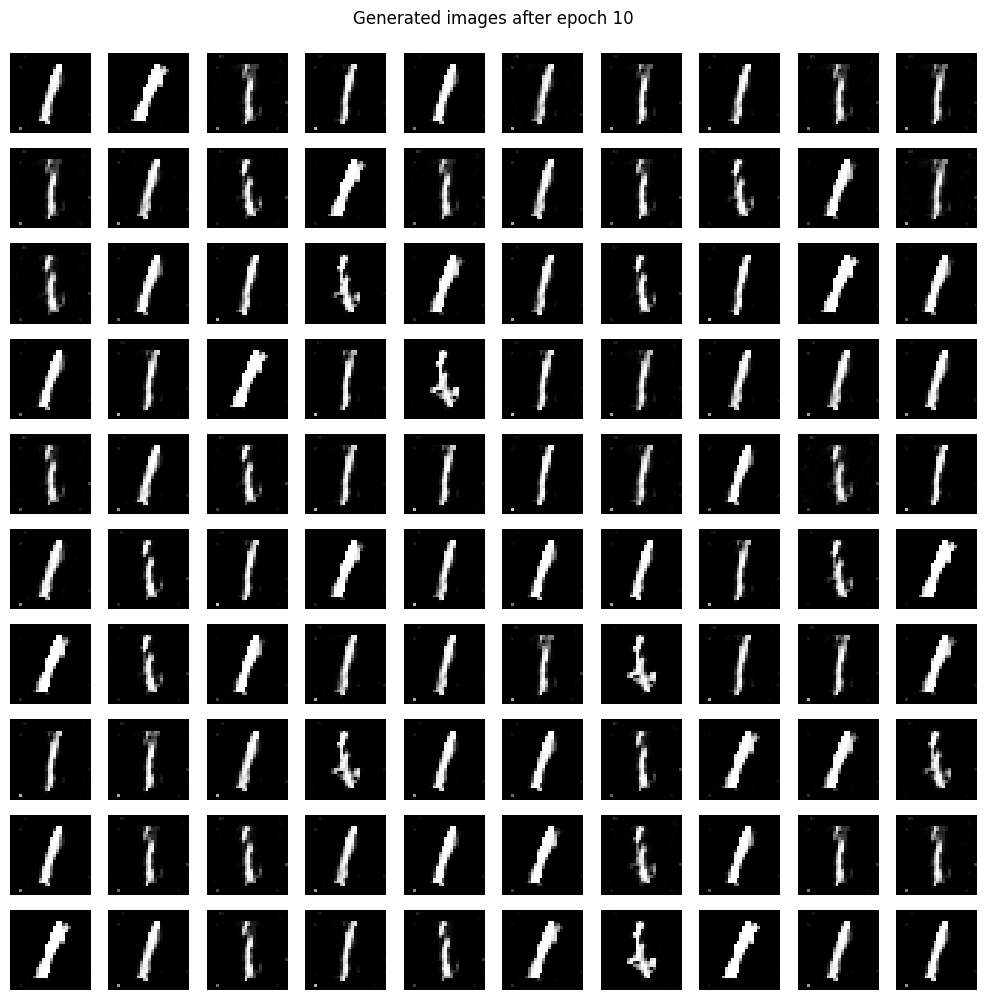


Epoch 11/50
Batch 400, D Loss: 0.5160, G Loss: 3.8678
Epoch 12/50
Batch 400, D Loss: 0.5748, G Loss: 4.6699
Epoch 13/50
Batch 400, D Loss: 0.5275, G Loss: 3.6163
Epoch 14/50
Batch 400, D Loss: 0.5773, G Loss: 3.6060
Epoch 15/50
Batch 400, D Loss: 0.5230, G Loss: 3.3989
Epoch 16/50
Batch 400, D Loss: 0.6225, G Loss: 2.8268
Epoch 17/50
Batch 400, D Loss: 0.7241, G Loss: 2.1711
Epoch 18/50
Batch 400, D Loss: 0.6863, G Loss: 2.6587
Epoch 19/50
Batch 400, D Loss: 0.7588, G Loss: 2.3697
Epoch 20/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


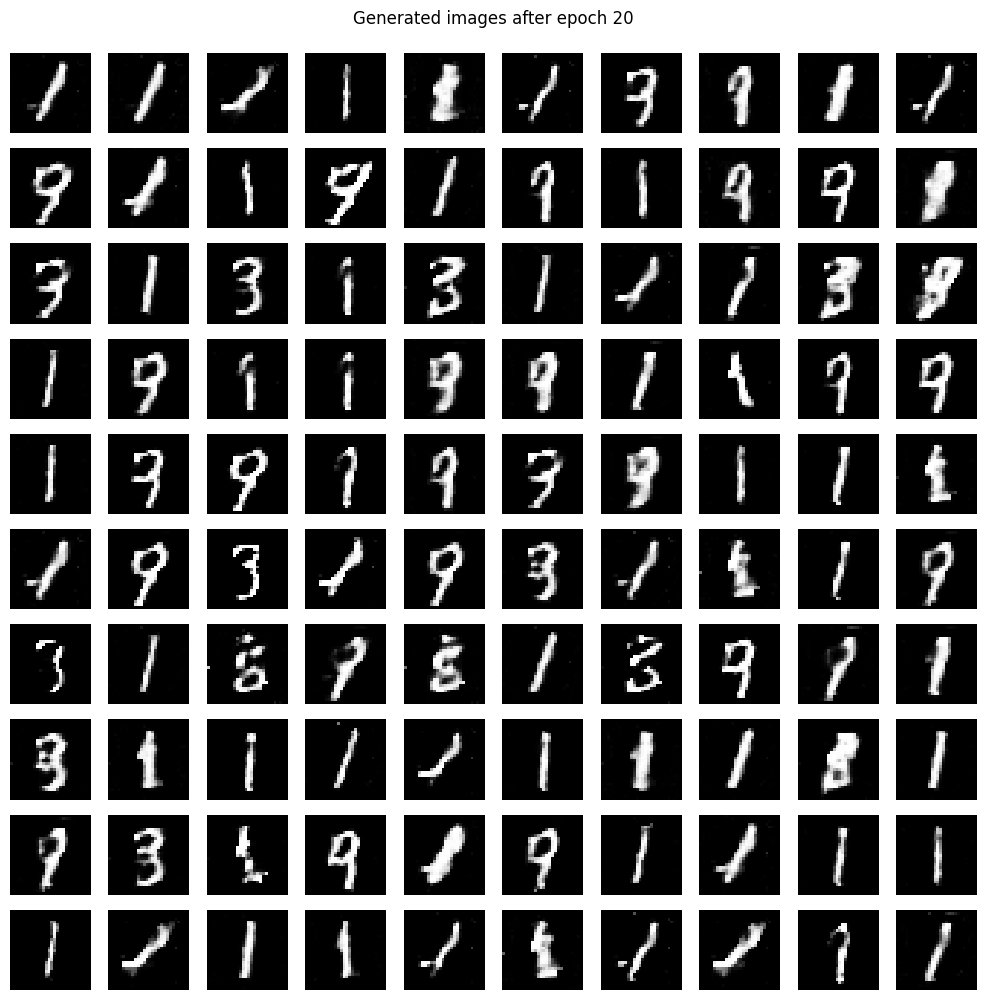


Epoch 21/50
Batch 400, D Loss: 0.7656, G Loss: 1.7259
Epoch 22/50
Batch 400, D Loss: 0.8356, G Loss: 1.8421
Epoch 23/50
Batch 400, D Loss: 0.7395, G Loss: 2.2547
Epoch 24/50
Batch 400, D Loss: 0.7989, G Loss: 2.1283
Epoch 25/50
Batch 400, D Loss: 0.7887, G Loss: 2.0387
Epoch 26/50
Batch 400, D Loss: 0.7155, G Loss: 2.3990
Epoch 27/50
Batch 400, D Loss: 0.7322, G Loss: 2.4415
Epoch 28/50
Batch 400, D Loss: 0.7969, G Loss: 1.8915
Epoch 29/50
Batch 400, D Loss: 0.8116, G Loss: 1.9014
Epoch 30/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


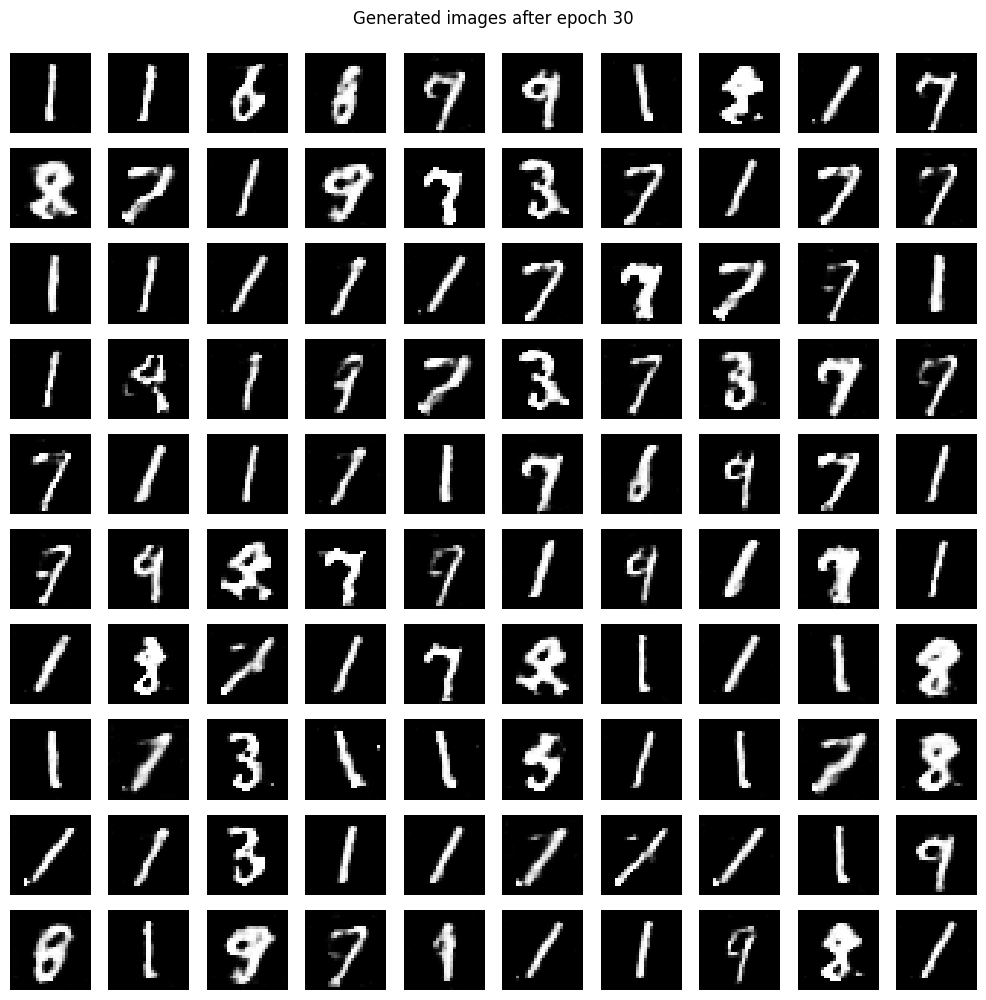


Epoch 31/50
Batch 400, D Loss: 0.7821, G Loss: 1.9779
Epoch 32/50
Batch 400, D Loss: 0.7437, G Loss: 1.9604
Epoch 33/50
Batch 400, D Loss: 0.8414, G Loss: 1.7539
Epoch 34/50
Batch 400, D Loss: 0.8715, G Loss: 1.6725
Epoch 35/50
Batch 400, D Loss: 0.9150, G Loss: 2.0640
Epoch 36/50
Batch 400, D Loss: 0.8463, G Loss: 1.7848
Epoch 37/50
Batch 400, D Loss: 0.8282, G Loss: 1.8567
Epoch 38/50
Batch 400, D Loss: 0.7957, G Loss: 1.7998
Epoch 39/50
Batch 400, D Loss: 0.8088, G Loss: 2.2535
Epoch 40/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


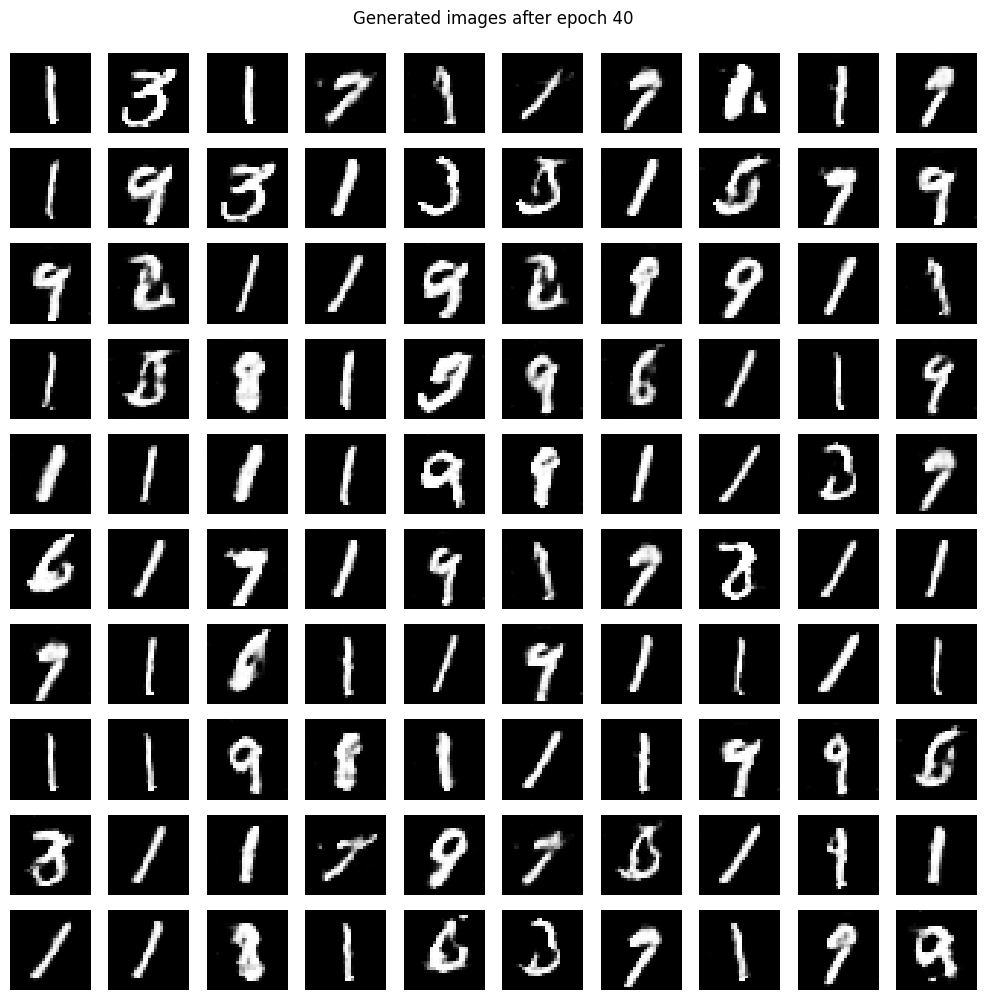


Epoch 41/50
Batch 400, D Loss: 0.8353, G Loss: 2.2586
Epoch 42/50
Batch 400, D Loss: 0.8031, G Loss: 1.8150
Epoch 43/50
Batch 400, D Loss: 0.8489, G Loss: 1.9213
Epoch 44/50
Batch 400, D Loss: 0.7248, G Loss: 2.3340
Epoch 45/50
Batch 400, D Loss: 0.8646, G Loss: 1.7031
Epoch 46/50
Batch 400, D Loss: 0.8142, G Loss: 2.0663
Epoch 47/50
Batch 400, D Loss: 0.7986, G Loss: 2.0855
Epoch 48/50
Batch 400, D Loss: 0.9181, G Loss: 1.9355
Epoch 49/50
Batch 400, D Loss: 0.8565, G Loss: 1.6211
Epoch 50/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


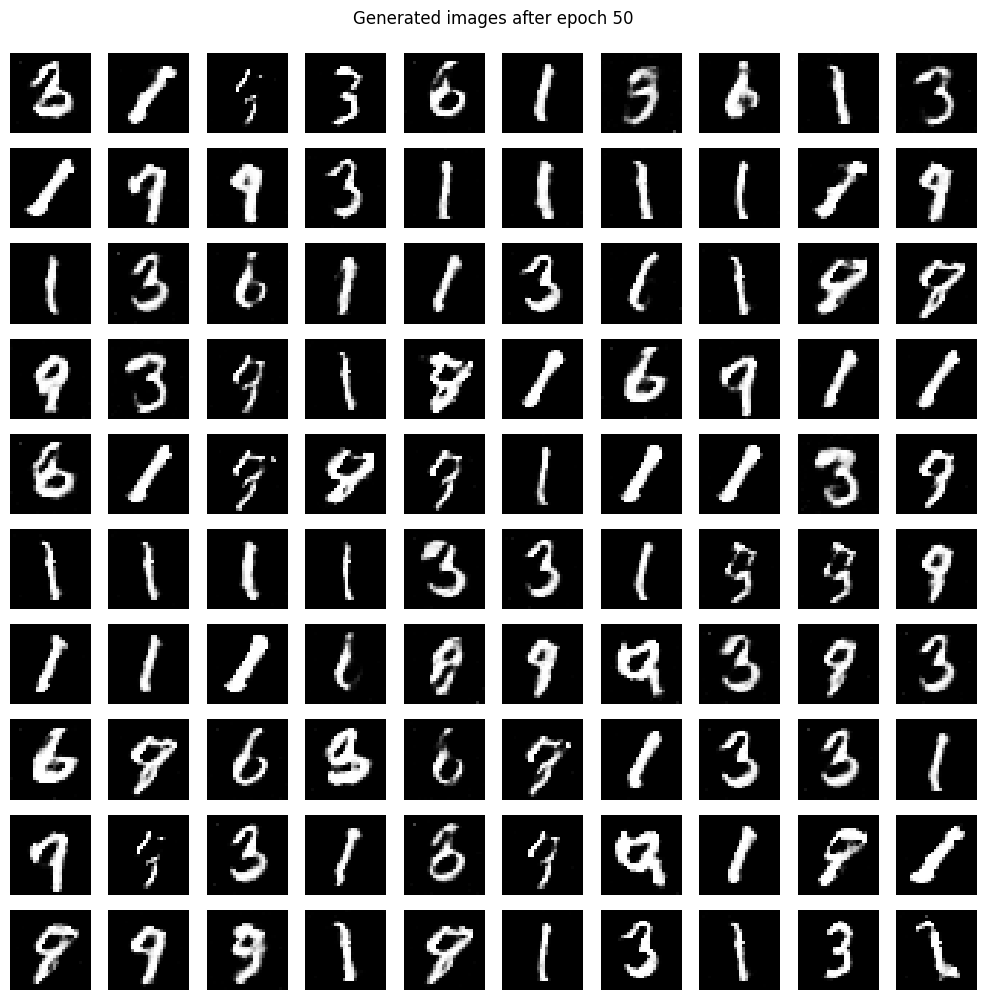

In [188]:
train(epochs=50, batch_size=128)

I think that we need to use fewer complex layers for the discriminator because we didn't change the generator so generated images are not look good.

In [189]:
def create_discriminator_reduced_complexity():
    model = Sequential()
    model.add(Reshape((28, 28, 1), input_shape=(784,)))

    # First convolutional layer
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', input_shape=(28, 28, 1)))
    model.add(LeakyReLU(alpha=0.2))

    # Second convolutional layer with fewer filters
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))  # Output layer

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])

    return model

In [191]:
def adam_optimizer():
    return Adam(learning_rate=0.0005, beta_1=0.5)

In [192]:
class GAN:
    def __init__(self):
        # Initialize models
        self.generator = create_generator()
        self.discriminator = create_discriminator_reduced_complexity()
        learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.0002,
        decay_steps=10000,
        decay_rate=0.9,
        staircase=True)
        # Initialize optimizers with mixed precision
        self.g_optimizer = Adam(learning_rate=learning_rate, beta_1=0.5)
        self.d_optimizer = Adam(learning_rate=learning_rate, beta_1=0.5)

        # Loss function
        self.loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    @tf.function(reduce_retracing=True)
    def train_discriminator(self, real_images, batch_size):
        real_images = tf.cast(real_images, tf.float16)
        noise = tf.random.normal([batch_size, 100], dtype=tf.float16)

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Get predictions
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            # Create labels
            real_labels = tf.ones_like(real_output)* 0.9
            fake_labels = tf.zeros_like(fake_output)

            # Calculate losses
            real_loss = self.loss_fn(real_labels, real_output)
            fake_loss = self.loss_fn(fake_labels, fake_output)
            total_loss = real_loss + fake_loss

        # Calculate gradients
        gradients = tape.gradient(total_loss, self.discriminator.trainable_variables)

        # Apply gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))

        return total_loss

    @tf.function(reduce_retracing=True)
    def train_generator(self, batch_size):
        noise = tf.random.normal([batch_size, 100], dtype=tf.float16)

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Get predictions
            fake_output = self.discriminator(generated_images, training=False)

            # Calculate loss
            labels = tf.ones_like(fake_output)
            loss = self.loss_fn(labels, fake_output)

        # Calculate gradients
        gradients = tape.gradient(loss, self.generator.trainable_variables)

        # Apply gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        return loss



def train(epochs=50, batch_size=128):
    # Load and prepare data
    x_train, _, _, _ = load_data()
    dataset_size = x_train.shape[0]

    # Create dataset with fixed shapes and types
    dataset = tf.data.Dataset.from_tensor_slices(x_train) \
        .shuffle(dataset_size) \
        .batch(batch_size, drop_remainder=True) \
        .prefetch(tf.data.AUTOTUNE)

    # Initialize GAN
    gan = GAN()

    # Training loop
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        for batch_idx, real_images in enumerate(dataset):
            d_loss = gan.train_discriminator(real_images, batch_size)
            g_loss = gan.train_generator(batch_size)

            if batch_idx % 100 == 0:
                print(f"\rBatch {batch_idx}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}", end="")

        # Generate and save images every 10 epochs
        if (epoch + 1) % 10 == 0:
            plot_generated_images(epoch + 1, gan.generator)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dis


Epoch 1/50
Batch 400, D Loss: 1.0760, G Loss: 1.0950
Epoch 2/50
Batch 400, D Loss: 1.3118, G Loss: 0.8807
Epoch 3/50
Batch 400, D Loss: 1.2330, G Loss: 1.0135
Epoch 4/50
Batch 400, D Loss: 1.0555, G Loss: 1.1933
Epoch 5/50
Batch 400, D Loss: 1.1614, G Loss: 1.1802
Epoch 6/50
Batch 400, D Loss: 1.3997, G Loss: 0.9957
Epoch 7/50
Batch 400, D Loss: 0.8856, G Loss: 1.4579
Epoch 8/50
Batch 400, D Loss: 1.2748, G Loss: 0.9615
Epoch 9/50
Batch 400, D Loss: 1.4409, G Loss: 0.9343
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step


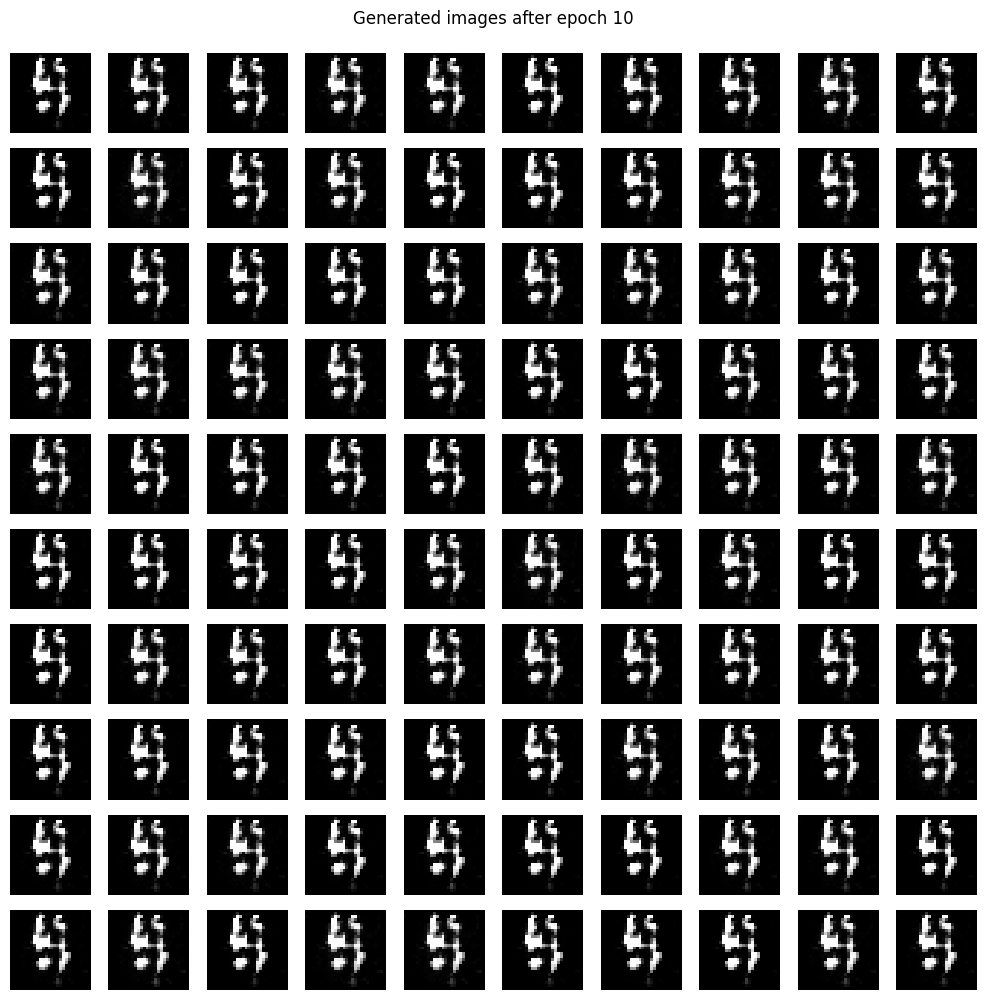


Epoch 11/50
Batch 400, D Loss: 1.0060, G Loss: 1.4808
Epoch 12/50
Batch 400, D Loss: 0.8027, G Loss: 1.6359
Epoch 13/50
Batch 400, D Loss: 0.6392, G Loss: 2.0457
Epoch 14/50
Batch 400, D Loss: 0.8466, G Loss: 1.7228
Epoch 15/50
Batch 400, D Loss: 1.6556, G Loss: 0.8398
Epoch 16/50
Batch 400, D Loss: 0.9146, G Loss: 1.6139
Epoch 17/50
Batch 400, D Loss: 0.7831, G Loss: 1.7083
Epoch 18/50
Batch 400, D Loss: 1.1167, G Loss: 1.2935
Epoch 19/50
Batch 400, D Loss: 1.3862, G Loss: 1.1263
Epoch 20/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


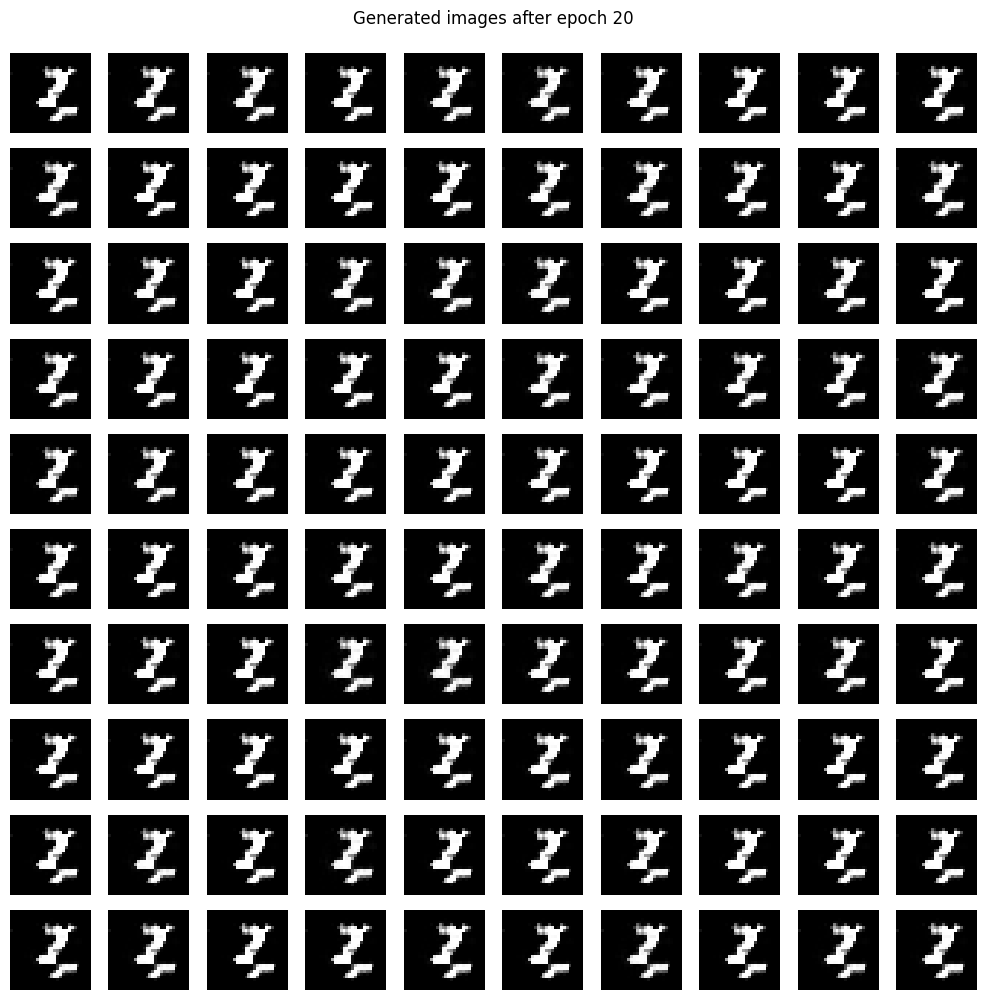


Epoch 21/50
Batch 400, D Loss: 1.2129, G Loss: 1.3460
Epoch 22/50
Batch 400, D Loss: 1.8980, G Loss: 0.8687
Epoch 23/50
Batch 400, D Loss: 1.1840, G Loss: 1.2955
Epoch 24/50
Batch 400, D Loss: 1.3442, G Loss: 1.0218
Epoch 25/50
Batch 400, D Loss: 0.6178, G Loss: 2.3545
Epoch 26/50
Batch 400, D Loss: 0.7947, G Loss: 1.6956
Epoch 27/50
Batch 400, D Loss: 0.9215, G Loss: 1.6598
Epoch 28/50
Batch 400, D Loss: 0.8461, G Loss: 1.7874
Epoch 29/50
Batch 400, D Loss: 0.5694, G Loss: 2.5758
Epoch 30/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


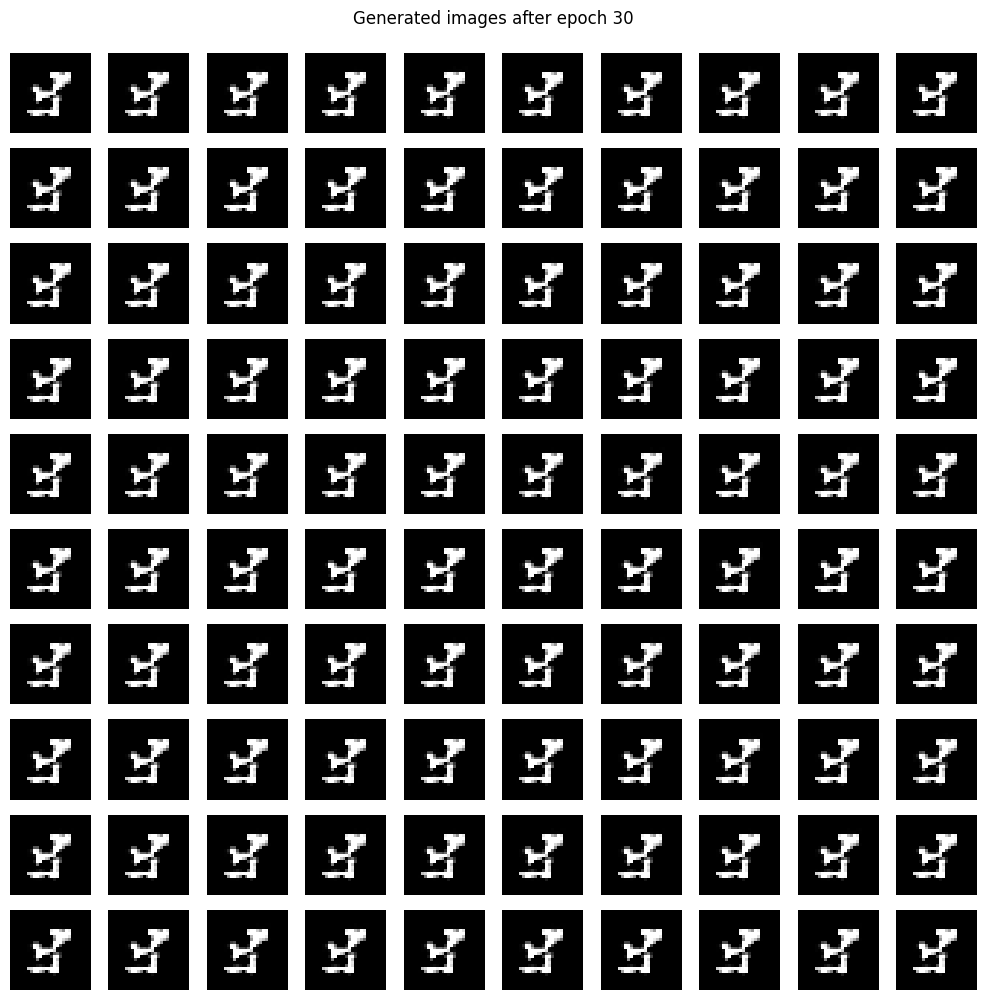


Epoch 31/50
Batch 400, D Loss: 0.9637, G Loss: 1.7563
Epoch 32/50
Batch 400, D Loss: 0.8955, G Loss: 1.7244

KeyboardInterrupt: 

In [193]:
train(epochs=50, batch_size=128)

I changed the distribution as multiplied by 2 version

In [195]:
class GAN:
    def __init__(self):
        # Initialize models
        self.generator = create_generator()
        self.discriminator = create_discriminator_part1_conv2()
        learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.0002,
        decay_steps=10000,
        decay_rate=0.9,
        staircase=True)
        # Initialize optimizers with mixed precision
        self.g_optimizer = Adam(learning_rate=learning_rate, beta_1=0.5)
        self.d_optimizer = Adam(learning_rate=learning_rate, beta_1=0.5)

        # Loss function
        self.loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    @tf.function(reduce_retracing=True)
    def train_discriminator(self, real_images, batch_size):
        real_images = tf.cast(real_images, tf.float16)
        noise = tf.random.normal([batch_size, 100], dtype=tf.float16) * 2.0

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Get predictions
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            # Create labels
            real_labels = tf.ones_like(real_output)* 0.9 # label smoothing
            fake_labels = tf.zeros_like(fake_output)

            # Calculate losses
            real_loss = self.loss_fn(real_labels, real_output)
            fake_loss = self.loss_fn(fake_labels, fake_output)
            total_loss = real_loss + fake_loss

        # Calculate gradients
        gradients = tape.gradient(total_loss, self.discriminator.trainable_variables)

        # Apply gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))

        return total_loss

    @tf.function(reduce_retracing=True)
    def train_generator(self, batch_size):
        noise = tf.random.normal([batch_size, 100], dtype=tf.float16)

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Get predictions
            fake_output = self.discriminator(generated_images, training=False)

            # Calculate loss
            labels = tf.ones_like(fake_output)
            loss = self.loss_fn(labels, fake_output)

        # Calculate gradients
        gradients = tape.gradient(loss, self.generator.trainable_variables)

        # Apply gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        return loss



def train(epochs=50, batch_size=128):
    # Load and prepare data
    x_train, _, _, _ = load_data()
    dataset_size = x_train.shape[0]

    # Create dataset with fixed shapes and types
    dataset = tf.data.Dataset.from_tensor_slices(x_train) \
        .shuffle(dataset_size) \
        .batch(batch_size, drop_remainder=True) \
        .prefetch(tf.data.AUTOTUNE)

    # Initialize GAN
    gan = GAN()

    # Training loop
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        for batch_idx, real_images in enumerate(dataset):
            d_loss = gan.train_discriminator(real_images, batch_size)
            g_loss = gan.train_generator(batch_size)

            if batch_idx % 100 == 0:
                print(f"\rBatch {batch_idx}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}", end="")

        # Generate and save images every 10 epochs
        if (epoch + 1) % 10 == 0:
            plot_generated_images(epoch + 1, gan.generator)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1/50
Batch 400, D Loss: 1.5320, G Loss: 1.7054
Epoch 2/50
Batch 400, D Loss: 0.8919, G Loss: 1.6684
Epoch 3/50
Batch 400, D Loss: 0.8274, G Loss: 2.1181
Epoch 4/50
Batch 400, D Loss: 0.5186, G Loss: 3.4670
Epoch 5/50
Batch 400, D Loss: 0.8921, G Loss: 2.2431
Epoch 6/50
Batch 400, D Loss: 0.5290, G Loss: 3.1561
Epoch 7/50
Batch 400, D Loss: 0.6202, G Loss: 3.1843
Epoch 8/50
Batch 400, D Loss: 0.5471, G Loss: 3.3199
Epoch 9/50
Batch 400, D Loss: 0.5880, G Loss: 3.2879
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step


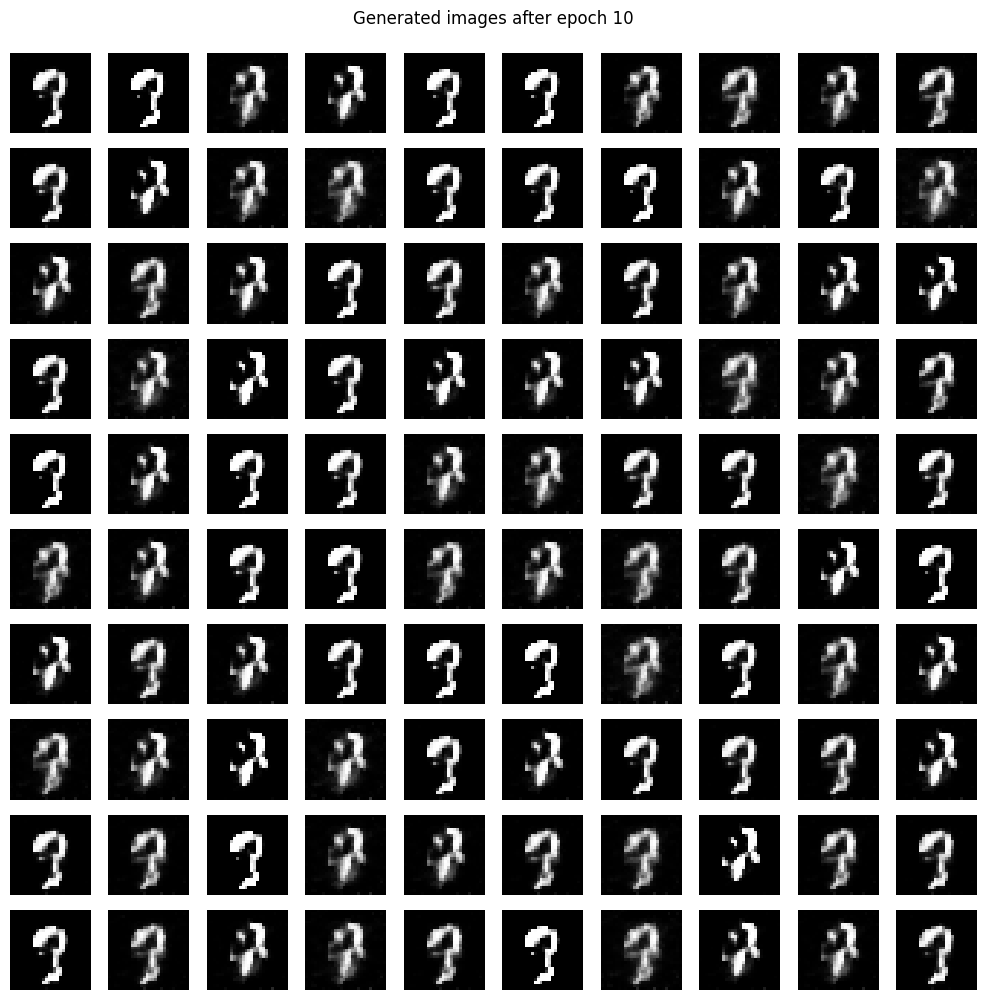


Epoch 11/50
Batch 400, D Loss: 0.6188, G Loss: 3.1352
Epoch 12/50
Batch 400, D Loss: 0.6304, G Loss: 2.8553
Epoch 13/50
Batch 400, D Loss: 0.5783, G Loss: 2.6362
Epoch 14/50
Batch 400, D Loss: 0.7112, G Loss: 2.5961
Epoch 15/50
Batch 400, D Loss: 0.7150, G Loss: 1.8396
Epoch 16/50
Batch 400, D Loss: 0.6790, G Loss: 2.5632
Epoch 17/50
Batch 400, D Loss: 0.7363, G Loss: 2.3153
Epoch 18/50
Batch 400, D Loss: 0.6751, G Loss: 2.5668
Epoch 19/50
Batch 400, D Loss: 0.7946, G Loss: 1.9154
Epoch 20/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


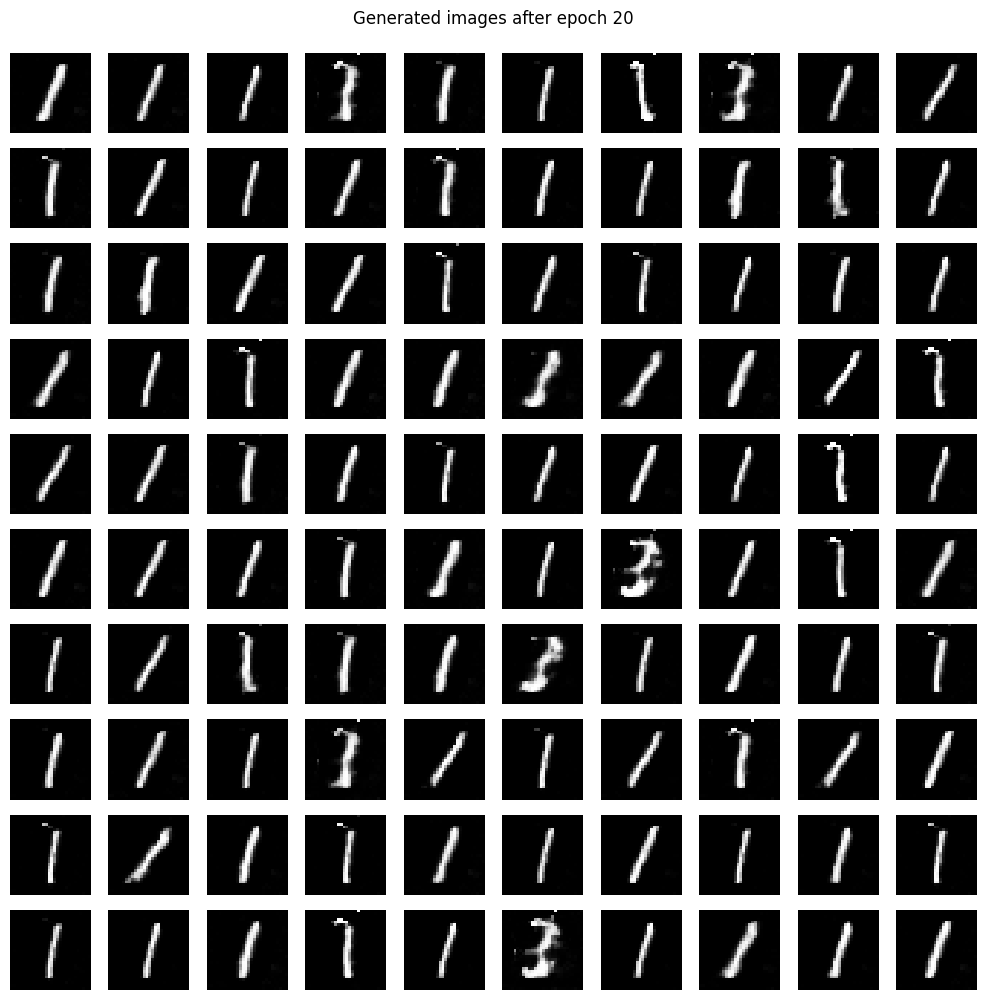


Epoch 21/50
Batch 400, D Loss: 0.6811, G Loss: 2.2546
Epoch 22/50
Batch 400, D Loss: 0.5763, G Loss: 2.5274
Epoch 23/50
Batch 400, D Loss: 0.5628, G Loss: 2.8282
Epoch 24/50
Batch 400, D Loss: 0.6256, G Loss: 2.6871
Epoch 25/50
Batch 400, D Loss: 0.6593, G Loss: 2.2886
Epoch 26/50
Batch 400, D Loss: 0.5335, G Loss: 2.5468
Epoch 27/50
Batch 400, D Loss: 0.5561, G Loss: 2.9146
Epoch 28/50
Batch 400, D Loss: 0.6438, G Loss: 2.1909
Epoch 29/50
Batch 400, D Loss: 0.6867, G Loss: 2.3384
Epoch 30/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


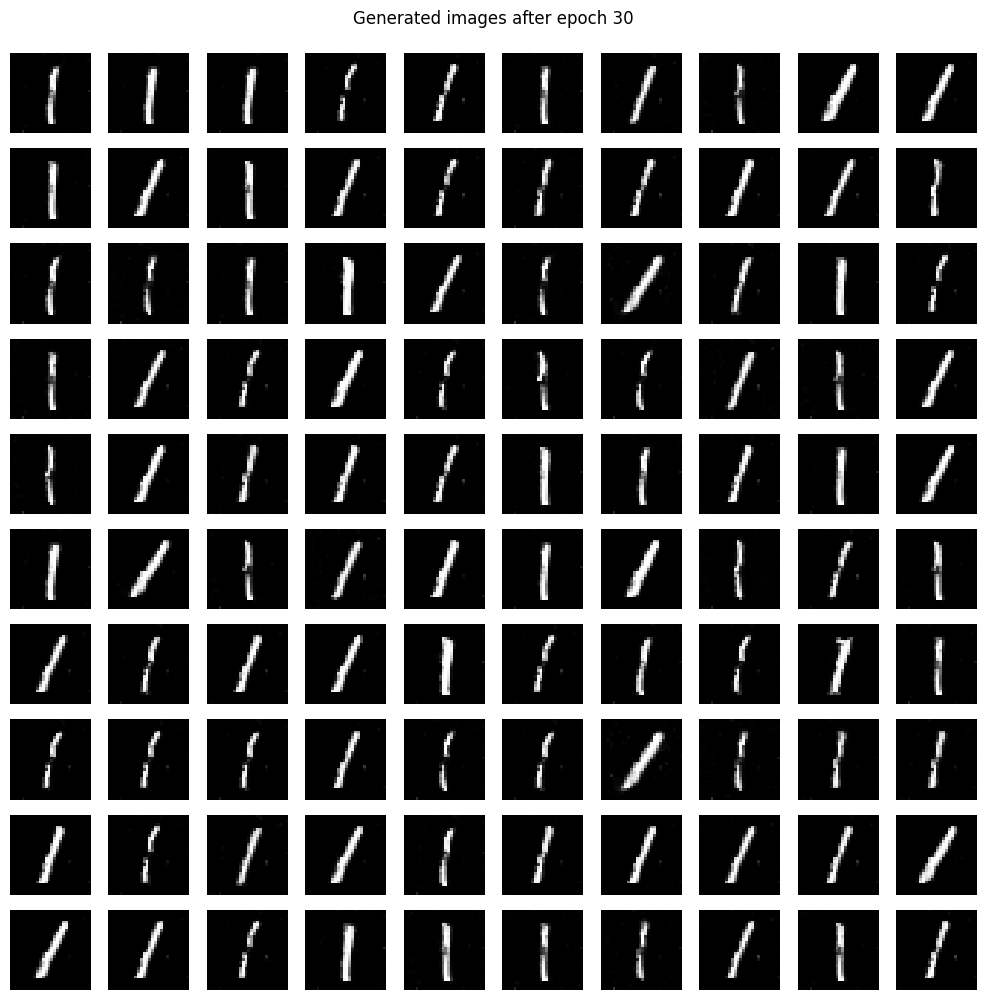


Epoch 31/50
Batch 400, D Loss: 0.4954, G Loss: 2.9233
Epoch 32/50
Batch 400, D Loss: 0.6414, G Loss: 2.5038
Epoch 33/50
Batch 400, D Loss: 0.5240, G Loss: 2.5870
Epoch 34/50
Batch 400, D Loss: 0.5785, G Loss: 2.6342
Epoch 35/50
Batch 400, D Loss: 0.5493, G Loss: 2.7991
Epoch 36/50
Batch 400, D Loss: 0.6067, G Loss: 2.5078
Epoch 37/50
Batch 400, D Loss: 0.6113, G Loss: 2.6607
Epoch 38/50
Batch 400, D Loss: 0.6437, G Loss: 2.4122
Epoch 39/50
Batch 400, D Loss: 0.5475, G Loss: 2.7275
Epoch 40/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


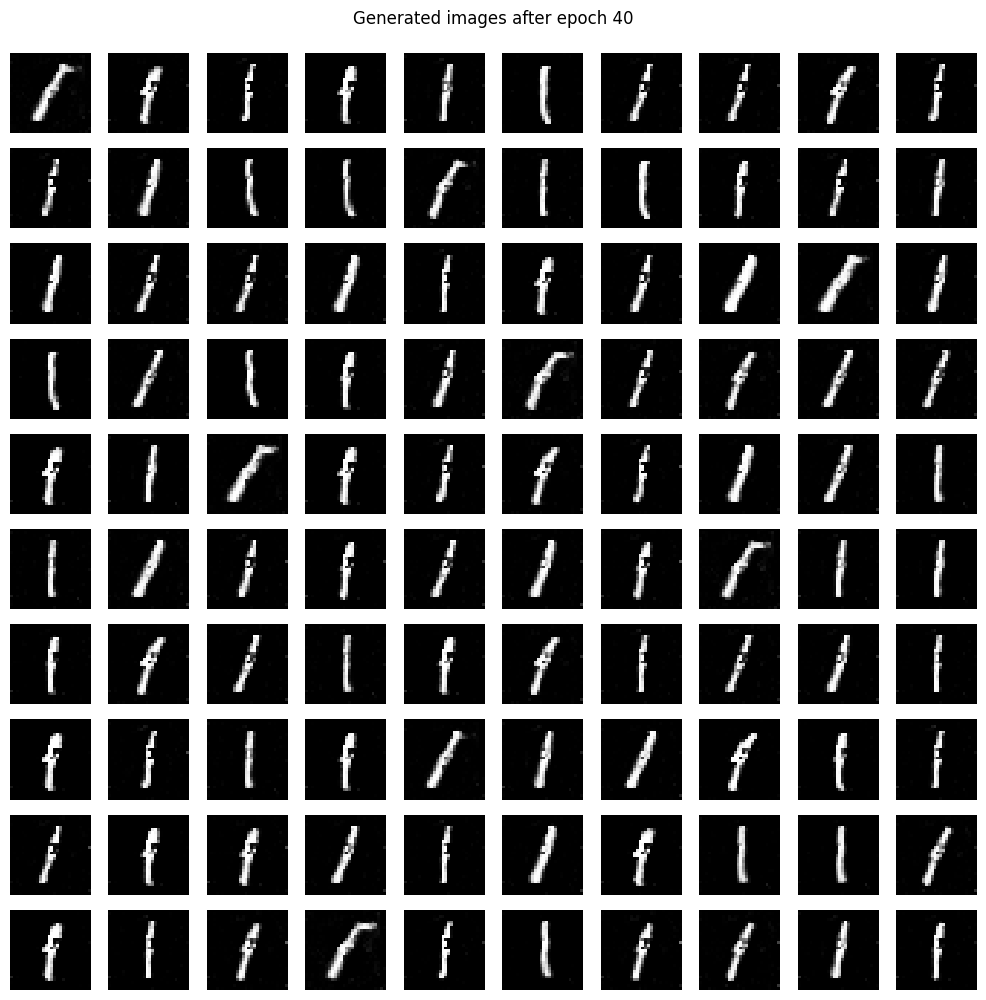


Epoch 41/50
Batch 400, D Loss: 0.5884, G Loss: 3.0365
Epoch 42/50
Batch 400, D Loss: 0.5458, G Loss: 2.7921
Epoch 43/50
Batch 400, D Loss: 0.5283, G Loss: 2.5409
Epoch 44/50
Batch 400, D Loss: 0.6374, G Loss: 2.7488
Epoch 45/50
Batch 400, D Loss: 0.4960, G Loss: 2.6980
Epoch 46/50
Batch 400, D Loss: 0.6225, G Loss: 2.4644
Epoch 47/50
Batch 400, D Loss: 0.7222, G Loss: 2.0964
Epoch 48/50
Batch 400, D Loss: 0.6559, G Loss: 2.1347
Epoch 49/50
Batch 400, D Loss: 0.6352, G Loss: 2.0853
Epoch 50/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


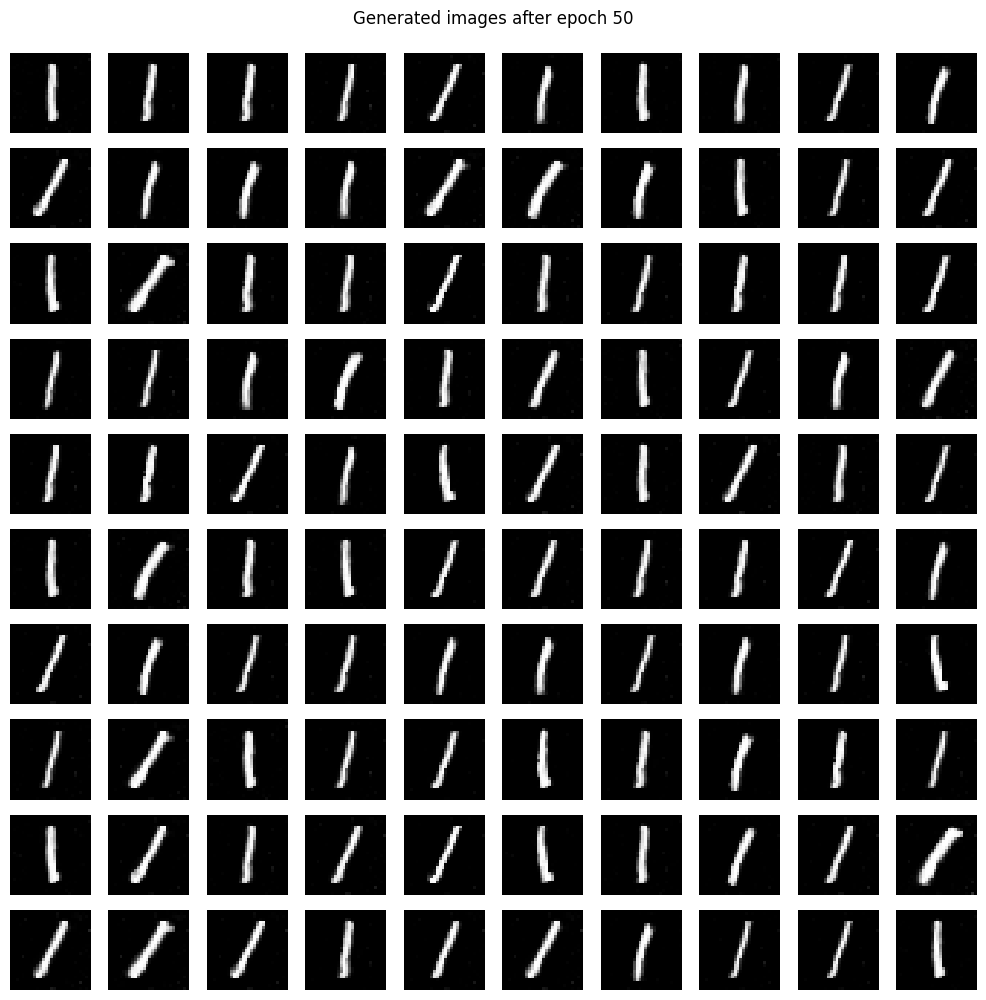

In [196]:
train(epochs=50, batch_size=128)

Again mode collapse issue with changing the distribution via multiplied by 2 version

In [197]:
class GAN:
    def __init__(self):
        # Initialize models
        self.generator = create_generator()
        self.discriminator = create_discriminator_part1_conv2()
        learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.0002,
        decay_steps=10000,
        decay_rate=0.9,
        staircase=True)
        # Initialize optimizers with mixed precision
        self.g_optimizer = Adam(learning_rate=learning_rate, beta_1=0.5)
        self.d_optimizer = Adam(learning_rate=learning_rate, beta_1=0.5)

        # Loss function
        self.loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    @tf.function(reduce_retracing=True)
    def train_discriminator(self, real_images, batch_size):
        real_images = tf.cast(real_images, tf.float16)
        noise = tf.random.normal([batch_size, 100], mean=0.0, stddev=1.0)

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Get predictions
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            # Create labels
            real_labels = tf.ones_like(real_output)* 0.9
            fake_labels = tf.zeros_like(fake_output)

            # Calculate losses
            real_loss = self.loss_fn(real_labels, real_output)
            fake_loss = self.loss_fn(fake_labels, fake_output)
            total_loss = real_loss + fake_loss

        # Calculate gradients
        gradients = tape.gradient(total_loss, self.discriminator.trainable_variables)

        # Apply gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))

        return total_loss

    @tf.function(reduce_retracing=True)
    def train_generator(self, batch_size):
        noise = tf.random.normal([batch_size, 100], mean=0.0, stddev=1.0)

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Get predictions
            fake_output = self.discriminator(generated_images, training=False)

            # Calculate loss
            labels = tf.ones_like(fake_output)
            loss = self.loss_fn(labels, fake_output)

        # Calculate gradients
        gradients = tape.gradient(loss, self.generator.trainable_variables)

        # Apply gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        return loss



def train(epochs=50, batch_size=128):
    # Load and prepare data
    x_train, _, _, _ = load_data()
    dataset_size = x_train.shape[0]

    # Create dataset with fixed shapes and types
    dataset = tf.data.Dataset.from_tensor_slices(x_train) \
        .shuffle(dataset_size) \
        .batch(batch_size, drop_remainder=True) \
        .prefetch(tf.data.AUTOTUNE)

    # Initialize GAN
    gan = GAN()

    # Training loop
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        for batch_idx, real_images in enumerate(dataset):
            d_loss = gan.train_discriminator(real_images, batch_size)
            g_loss = gan.train_generator(batch_size)

            if batch_idx % 100 == 0:
                print(f"\rBatch {batch_idx}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}", end="")

        # Generate and save images every 10 epochs
        if (epoch + 1) % 10 == 0:
            plot_generated_images(epoch + 1, gan.generator)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1/50
Batch 400, D Loss: 0.8015, G Loss: 2.7775
Epoch 2/50
Batch 400, D Loss: 0.4668, G Loss: 3.5771
Epoch 3/50
Batch 400, D Loss: 0.5409, G Loss: 3.5540
Epoch 4/50
Batch 400, D Loss: 0.5332, G Loss: 3.0612
Epoch 5/50
Batch 400, D Loss: 0.4824, G Loss: 3.8844
Epoch 6/50
Batch 400, D Loss: 0.4450, G Loss: 4.2198
Epoch 7/50
Batch 400, D Loss: 0.4603, G Loss: 4.2183
Epoch 8/50
Batch 400, D Loss: 0.5977, G Loss: 3.5112
Epoch 9/50
Batch 400, D Loss: 0.6315, G Loss: 2.7998
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step


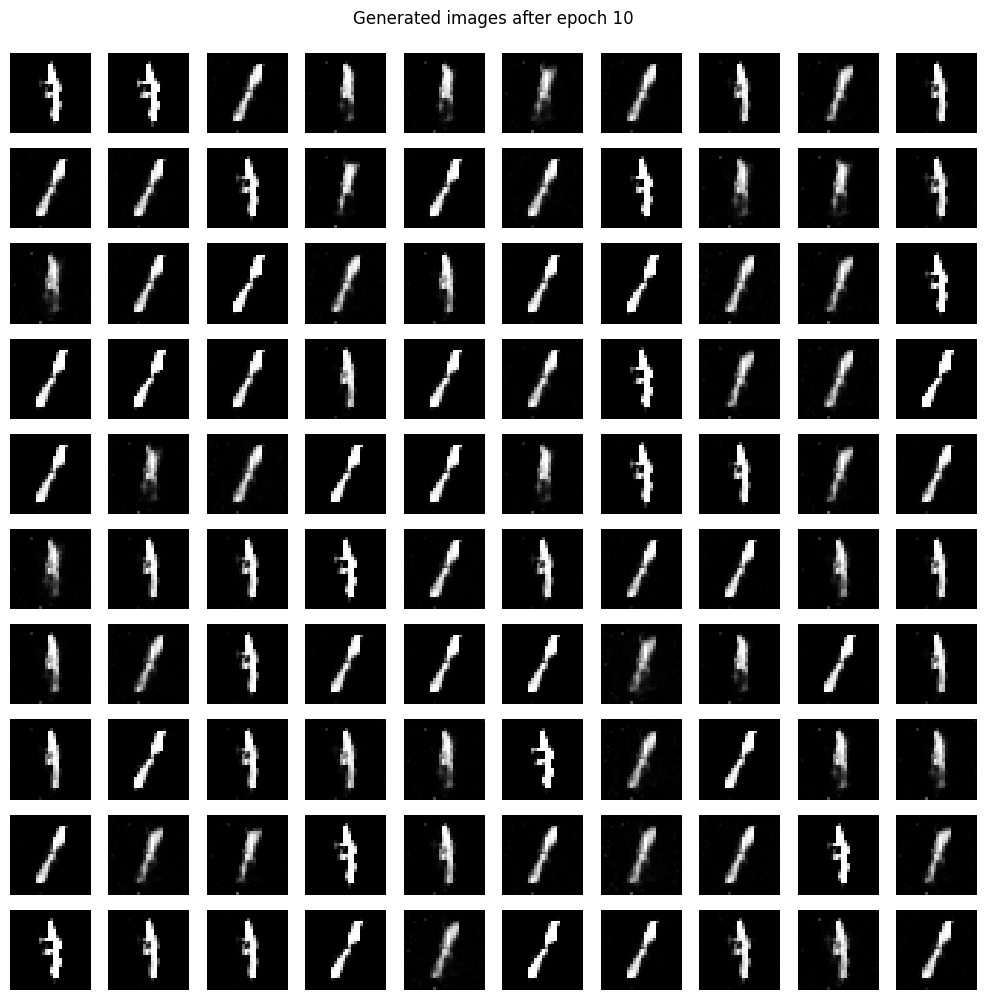


Epoch 11/50
Batch 400, D Loss: 0.5715, G Loss: 3.1436
Epoch 12/50
Batch 400, D Loss: 0.4874, G Loss: 3.4214
Epoch 13/50
Batch 400, D Loss: 0.5415, G Loss: 3.5095
Epoch 14/50
Batch 400, D Loss: 0.6278, G Loss: 2.9273
Epoch 15/50
Batch 400, D Loss: 0.5224, G Loss: 3.9716
Epoch 16/50
Batch 400, D Loss: 0.4905, G Loss: 4.1613
Epoch 17/50
Batch 400, D Loss: 0.4400, G Loss: 3.7821
Epoch 18/50
Batch 400, D Loss: 0.4955, G Loss: 3.4367
Epoch 19/50
Batch 400, D Loss: 0.7054, G Loss: 2.6376
Epoch 20/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


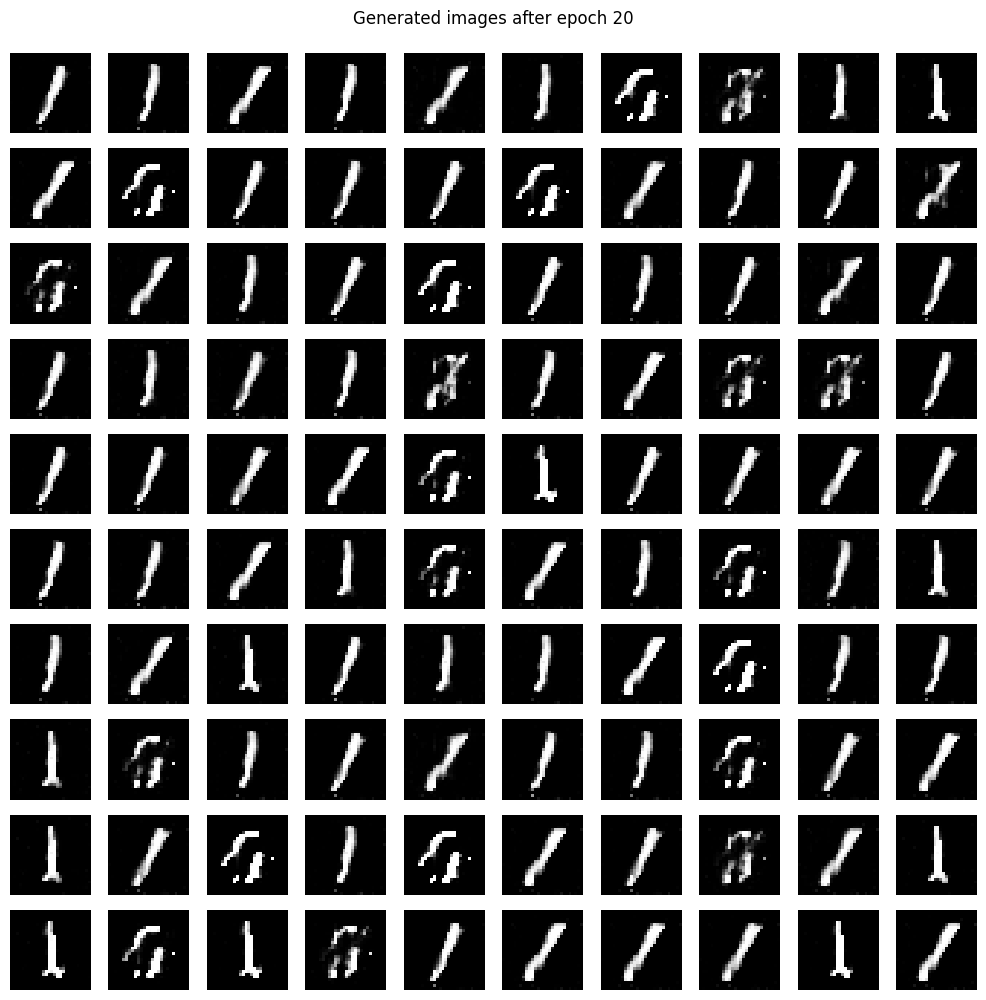


Epoch 21/50
Batch 300, D Loss: 0.5433, G Loss: 3.1817

KeyboardInterrupt: 

In [198]:
train(epochs=50, batch_size=128)

mode collapse again

I dropped the learning rate for discriminator

In [199]:
class GAN:
    def __init__(self):
        # Initialize models
        self.generator = create_generator()
        self.discriminator = create_discriminator_part1_conv2()
        learning_rate_1 = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.0002,
        decay_steps=10000,
        decay_rate=0.9,
        staircase=True)
        learning_rate_2 = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.0001,
        decay_steps=10000,
        decay_rate=0.9,
        staircase=True)
        # Initialize optimizers with mixed precision
        self.g_optimizer = Adam(learning_rate=learning_rate_1, beta_1=0.5)
        self.d_optimizer = Adam(learning_rate=learning_rate_2, beta_1=0.5)

        # Loss function
        self.loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    @tf.function(reduce_retracing=True)
    def train_discriminator(self, real_images, batch_size):
        real_images = tf.cast(real_images, tf.float16)
        noise = tf.random.normal([batch_size, 100], dtype=tf.float16)

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Get predictions
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            # Create labels
            real_labels = tf.ones_like(real_output)* 0.9
            fake_labels = tf.zeros_like(fake_output)

            # Calculate losses
            real_loss = self.loss_fn(real_labels, real_output)
            fake_loss = self.loss_fn(fake_labels, fake_output)
            total_loss = real_loss + fake_loss

        # Calculate gradients
        gradients = tape.gradient(total_loss, self.discriminator.trainable_variables)

        # Apply gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))

        return total_loss

    @tf.function(reduce_retracing=True)
    def train_generator(self, batch_size):
        noise = tf.random.normal([batch_size, 100], dtype=tf.float16)

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Get predictions
            fake_output = self.discriminator(generated_images, training=False)

            # Calculate loss
            labels = tf.ones_like(fake_output)
            loss = self.loss_fn(labels, fake_output)

        # Calculate gradients
        gradients = tape.gradient(loss, self.generator.trainable_variables)

        # Apply gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        return loss



def train(epochs=50, batch_size=128):
    # Load and prepare data
    x_train, _, _, _ = load_data()
    dataset_size = x_train.shape[0]

    # Create dataset with fixed shapes and types
    dataset = tf.data.Dataset.from_tensor_slices(x_train) \
        .shuffle(dataset_size) \
        .batch(batch_size, drop_remainder=True) \
        .prefetch(tf.data.AUTOTUNE)

    # Initialize GAN
    gan = GAN()

    # Training loop
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        for batch_idx, real_images in enumerate(dataset):
            d_loss = gan.train_discriminator(real_images, batch_size)
            g_loss = gan.train_generator(batch_size)

            if batch_idx % 100 == 0:
                print(f"\rBatch {batch_idx}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}", end="")

        # Generate and save images every 10 epochs
        if (epoch + 1) % 10 == 0:
            plot_generated_images(epoch + 1, gan.generator)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1/50
Batch 400, D Loss: 0.7869, G Loss: 2.3551
Epoch 2/50
Batch 400, D Loss: 0.7112, G Loss: 2.7980
Epoch 3/50
Batch 400, D Loss: 0.5095, G Loss: 3.3329
Epoch 4/50
Batch 400, D Loss: 0.6435, G Loss: 2.7145
Epoch 5/50
Batch 400, D Loss: 0.7614, G Loss: 2.3735
Epoch 6/50
Batch 400, D Loss: 0.5122, G Loss: 3.2890
Epoch 7/50
Batch 400, D Loss: 0.5098, G Loss: 3.8230
Epoch 8/50
Batch 400, D Loss: 0.6059, G Loss: 2.9801
Epoch 9/50
Batch 400, D Loss: 0.5244, G Loss: 3.2699
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step


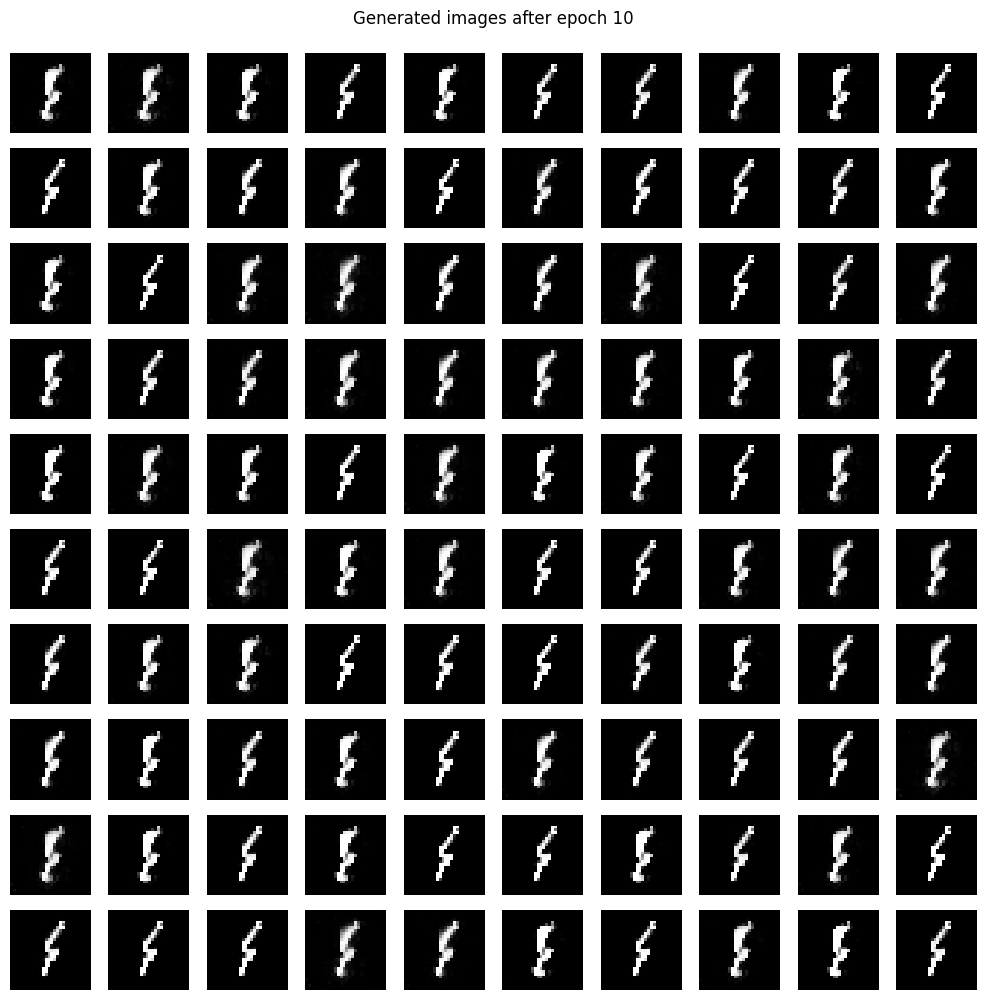


Epoch 11/50
Batch 400, D Loss: 0.5773, G Loss: 3.1184
Epoch 12/50
Batch 400, D Loss: 0.5355, G Loss: 2.9096
Epoch 13/50
Batch 400, D Loss: 0.5443, G Loss: 2.8522
Epoch 14/50
Batch 400, D Loss: 0.5049, G Loss: 3.5089
Epoch 15/50
Batch 400, D Loss: 0.5386, G Loss: 3.2946
Epoch 16/50
Batch 400, D Loss: 0.5212, G Loss: 3.1953
Epoch 17/50
Batch 400, D Loss: 0.5194, G Loss: 2.5734
Epoch 18/50
Batch 400, D Loss: 0.5660, G Loss: 3.1896
Epoch 19/50
Batch 400, D Loss: 0.6359, G Loss: 2.7452
Epoch 20/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


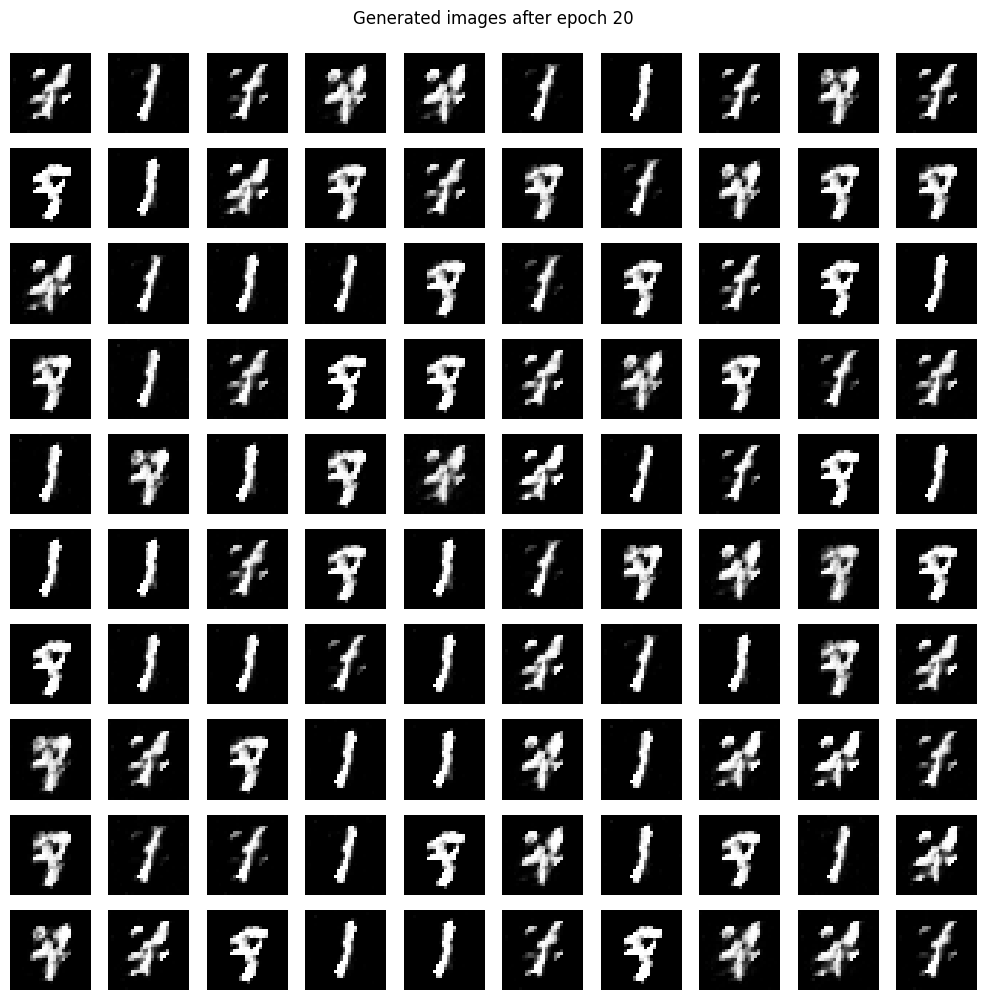


Epoch 21/50
Batch 400, D Loss: 0.6666, G Loss: 3.1055
Epoch 22/50
Batch 0, D Loss: 0.6884, G Loss: 2.5628

KeyboardInterrupt: 

In [200]:
train(epochs=50, batch_size=128)

In [221]:
def create_discriminator_part1_conv2_dropout():
    discriminator = Sequential()
    discriminator.add(Reshape((28, 28, 1), input_shape=(784,)))

    discriminator.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    discriminator.add(layers.LeakyReLU(0.2))
    discriminator.add(layers.Dropout(0.2))

    discriminator.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    discriminator.add(layers.LeakyReLU(0.2))
    discriminator.add(layers.Dropout(0.2))

    discriminator.add(layers.Flatten())

    discriminator.add(layers.Dense(256))
    discriminator.add(layers.LeakyReLU(0.2))

    discriminator.add(layers.Dense(1, activation='sigmoid'))  # Output layer to predict real/fake

    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer(), metrics=['accuracy'])
    return discriminator

In [222]:
class GAN:
    def __init__(self):
        # Initialize models
        self.generator = create_generator()
        self.discriminator = create_discriminator_part1_conv2_dropout()
        learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.0002,
        decay_steps=10000,
        decay_rate=0.9,
        staircase=True)
        # Initialize optimizers with mixed precision
        self.g_optimizer = Adam(learning_rate=learning_rate, beta_1=0.5)
        self.d_optimizer = Adam(learning_rate=learning_rate, beta_1=0.5)

        # Loss function
        self.loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    @tf.function(reduce_retracing=True)
    def train_discriminator(self, real_images, batch_size):
        real_images = tf.cast(real_images, tf.float16)
        noise = tf.random.normal([batch_size, 100], dtype=tf.float16)

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Get predictions
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            # Create labels
            real_labels = tf.ones_like(real_output)* 0.9
            fake_labels = tf.zeros_like(fake_output)

            # Calculate losses
            real_loss = self.loss_fn(real_labels, real_output)
            fake_loss = self.loss_fn(fake_labels, fake_output)
            total_loss = real_loss + fake_loss

        # Calculate gradients
        gradients = tape.gradient(total_loss, self.discriminator.trainable_variables)

        # Apply gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))

        return total_loss

    @tf.function(reduce_retracing=True)
    def train_generator(self, batch_size):
        noise = tf.random.normal([batch_size, 100], dtype=tf.float16)

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Get predictions
            fake_output = self.discriminator(generated_images, training=False)

            # Calculate loss
            labels = tf.ones_like(fake_output)
            loss = self.loss_fn(labels, fake_output)

        # Calculate gradients
        gradients = tape.gradient(loss, self.generator.trainable_variables)

        # Apply gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        return loss



def train(epochs=50, batch_size=128):
    # Load and prepare data
    x_train, _, _, _ = load_data()
    dataset_size = x_train.shape[0]

    # Create dataset with fixed shapes and types
    dataset = tf.data.Dataset.from_tensor_slices(x_train) \
        .shuffle(dataset_size) \
        .batch(batch_size, drop_remainder=True) \
        .prefetch(tf.data.AUTOTUNE)

    # Initialize GAN
    gan = GAN()

    # Training loop
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        for batch_idx, real_images in enumerate(dataset):
            d_loss = gan.train_discriminator(real_images, batch_size)
            g_loss = gan.train_generator(batch_size)

            if batch_idx % 100 == 0:
                print(f"\rBatch {batch_idx}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}", end="")

        # Generate and save images every 10 epochs
        if (epoch + 1) % 10 == 0:
            plot_generated_images(epoch + 1, gan.generator)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1/50
Batch 400, D Loss: 0.6913, G Loss: 2.8168
Epoch 2/50
Batch 400, D Loss: 0.5499, G Loss: 3.1146
Epoch 3/50
Batch 400, D Loss: 0.5224, G Loss: 3.5508
Epoch 4/50
Batch 400, D Loss: 0.4305, G Loss: 4.4926
Epoch 5/50
Batch 400, D Loss: 0.3952, G Loss: 4.7654
Epoch 6/50
Batch 400, D Loss: 0.4447, G Loss: 3.8229
Epoch 7/50
Batch 400, D Loss: 0.5037, G Loss: 3.6497
Epoch 8/50
Batch 400, D Loss: 0.4905, G Loss: 3.7319
Epoch 9/50
Batch 400, D Loss: 0.6045, G Loss: 3.9274
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step


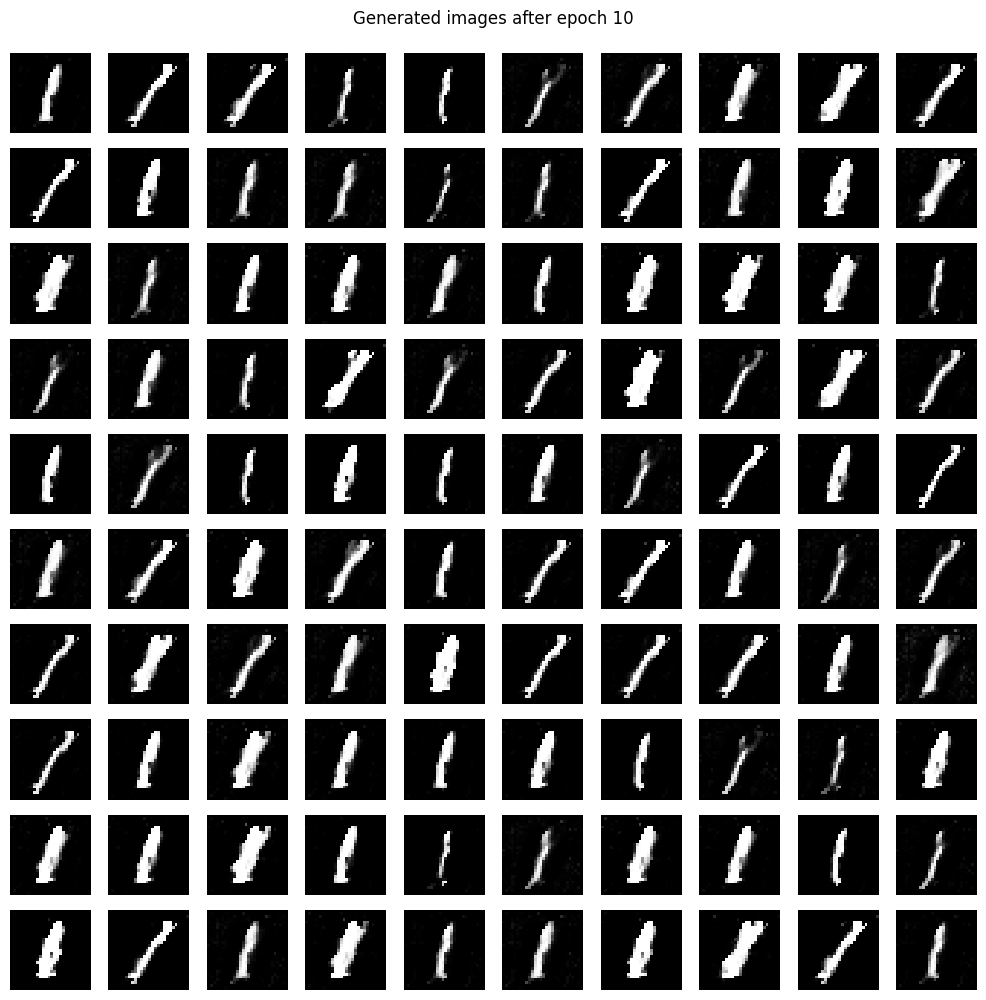


Epoch 11/50
Batch 400, D Loss: 0.6366, G Loss: 3.2084
Epoch 12/50
Batch 400, D Loss: 0.5786, G Loss: 3.2334
Epoch 13/50
Batch 400, D Loss: 0.6593, G Loss: 2.5601
Epoch 14/50
Batch 400, D Loss: 0.6671, G Loss: 2.6088
Epoch 15/50
Batch 400, D Loss: 0.6373, G Loss: 2.8918
Epoch 16/50
Batch 400, D Loss: 0.5659, G Loss: 3.1554
Epoch 17/50
Batch 400, D Loss: 0.6902, G Loss: 2.2983
Epoch 18/50
Batch 400, D Loss: 0.6414, G Loss: 2.4147
Epoch 19/50
Batch 400, D Loss: 0.8428, G Loss: 1.8883
Epoch 20/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


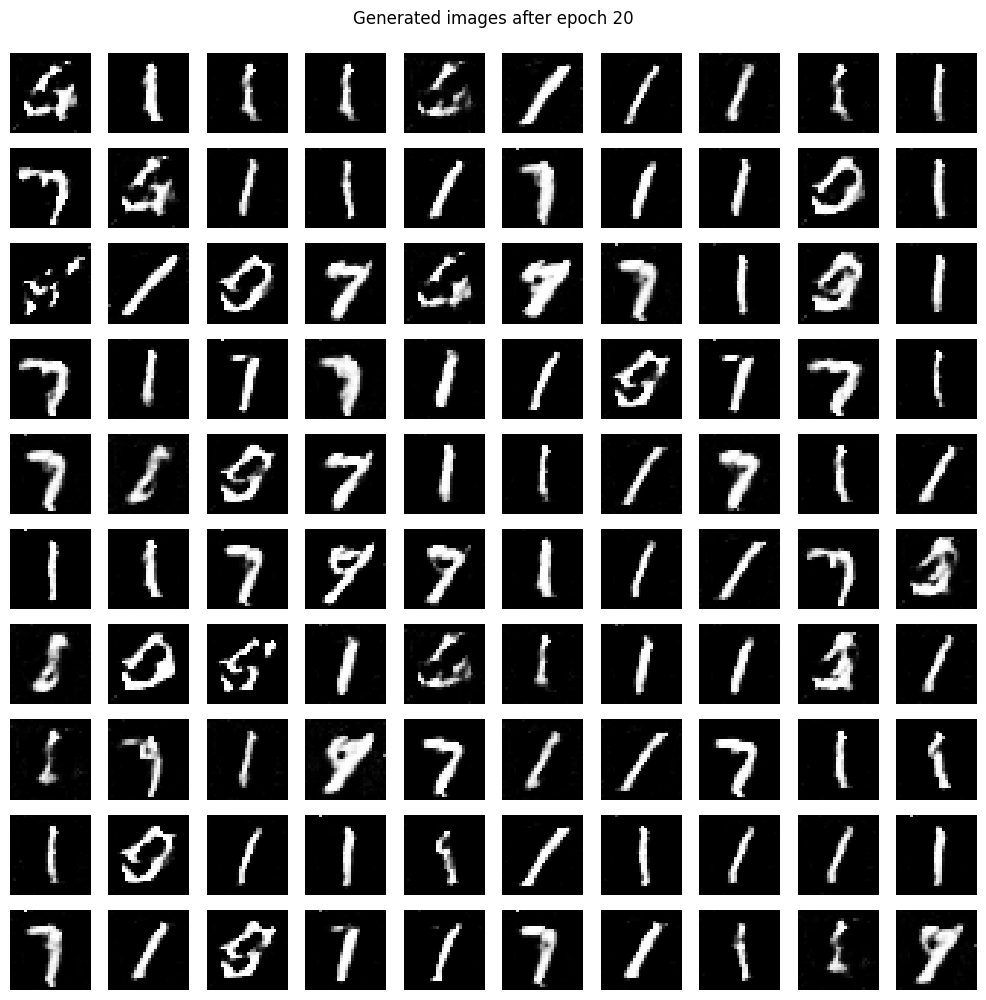


Epoch 21/50
Batch 400, D Loss: 0.7649, G Loss: 2.3331
Epoch 22/50
Batch 400, D Loss: 0.8078, G Loss: 1.8505
Epoch 23/50
Batch 400, D Loss: 0.7336, G Loss: 2.6088
Epoch 24/50
Batch 400, D Loss: 0.8134, G Loss: 2.0172
Epoch 25/50
Batch 400, D Loss: 0.6944, G Loss: 2.4889
Epoch 26/50
Batch 400, D Loss: 0.7860, G Loss: 2.2470
Epoch 27/50
Batch 400, D Loss: 0.7837, G Loss: 2.1272
Epoch 28/50
Batch 400, D Loss: 0.7601, G Loss: 2.0021
Epoch 29/50
Batch 400, D Loss: 0.8369, G Loss: 2.0056
Epoch 30/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


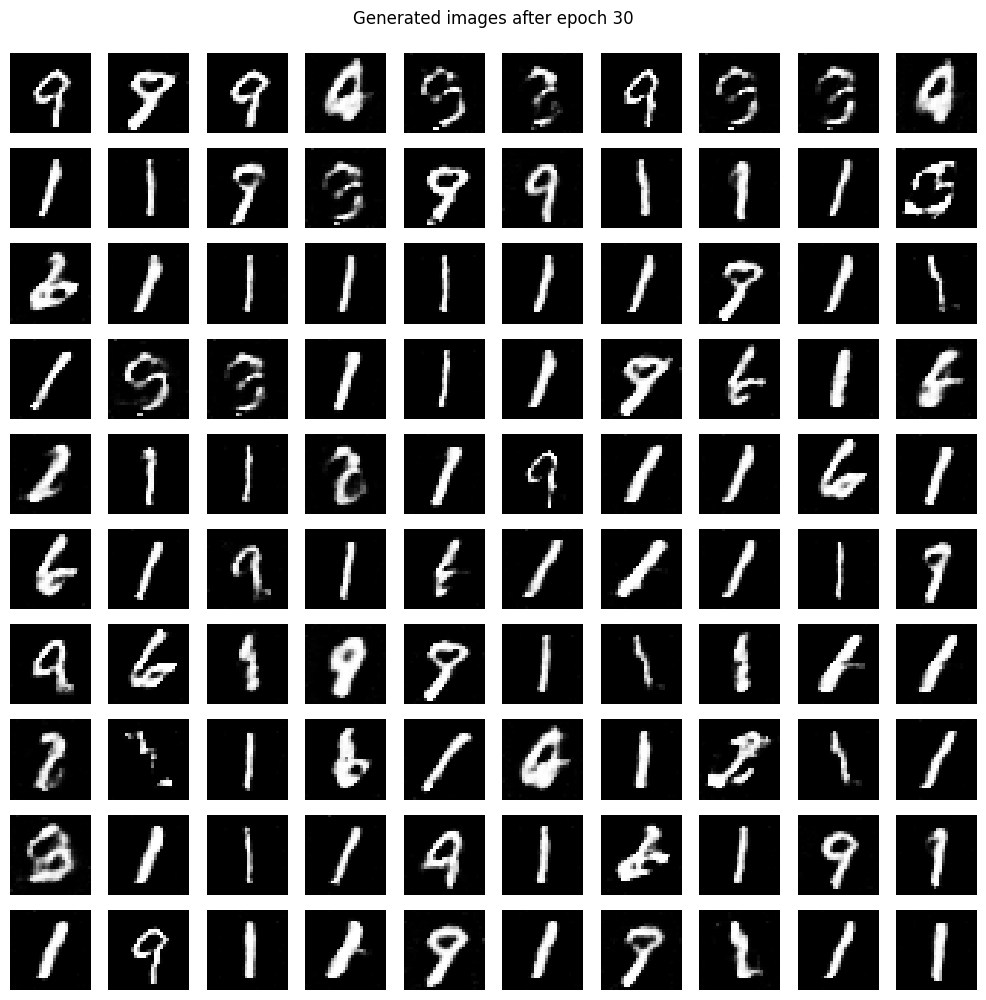


Epoch 31/50
Batch 400, D Loss: 0.7443, G Loss: 2.5894
Epoch 32/50
Batch 400, D Loss: 0.7350, G Loss: 2.3985
Epoch 33/50
Batch 400, D Loss: 0.8351, G Loss: 2.1368
Epoch 34/50
Batch 400, D Loss: 0.7741, G Loss: 2.0323
Epoch 35/50
Batch 400, D Loss: 0.7964, G Loss: 2.0665
Epoch 36/50
Batch 400, D Loss: 0.7504, G Loss: 2.5241
Epoch 37/50
Batch 400, D Loss: 0.7445, G Loss: 2.4097
Epoch 38/50
Batch 400, D Loss: 0.6765, G Loss: 2.2416
Epoch 39/50
Batch 400, D Loss: 0.7653, G Loss: 2.1802
Epoch 40/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


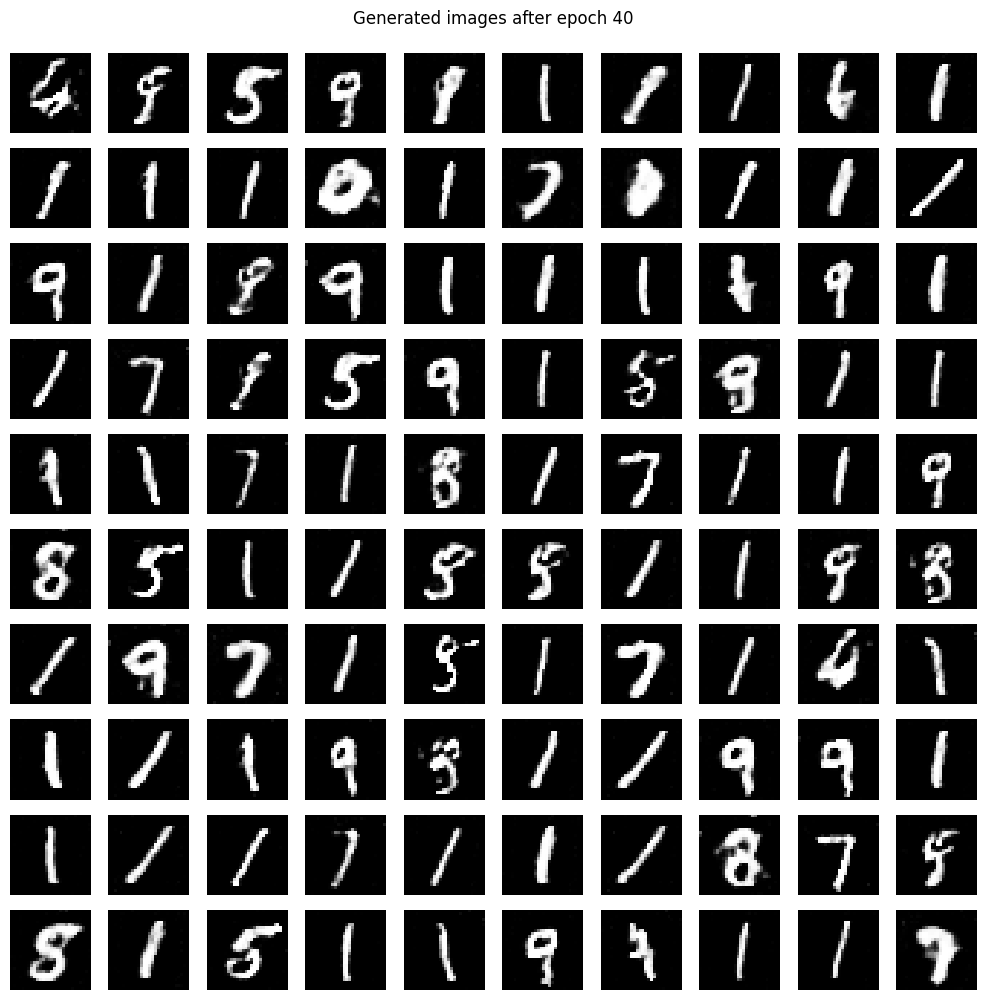


Epoch 41/50
Batch 400, D Loss: 0.8265, G Loss: 1.8810
Epoch 42/50
Batch 400, D Loss: 0.8155, G Loss: 2.1675
Epoch 43/50
Batch 400, D Loss: 0.7685, G Loss: 2.0153
Epoch 44/50
Batch 400, D Loss: 0.7084, G Loss: 2.1375
Epoch 45/50
Batch 400, D Loss: 0.7433, G Loss: 2.2250
Epoch 46/50
Batch 400, D Loss: 0.7162, G Loss: 2.3351
Epoch 47/50
Batch 400, D Loss: 0.7533, G Loss: 1.9713
Epoch 48/50
Batch 400, D Loss: 0.7318, G Loss: 2.3495
Epoch 49/50
Batch 400, D Loss: 0.8184, G Loss: 2.1155
Epoch 50/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


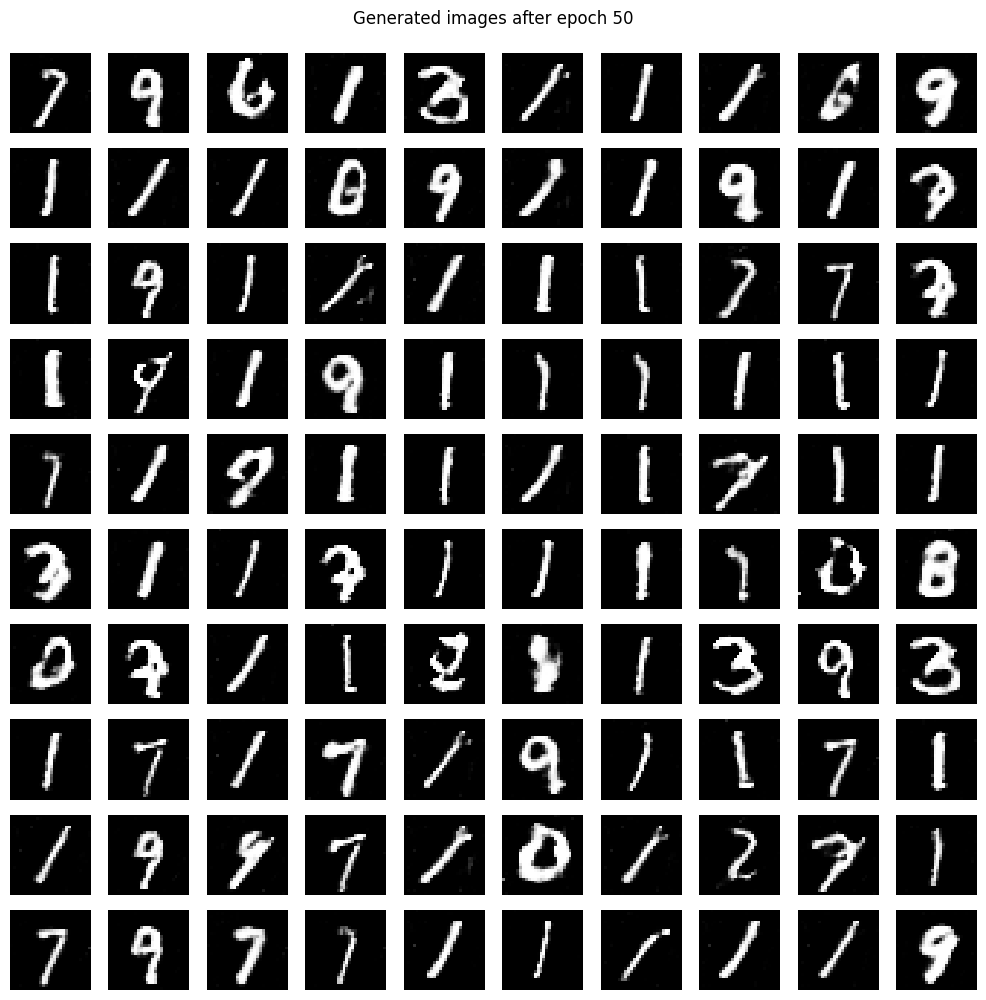

In [203]:
train(epochs=50, batch_size=128)

This model is promising so I tried with learning rate 0.0004 version

In [204]:
def adam_optimizer():
    return Adam(learning_rate=0.0004, beta_1=0.5)


Epoch 1/50
Batch 400, D Loss: 0.7278, G Loss: 2.7312
Epoch 2/50
Batch 400, D Loss: 0.4799, G Loss: 4.0430
Epoch 3/50
Batch 400, D Loss: 0.4529, G Loss: 4.0746
Epoch 4/50
Batch 400, D Loss: 0.4957, G Loss: 3.5064
Epoch 5/50
Batch 400, D Loss: 0.5504, G Loss: 3.3491
Epoch 6/50
Batch 400, D Loss: 0.4476, G Loss: 3.9940
Epoch 7/50
Batch 400, D Loss: 0.5152, G Loss: 3.9037
Epoch 8/50
Batch 400, D Loss: 0.6196, G Loss: 3.0437
Epoch 9/50
Batch 400, D Loss: 0.4268, G Loss: 4.1293
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step


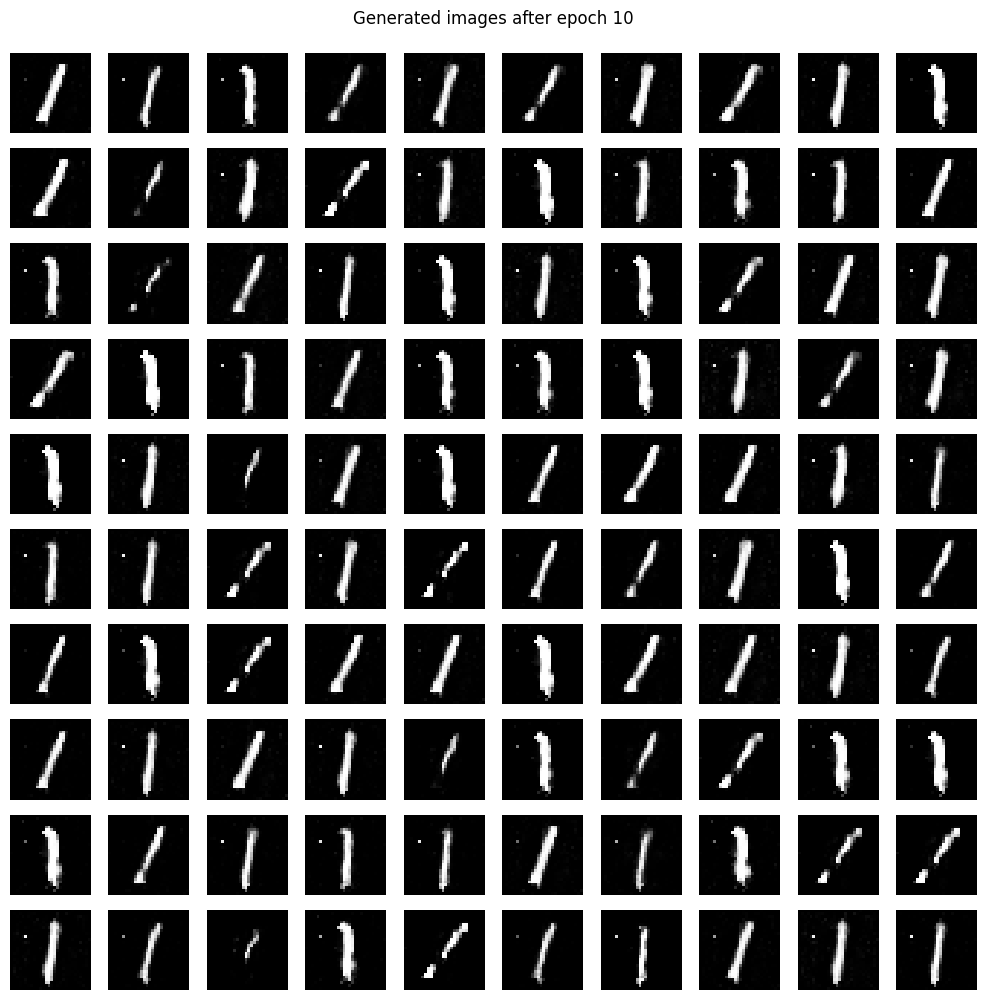


Epoch 11/50
Batch 400, D Loss: 0.5192, G Loss: 3.2898
Epoch 12/50
Batch 400, D Loss: 0.5422, G Loss: 3.4062
Epoch 13/50
Batch 400, D Loss: 0.7667, G Loss: 2.6142
Epoch 14/50
Batch 400, D Loss: 0.6360, G Loss: 2.9153
Epoch 15/50
Batch 400, D Loss: 0.5448, G Loss: 3.0234
Epoch 16/50
Batch 400, D Loss: 0.6965, G Loss: 2.4174
Epoch 17/50
Batch 400, D Loss: 0.7911, G Loss: 1.9731
Epoch 18/50
Batch 400, D Loss: 0.7677, G Loss: 2.3085
Epoch 19/50
Batch 400, D Loss: 0.8029, G Loss: 2.6130
Epoch 20/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


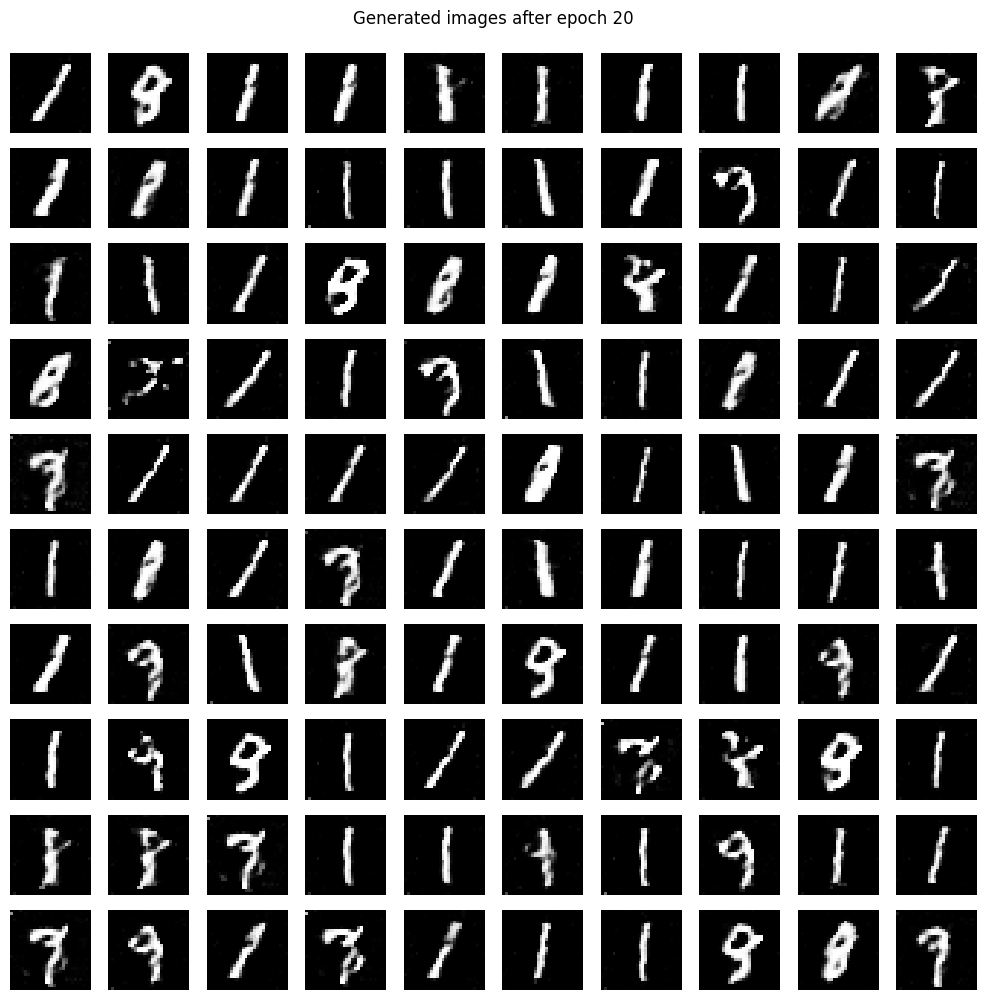


Epoch 21/50
Batch 400, D Loss: 0.7807, G Loss: 1.8858
Epoch 22/50
Batch 400, D Loss: 0.6529, G Loss: 2.2880
Epoch 23/50
Batch 400, D Loss: 0.6424, G Loss: 2.4239
Epoch 24/50
Batch 400, D Loss: 0.7447, G Loss: 2.2769
Epoch 25/50
Batch 400, D Loss: 0.6683, G Loss: 2.5849
Epoch 26/50
Batch 400, D Loss: 0.7222, G Loss: 2.1794
Epoch 27/50
Batch 400, D Loss: 0.7399, G Loss: 2.1879
Epoch 28/50
Batch 400, D Loss: 0.7461, G Loss: 2.0935
Epoch 29/50
Batch 400, D Loss: 0.8679, G Loss: 2.0833
Epoch 30/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


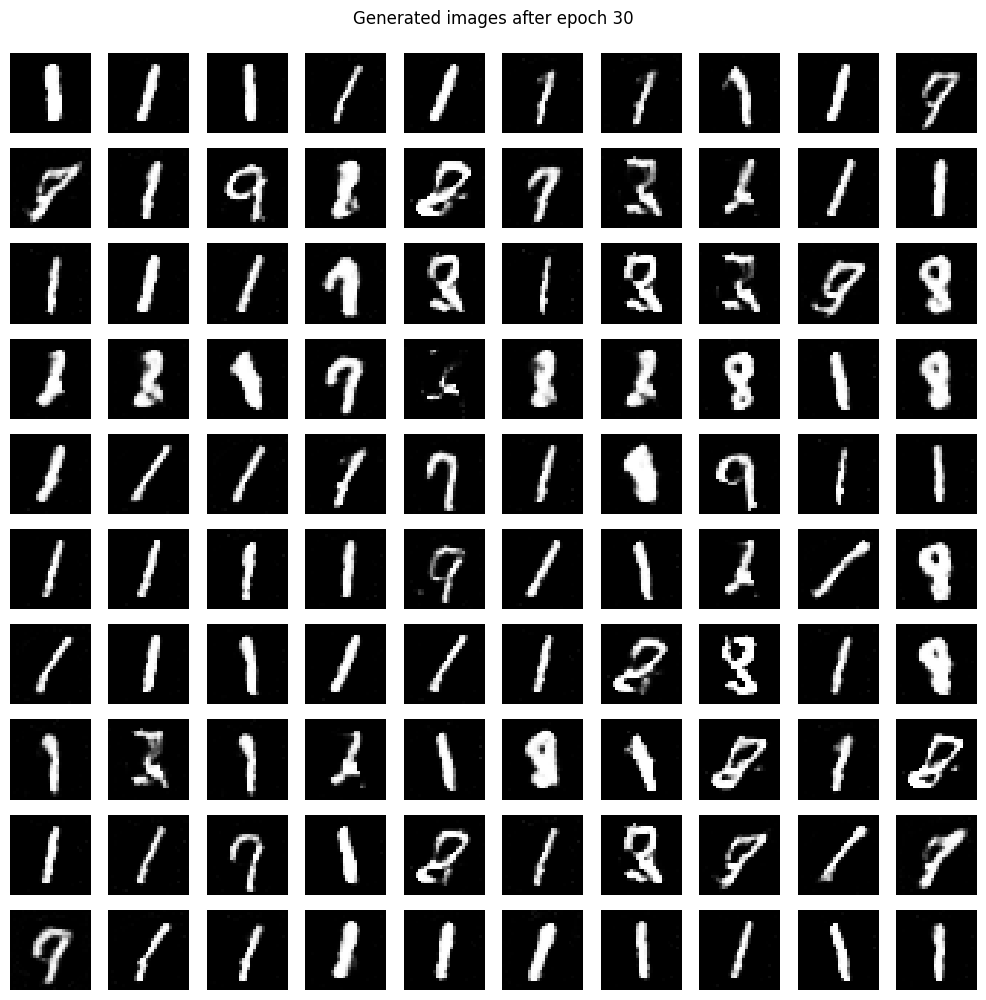


Epoch 31/50
Batch 400, D Loss: 0.6963, G Loss: 2.2489
Epoch 32/50
Batch 400, D Loss: 0.6784, G Loss: 2.4357
Epoch 33/50
Batch 400, D Loss: 0.7164, G Loss: 1.9850
Epoch 34/50
Batch 400, D Loss: 0.7254, G Loss: 1.7953
Epoch 35/50
Batch 400, D Loss: 0.7418, G Loss: 1.9348
Epoch 36/50
Batch 400, D Loss: 0.7086, G Loss: 2.4501
Epoch 37/50
Batch 400, D Loss: 0.7381, G Loss: 2.3785
Epoch 38/50
Batch 400, D Loss: 0.6945, G Loss: 2.3058
Epoch 39/50
Batch 400, D Loss: 0.8304, G Loss: 1.8231
Epoch 40/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


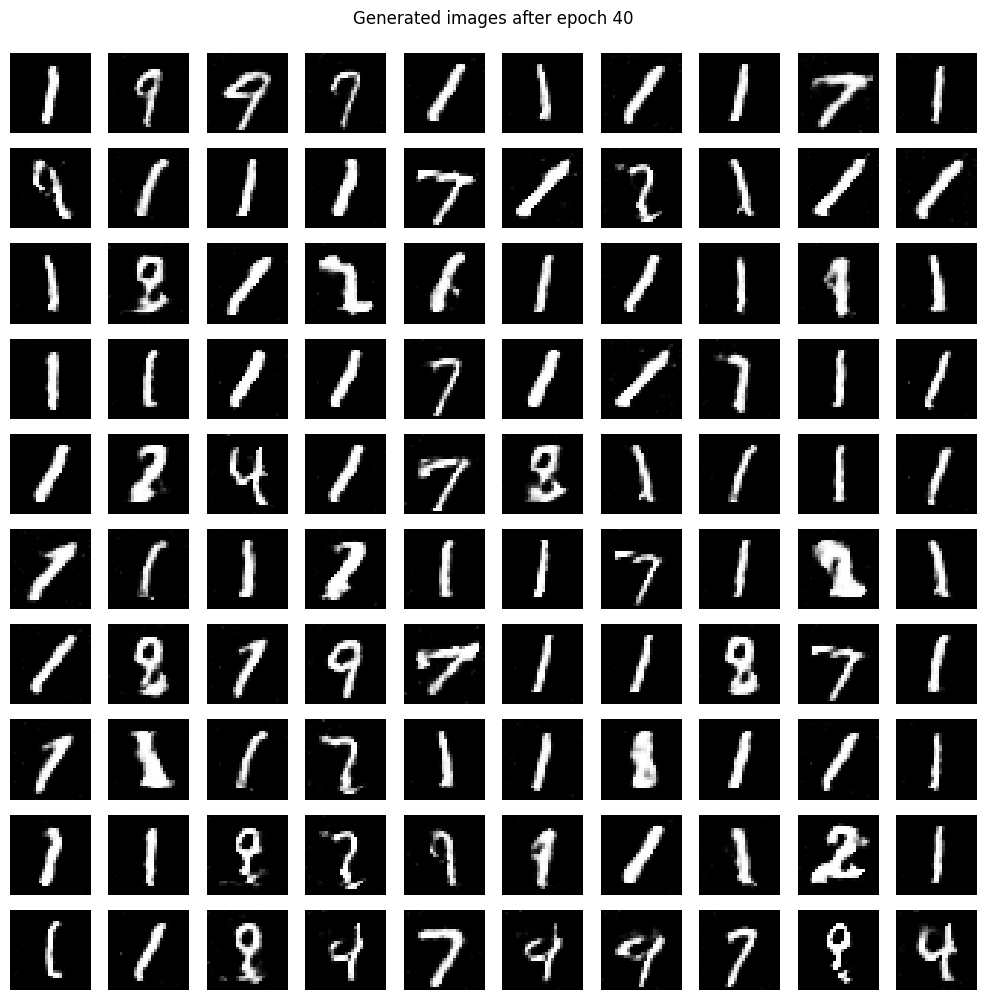


Epoch 41/50
Batch 400, D Loss: 0.7448, G Loss: 1.9334
Epoch 42/50
Batch 400, D Loss: 0.8081, G Loss: 2.1572
Epoch 43/50
Batch 400, D Loss: 0.7544, G Loss: 1.8464
Epoch 44/50
Batch 400, D Loss: 0.8673, G Loss: 1.9823
Epoch 45/50
Batch 400, D Loss: 0.8186, G Loss: 1.6257
Epoch 46/50
Batch 400, D Loss: 0.7189, G Loss: 2.4724
Epoch 47/50
Batch 400, D Loss: 0.7500, G Loss: 2.0426
Epoch 48/50
Batch 400, D Loss: 0.8114, G Loss: 1.9368
Epoch 49/50
Batch 400, D Loss: 0.7231, G Loss: 2.1890
Epoch 50/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


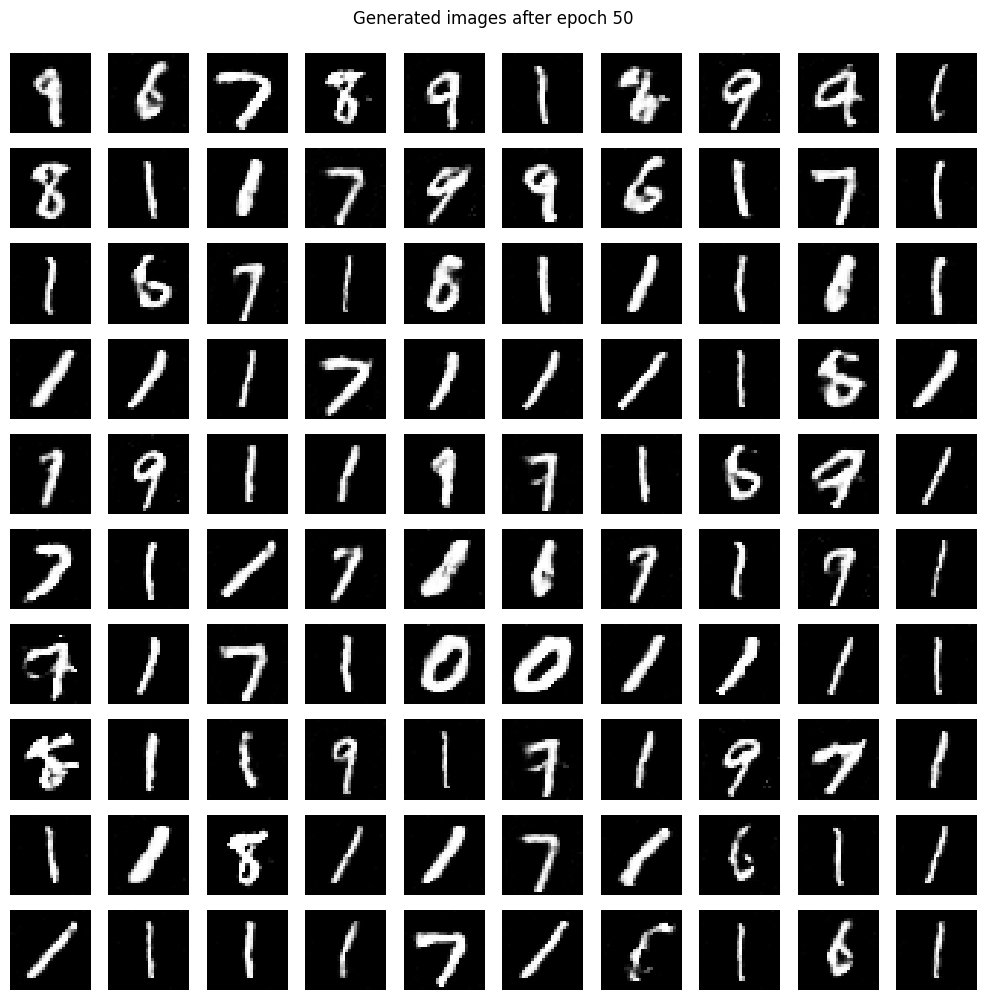

In [205]:
train(epochs=50, batch_size=128)

Train with 100 epochs

In [223]:
def adam_optimizer():
    return Adam(learning_rate=0.0005, beta_1=0.5)


Epoch 1/100
Batch 400, D Loss: 0.6244, G Loss: 3.1185
Epoch 2/100
Batch 400, D Loss: 0.7335, G Loss: 2.7844
Epoch 3/100
Batch 400, D Loss: 0.4504, G Loss: 3.9672
Epoch 4/100
Batch 400, D Loss: 0.5574, G Loss: 4.7141
Epoch 5/100
Batch 400, D Loss: 0.4141, G Loss: 4.6214
Epoch 6/100
Batch 400, D Loss: 0.4707, G Loss: 3.9706
Epoch 7/100
Batch 400, D Loss: 0.5055, G Loss: 3.7812
Epoch 8/100
Batch 400, D Loss: 0.5244, G Loss: 2.9335
Epoch 9/100
Batch 400, D Loss: 0.4463, G Loss: 4.2040
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step


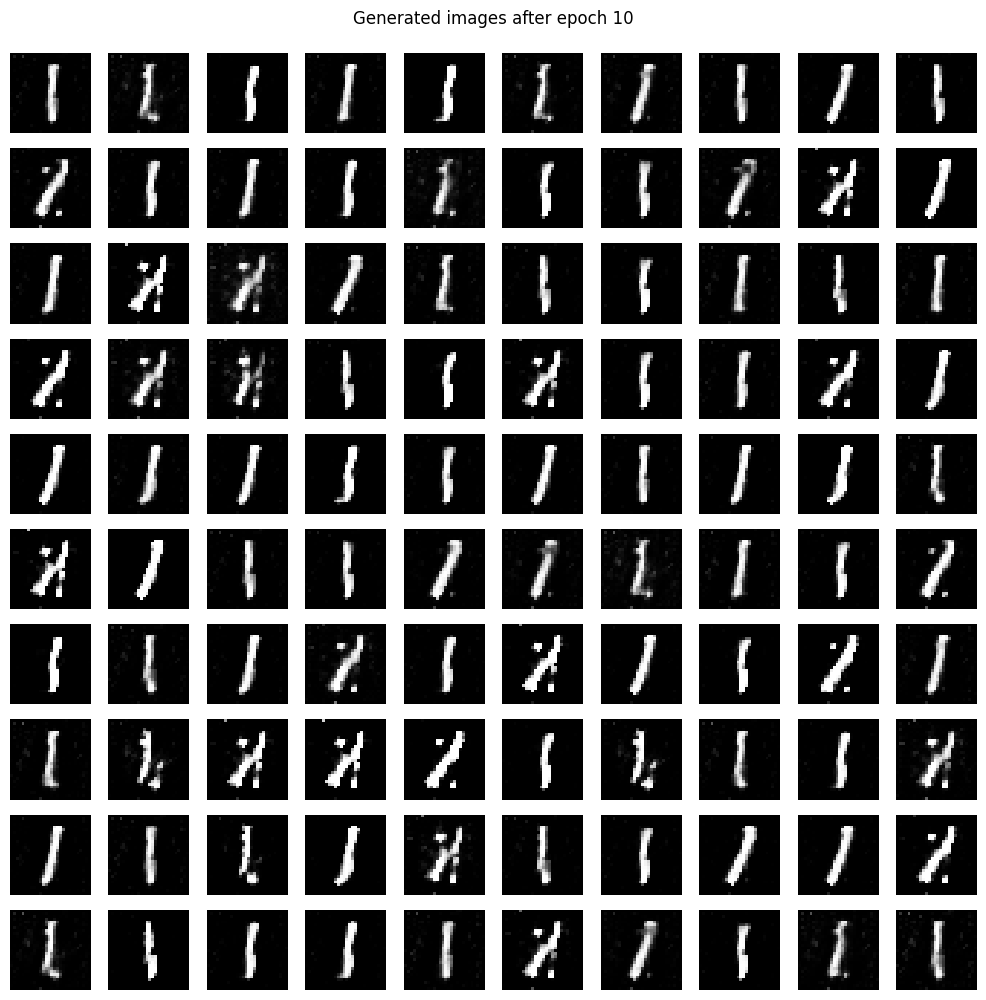


Epoch 11/100
Batch 400, D Loss: 0.6794, G Loss: 3.4141
Epoch 12/100
Batch 400, D Loss: 0.7372, G Loss: 2.2618
Epoch 13/100
Batch 400, D Loss: 0.6355, G Loss: 2.6204
Epoch 14/100
Batch 400, D Loss: 0.6847, G Loss: 2.5173
Epoch 15/100
Batch 400, D Loss: 0.7060, G Loss: 2.2645
Epoch 16/100
Batch 400, D Loss: 0.7408, G Loss: 2.0978
Epoch 17/100
Batch 400, D Loss: 0.6501, G Loss: 2.3128
Epoch 18/100
Batch 400, D Loss: 0.7895, G Loss: 1.8650
Epoch 19/100
Batch 400, D Loss: 0.6110, G Loss: 2.7898
Epoch 20/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


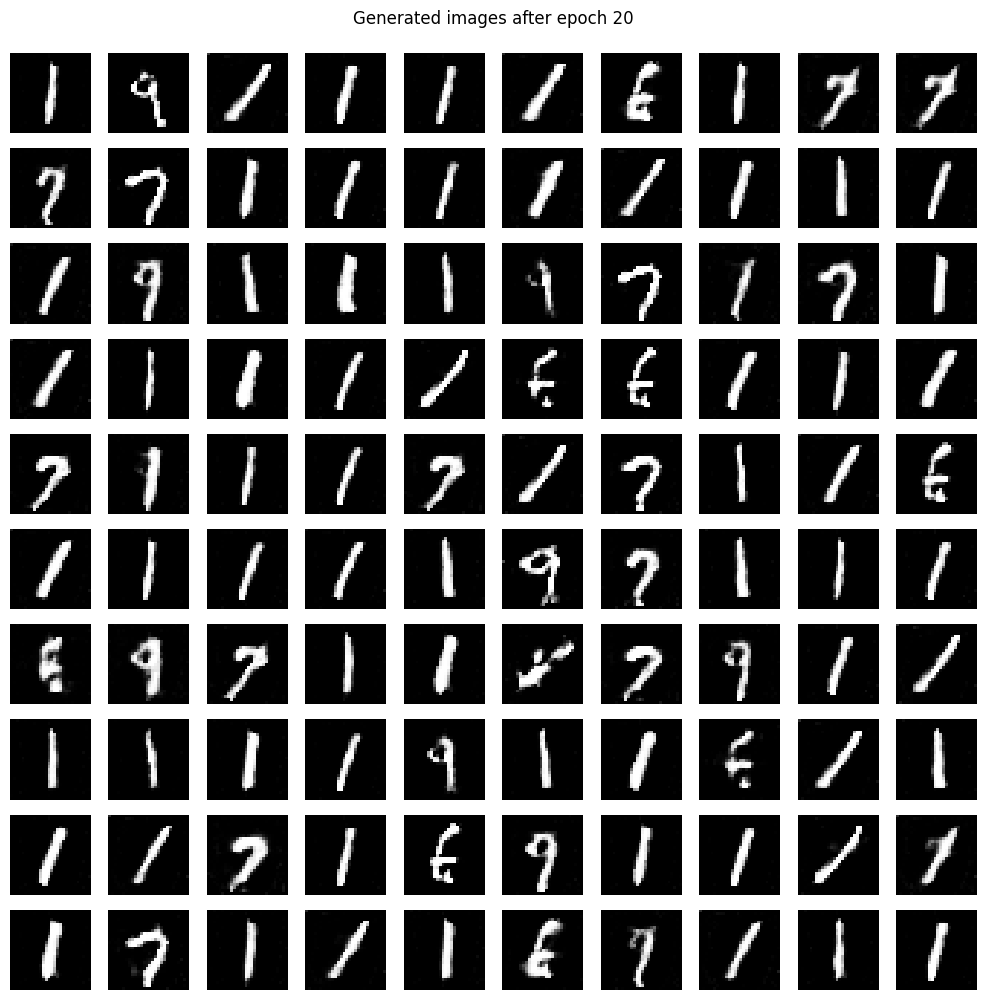


Epoch 21/100
Batch 400, D Loss: 0.7484, G Loss: 2.3536
Epoch 22/100
Batch 400, D Loss: 0.7197, G Loss: 2.6063
Epoch 23/100
Batch 400, D Loss: 0.7326, G Loss: 2.4160
Epoch 24/100
Batch 400, D Loss: 0.7499, G Loss: 2.2171
Epoch 25/100
Batch 400, D Loss: 0.8215, G Loss: 1.6618
Epoch 26/100
Batch 400, D Loss: 0.7337, G Loss: 1.9678
Epoch 27/100
Batch 400, D Loss: 0.8215, G Loss: 1.7455
Epoch 28/100
Batch 400, D Loss: 0.8522, G Loss: 1.5075
Epoch 29/100
Batch 400, D Loss: 0.7313, G Loss: 2.1035
Epoch 30/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


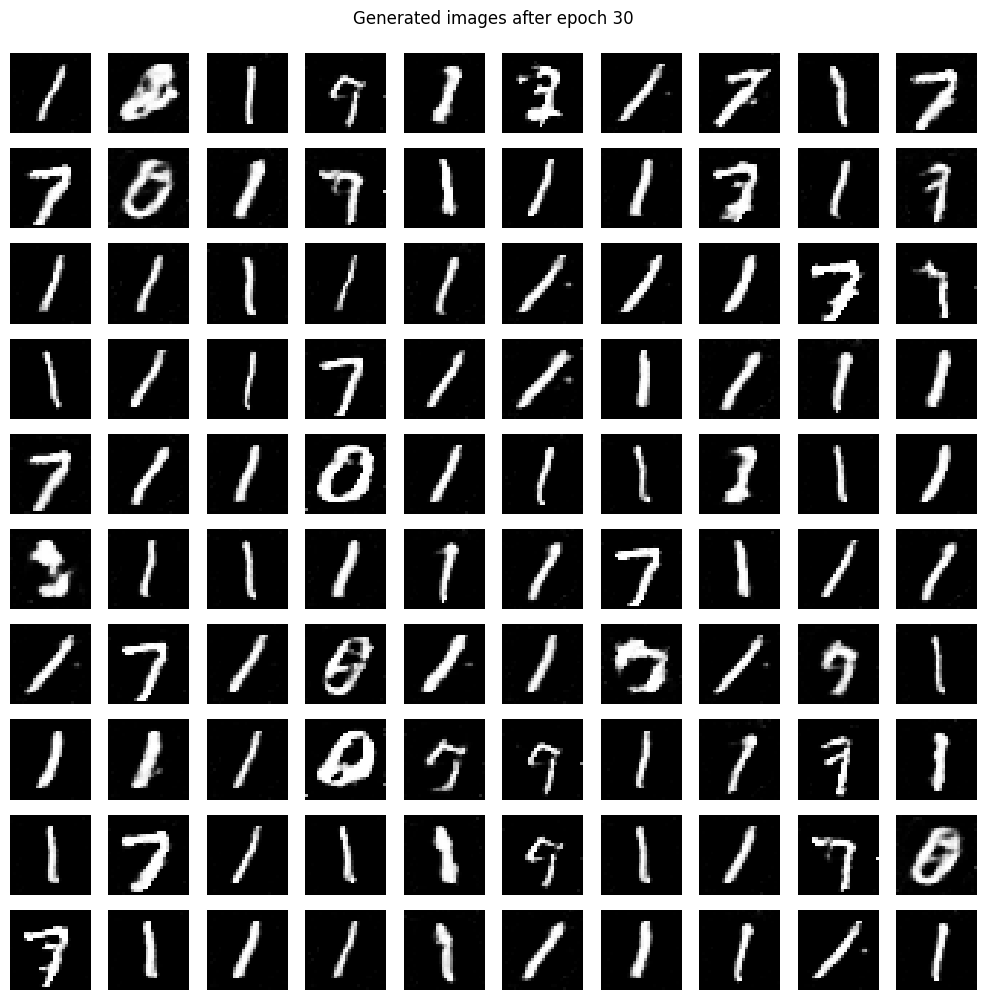


Epoch 31/100
Batch 400, D Loss: 0.6557, G Loss: 2.6449
Epoch 32/100
Batch 400, D Loss: 0.8010, G Loss: 1.9145
Epoch 33/100
Batch 400, D Loss: 0.7461, G Loss: 2.1383
Epoch 34/100
Batch 400, D Loss: 0.6773, G Loss: 2.8807
Epoch 35/100
Batch 400, D Loss: 0.6318, G Loss: 2.6421
Epoch 36/100
Batch 400, D Loss: 0.7112, G Loss: 2.0618
Epoch 37/100
Batch 400, D Loss: 0.7447, G Loss: 2.2121
Epoch 38/100
Batch 400, D Loss: 0.7932, G Loss: 1.9491
Epoch 39/100
Batch 400, D Loss: 0.7467, G Loss: 2.3385
Epoch 40/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


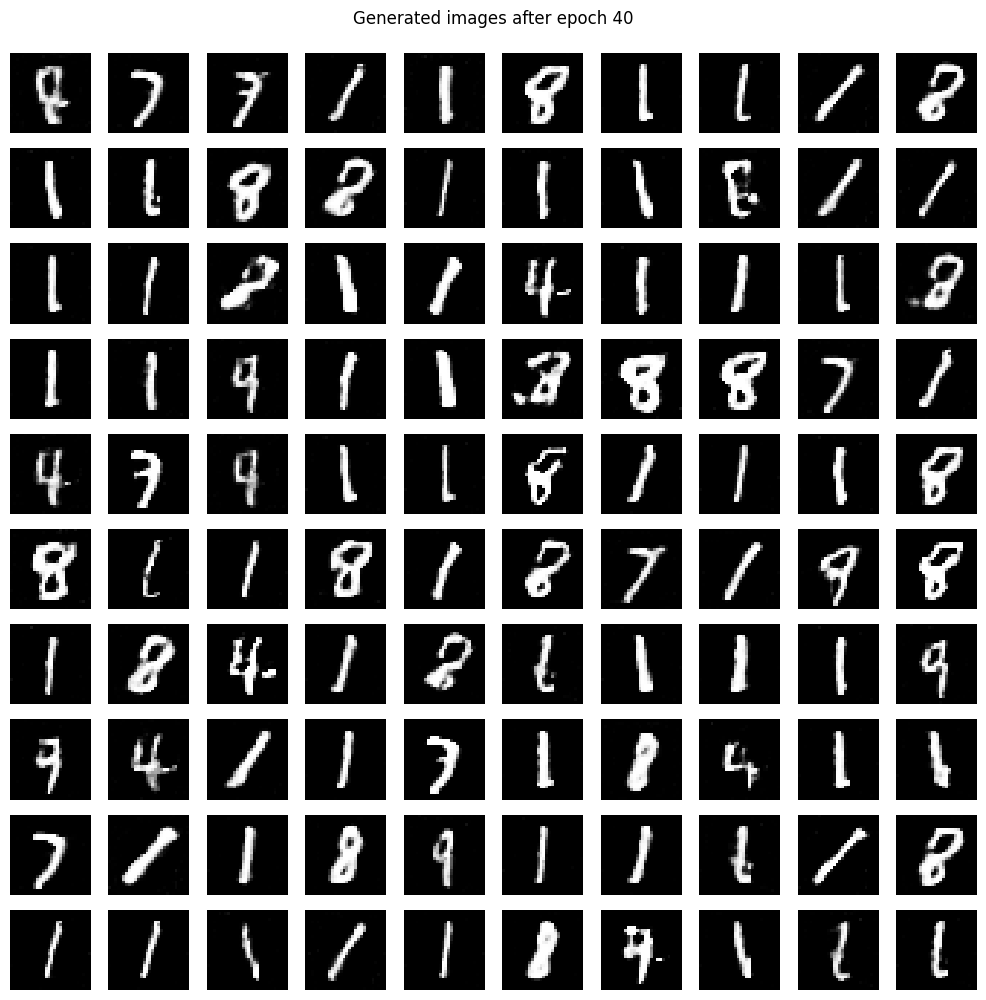


Epoch 41/100
Batch 400, D Loss: 0.7528, G Loss: 2.1721
Epoch 42/100
Batch 400, D Loss: 0.7849, G Loss: 2.2596
Epoch 43/100
Batch 400, D Loss: 0.7723, G Loss: 1.7407
Epoch 44/100
Batch 400, D Loss: 0.8279, G Loss: 1.8099
Epoch 45/100
Batch 400, D Loss: 0.8176, G Loss: 1.7535
Epoch 46/100
Batch 400, D Loss: 0.7897, G Loss: 1.9375
Epoch 47/100
Batch 400, D Loss: 0.7753, G Loss: 1.6991
Epoch 48/100
Batch 400, D Loss: 0.8146, G Loss: 1.7373
Epoch 49/100
Batch 400, D Loss: 0.7525, G Loss: 2.1888
Epoch 50/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


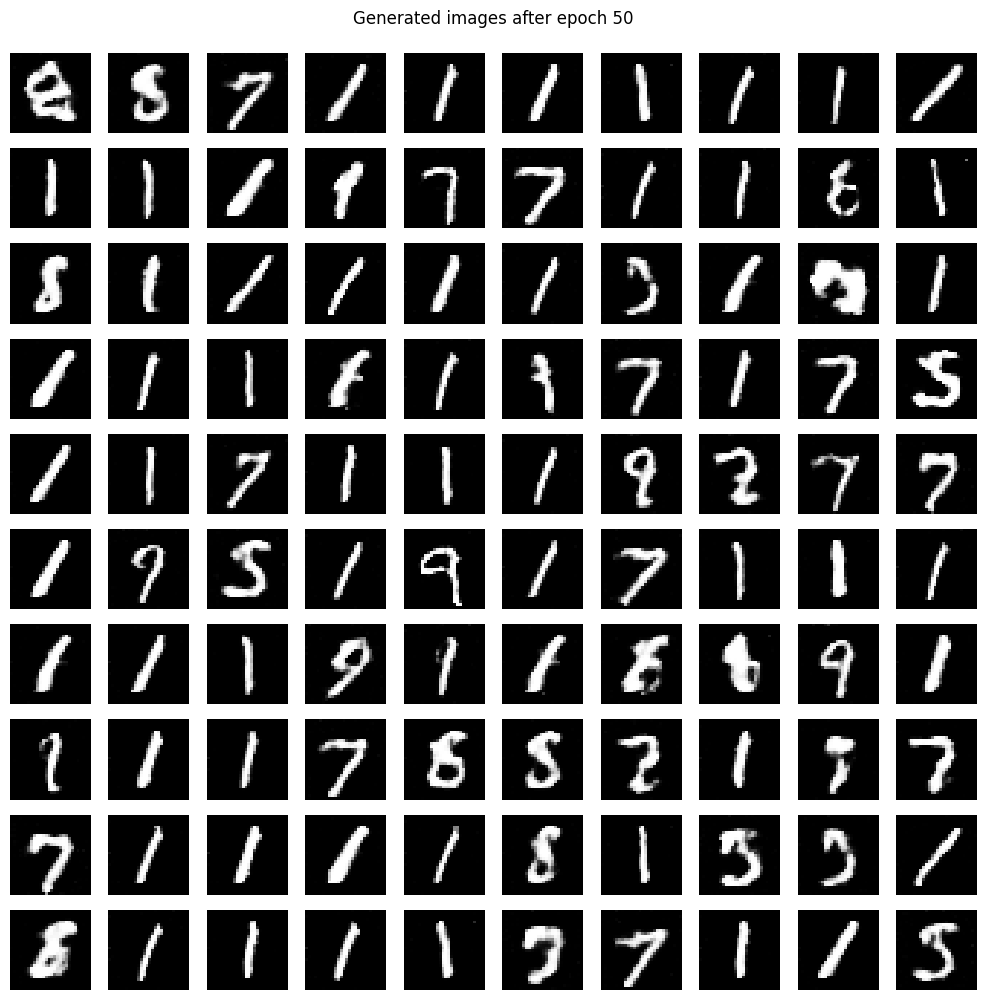


Epoch 51/100
Batch 400, D Loss: 0.8220, G Loss: 1.8398
Epoch 52/100
Batch 400, D Loss: 0.8150, G Loss: 1.8839
Epoch 53/100
Batch 400, D Loss: 0.7279, G Loss: 2.2071
Epoch 54/100
Batch 400, D Loss: 0.8387, G Loss: 2.1475
Epoch 55/100
Batch 400, D Loss: 0.7760, G Loss: 1.7420
Epoch 56/100
Batch 400, D Loss: 0.7976, G Loss: 2.1639
Epoch 57/100
Batch 400, D Loss: 0.7834, G Loss: 1.8375
Epoch 58/100
Batch 400, D Loss: 0.8387, G Loss: 2.0948
Epoch 59/100
Batch 400, D Loss: 0.7728, G Loss: 2.0490
Epoch 60/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


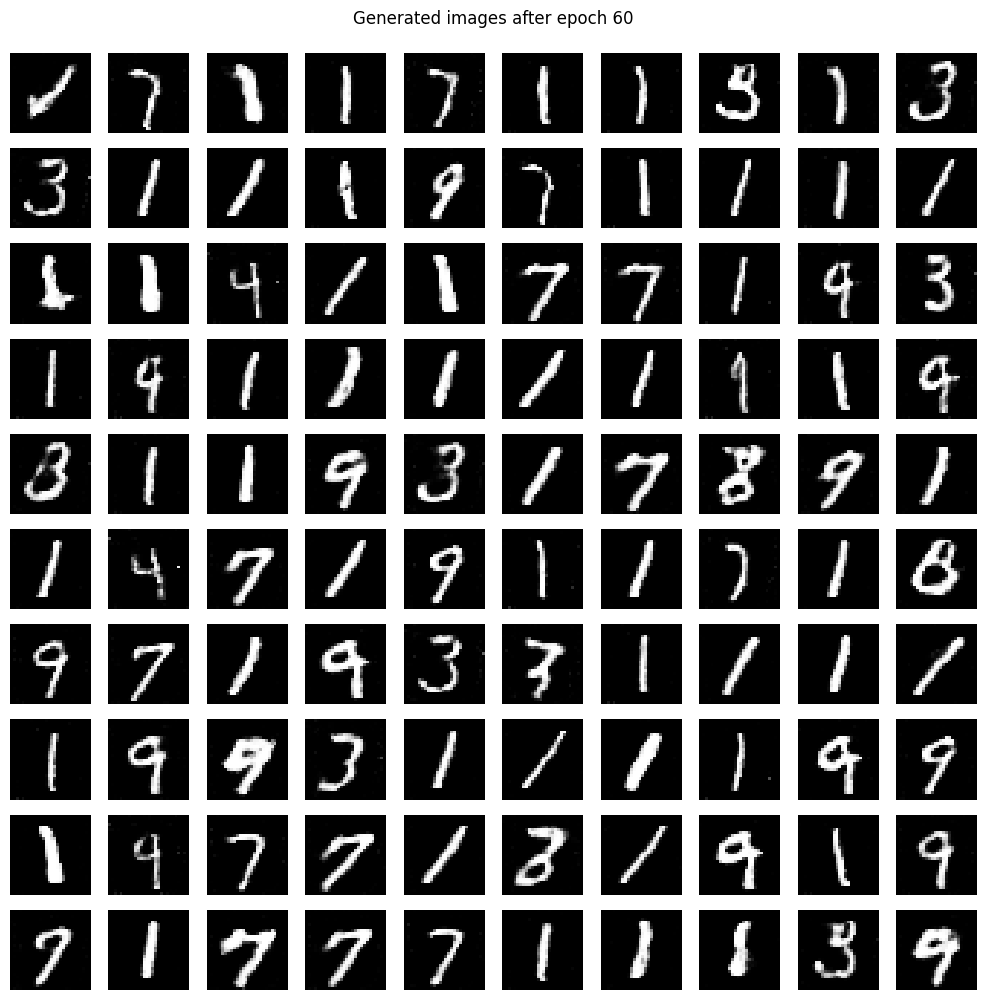


Epoch 61/100
Batch 400, D Loss: 0.7703, G Loss: 2.1628
Epoch 62/100
Batch 400, D Loss: 0.7590, G Loss: 1.9259
Epoch 63/100
Batch 400, D Loss: 0.7287, G Loss: 2.1525
Epoch 64/100
Batch 400, D Loss: 0.6901, G Loss: 2.3234
Epoch 65/100
Batch 400, D Loss: 0.7224, G Loss: 2.1964
Epoch 66/100
Batch 400, D Loss: 0.7546, G Loss: 1.9692
Epoch 67/100
Batch 400, D Loss: 0.7688, G Loss: 1.8336
Epoch 68/100
Batch 400, D Loss: 0.7786, G Loss: 2.0360
Epoch 69/100
Batch 400, D Loss: 0.7818, G Loss: 2.0709
Epoch 70/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


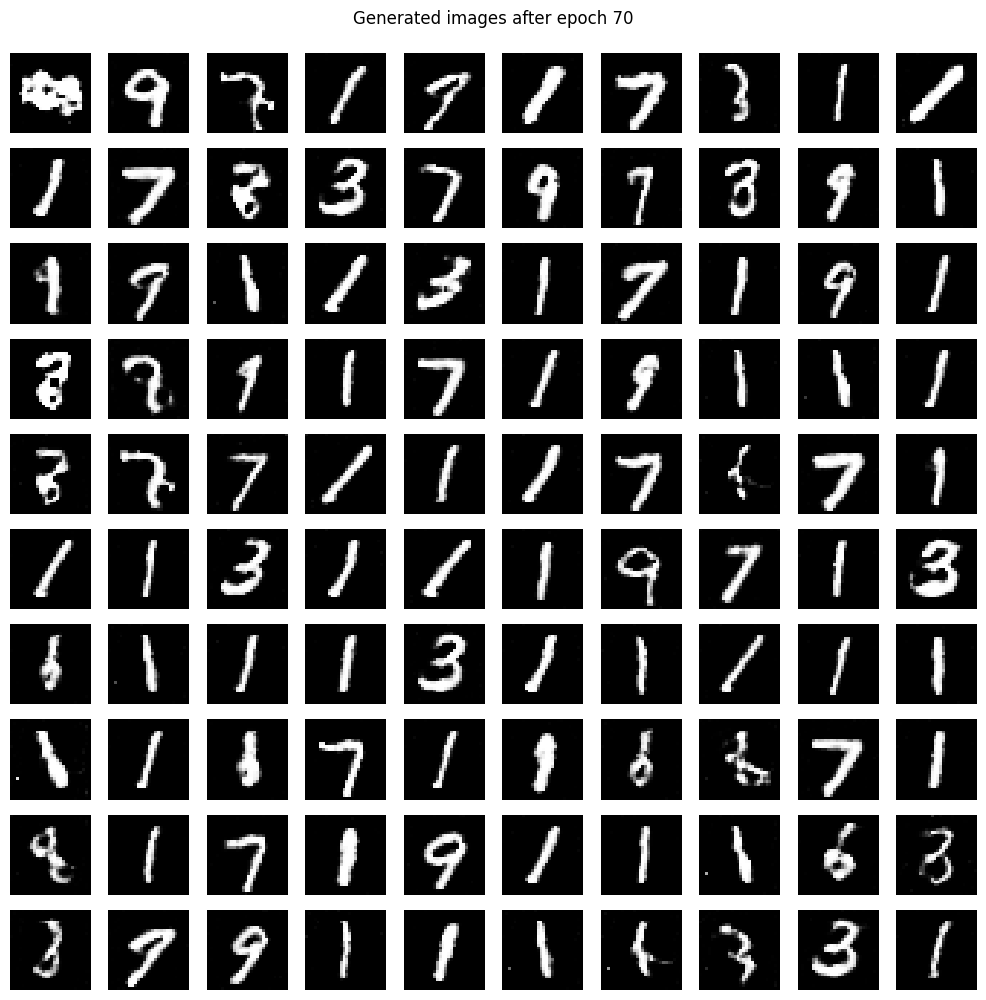


Epoch 71/100
Batch 400, D Loss: 0.6506, G Loss: 2.0415
Epoch 72/100
Batch 400, D Loss: 0.7458, G Loss: 1.9597
Epoch 73/100
Batch 400, D Loss: 0.8497, G Loss: 1.9574
Epoch 74/100
Batch 400, D Loss: 0.7602, G Loss: 1.7437
Epoch 75/100
Batch 400, D Loss: 0.7328, G Loss: 2.1688
Epoch 76/100
Batch 400, D Loss: 0.7348, G Loss: 1.9992
Epoch 77/100
Batch 400, D Loss: 0.6996, G Loss: 1.9145
Epoch 78/100
Batch 400, D Loss: 0.7095, G Loss: 2.1447
Epoch 79/100
Batch 400, D Loss: 0.8200, G Loss: 1.9071
Epoch 80/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


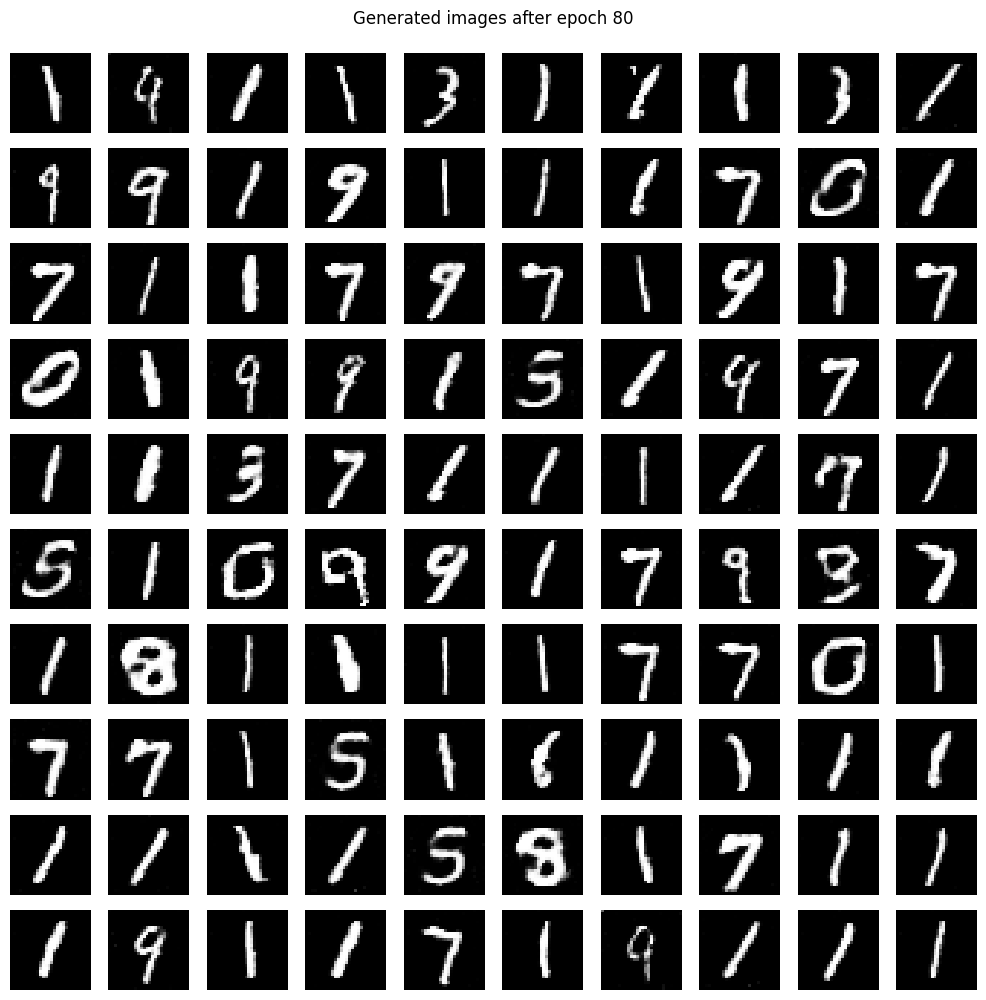


Epoch 81/100
Batch 400, D Loss: 0.7226, G Loss: 2.0882
Epoch 82/100
Batch 400, D Loss: 0.7191, G Loss: 2.0770
Epoch 83/100
Batch 400, D Loss: 0.6989, G Loss: 1.9098
Epoch 84/100
Batch 400, D Loss: 0.6947, G Loss: 2.1305
Epoch 85/100
Batch 400, D Loss: 0.7756, G Loss: 2.2011
Epoch 86/100
Batch 400, D Loss: 0.8139, G Loss: 1.9433
Epoch 87/100
Batch 400, D Loss: 0.7180, G Loss: 1.9528
Epoch 88/100
Batch 400, D Loss: 0.7799, G Loss: 1.9572
Epoch 89/100
Batch 400, D Loss: 0.7451, G Loss: 2.0227
Epoch 90/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


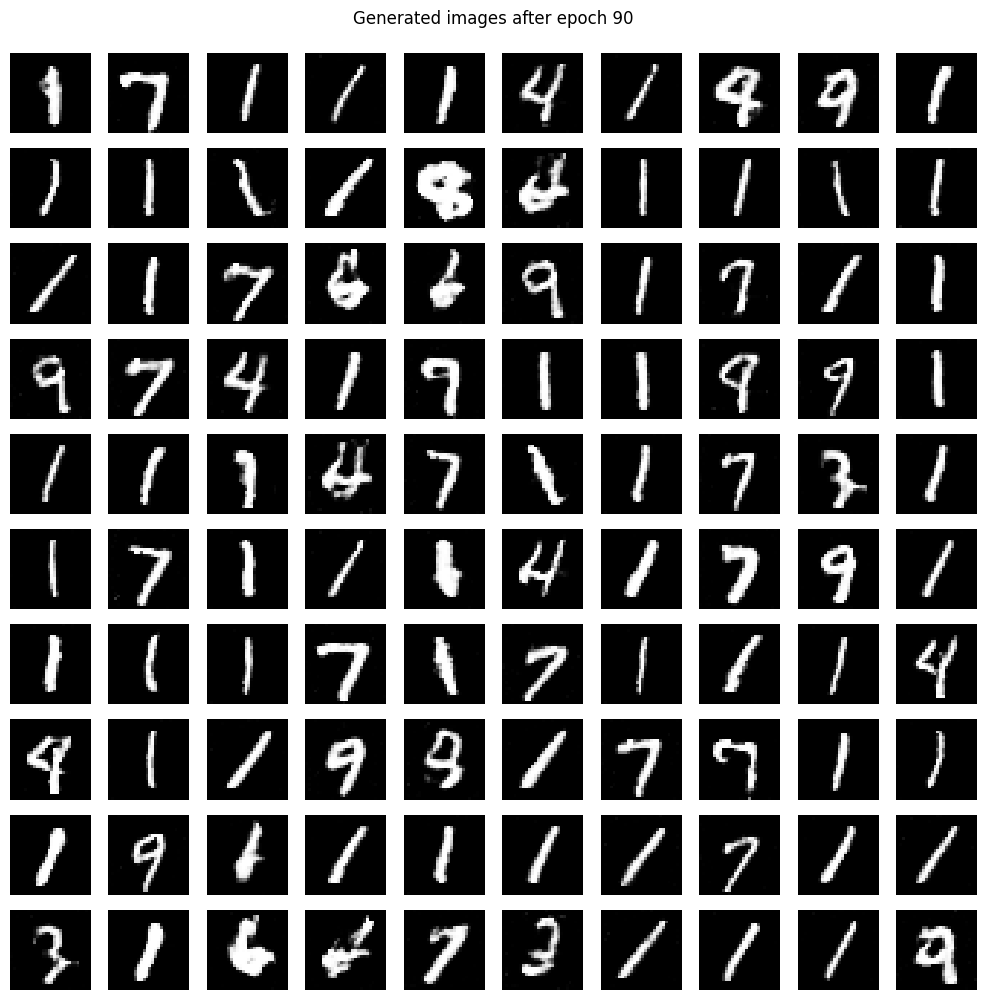


Epoch 91/100
Batch 400, D Loss: 0.7170, G Loss: 2.2958
Epoch 92/100
Batch 400, D Loss: 0.8835, G Loss: 1.7855
Epoch 93/100
Batch 400, D Loss: 0.6737, G Loss: 2.2494
Epoch 94/100
Batch 400, D Loss: 0.6724, G Loss: 2.3289
Epoch 95/100
Batch 400, D Loss: 0.7562, G Loss: 1.9594
Epoch 96/100
Batch 400, D Loss: 0.6896, G Loss: 2.1025
Epoch 97/100
Batch 400, D Loss: 0.7090, G Loss: 2.1835
Epoch 98/100
Batch 400, D Loss: 0.6523, G Loss: 2.0624
Epoch 99/100
Batch 400, D Loss: 0.7416, G Loss: 2.1334
Epoch 100/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


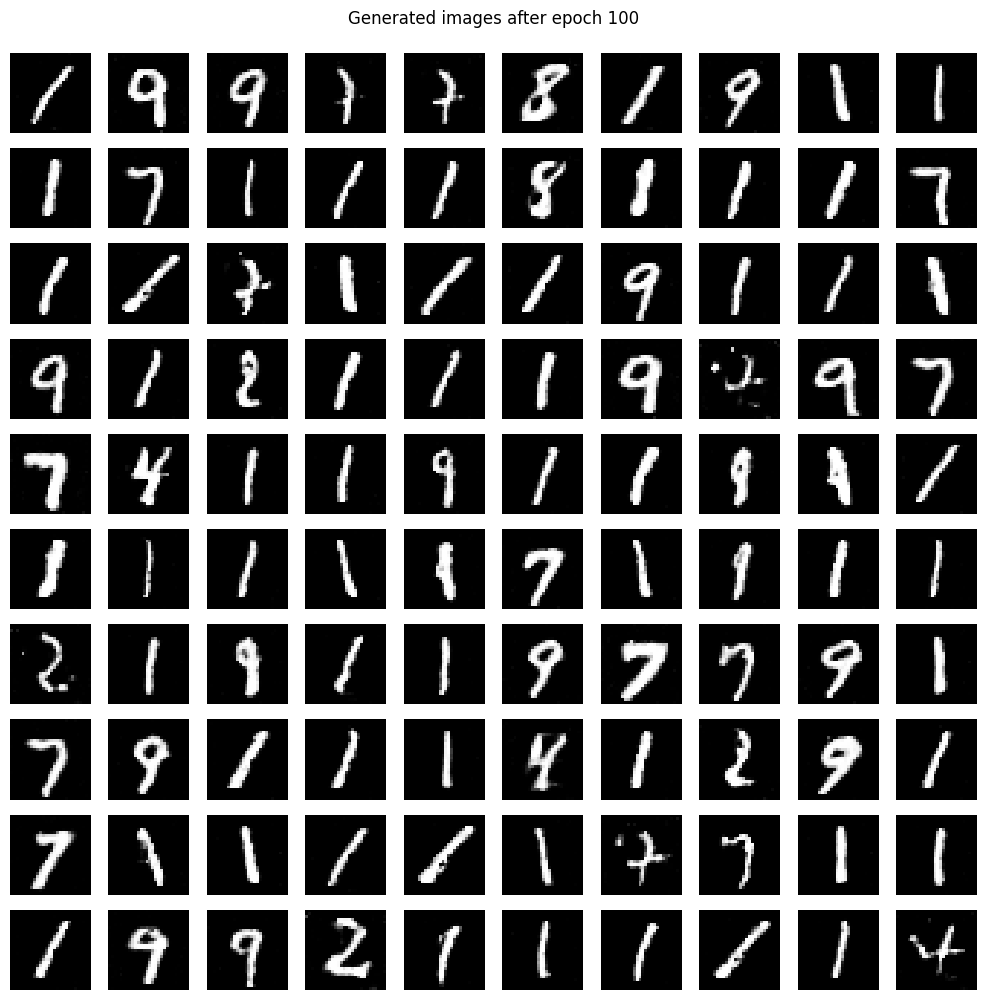

In [224]:
train(epochs=100, batch_size=128)

#### 4-Conv layer with leakyRelu and batch normalization

In [206]:
from tensorflow.keras.layers import Conv2D, LeakyReLU, Dropout, Reshape, Flatten, Dense, BatchNormalization

def create_discriminator():
    discriminator = Sequential()

    # Reshape layer
    discriminator.add(layers.Reshape((28, 28, 1), input_shape=(784,)))

    # First conv layer
    discriminator.add(Conv2D(32, (3, 3), strides=(2, 2), padding='same'))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))
    # 14x14x32

    # Second conv layer
    discriminator.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))
    # 7x7x64

    # Third conv layer
    discriminator.add(Conv2D(128, (3, 3), padding='same'))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))
    # 7x7x128

    # Fourth conv layer
    discriminator.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))
    # 4x4x256

    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))

    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer(), metrics=['accuracy'])

    return discriminator


In [207]:
class GAN():
    def __init__(self):
        self.generator = create_generator()
        self.discriminator = create_discriminator()
        learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.0002,
        decay_steps=10000,
        decay_rate=0.9,
        staircase=True)
        # Use same learning rate for both networks
        self.g_optimizer = Adam(learning_rate=learning_rate, beta_1=0.5)
        self.d_optimizer = Adam(learning_rate=learning_rate, beta_1=0.5)

        self.loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    @tf.function
    def train_discriminator(self, real_images, batch_size):
        noise = tf.random.normal([batch_size, 100])

        with tf.GradientTape() as tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            # Using hard labels (no smoothing)
            real_labels = tf.ones_like(real_output) * 0.9
            fake_labels = tf.zeros_like(fake_output)

            real_loss = self.loss_fn(real_labels, real_output)
            fake_loss = self.loss_fn(fake_labels, fake_output)
            total_loss = real_loss + fake_loss

        gradients = tape.gradient(total_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))

        return total_loss

    @tf.function
    def train_generator(self, batch_size):
        noise = tf.random.normal([batch_size, 100])

        with tf.GradientTape() as tape:
            generated_images = self.generator(noise, training=True)
            fake_output = self.discriminator(generated_images, training=False)

            labels = tf.ones_like(fake_output)*0.9
            loss = self.loss_fn(labels, fake_output)*0.1

        gradients = tape.gradient(loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        return loss

def train(epochs=50, batch_size=128):
    x_train, _, _, _ = load_data()
    dataset_size = x_train.shape[0]

    dataset = tf.data.Dataset.from_tensor_slices(x_train) \
        .shuffle(dataset_size) \
        .batch(batch_size, drop_remainder=True) \
        .prefetch(tf.data.AUTOTUNE)

    gan = GAN()

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        d_losses = []
        g_losses = []

        for batch_idx, real_images in enumerate(dataset):
            # Train both networks equally
            d_loss = gan.train_discriminator(real_images, batch_size)
            d_losses.append(float(d_loss))

            g_loss = gan.train_generator(batch_size)
            g_losses.append(float(g_loss))

            if batch_idx % 50 == 0:
                avg_d_loss = np.mean(d_losses[-50:]) if d_losses else 0
                avg_g_loss = np.mean(g_losses[-50:]) if g_losses else 0
                print(f"\rBatch {batch_idx}, "
                      f"D Loss: {avg_d_loss:.4f}, "
                      f"G Loss: {avg_g_loss:.4f}", end="")

        avg_d_loss = np.mean(d_losses)
        avg_g_loss = np.mean(g_losses)
        print(f"\nEpoch {epoch + 1} Summary - "
              f"Avg D Loss: {avg_d_loss:.4f}, "
              f"Avg G Loss: {avg_g_loss:.4f}")

        if (epoch + 1) % 5 == 0:
            plot_generated_images(epoch + 1, gan.generator)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1/50
Batch 450, D Loss: 0.3311, G Loss: 0.0422
Epoch 1 Summary - Avg D Loss: 0.3477, Avg G Loss: 0.0587

Epoch 2/50
Batch 450, D Loss: 0.3281, G Loss: 0.0429
Epoch 2 Summary - Avg D Loss: 0.3287, Avg G Loss: 0.0419

Epoch 3/50
Batch 450, D Loss: 0.3270, G Loss: 0.0326
Epoch 3 Summary - Avg D Loss: 0.3275, Avg G Loss: 0.0354

Epoch 4/50
Batch 450, D Loss: 0.3268, G Loss: 0.0327
Epoch 4 Summary - Avg D Loss: 0.3265, Avg G Loss: 0.0326

Epoch 5/50
Batch 450, D Loss: 0.3266, G Loss: 0.0367
Epoch 5 Summary - Avg D Loss: 0.3265, Avg G Loss: 0.0331
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step


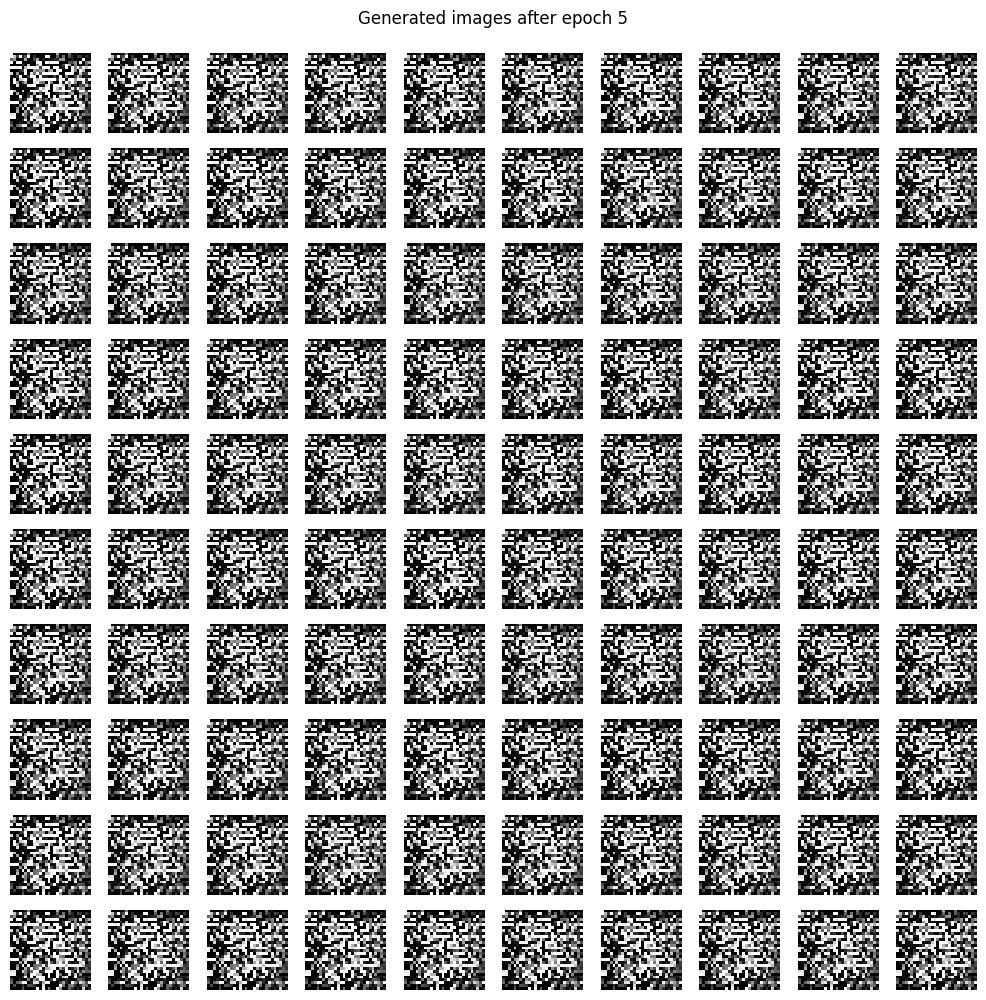


Epoch 6/50
Batch 250, D Loss: 0.3264, G Loss: 0.0329

KeyboardInterrupt: 

In [208]:
train(epochs=50, batch_size=128)

New model

In [209]:
def define_discriminator():
    model = Sequential()
    model.add(Reshape((28, 28, 1), input_shape=(784,)))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return model

In [210]:
def adam_optimizer():
    return Adam(learning_rate=0.0005, beta_1=0.5)

In [211]:
class GAN:
    def __init__(self):
        # Initialize models
        self.generator = create_generator()
        self.discriminator = define_discriminator()
        learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.0002,
        decay_steps=10000,
        decay_rate=0.9,
        staircase=True)
        # Initialize optimizers with mixed precision
        self.g_optimizer = Adam(learning_rate=learning_rate, beta_1=0.5)
        self.d_optimizer = Adam(learning_rate=learning_rate, beta_1=0.5)

        # Loss function
        self.loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    @tf.function
    def train_discriminator(self, real_images, batch_size):
        real_images = tf.cast(real_images, tf.float16)
        noise = tf.random.normal([batch_size, 100], dtype=tf.float16)

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Get predictions
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            # Label smoothing and noise injection
            real_labels = tf.ones_like(real_output) * 0.9
            fake_labels = tf.zeros_like(fake_output)
            #real_labels += tf.cast(tf.random.uniform(real_labels.shape, minval=0, maxval=0.1), real_labels.dtype) noise injection
            #fake_labels += tf.cast(tf.random.uniform(fake_labels.shape, minval=0, maxval=0.1), fake_labels.dtype)

            # Calculate losses
            real_loss = self.loss_fn(real_labels, real_output)
            fake_loss = self.loss_fn(fake_labels, fake_output)
            total_loss = real_loss + fake_loss


        gradients = tape.gradient(total_loss, self.discriminator.trainable_variables)

        # Clip the gradients
        clipped_gradients = [tf.clip_by_value(g, -0.01, 0.01) for g in gradients]

        # clipped gradients
        self.d_optimizer.apply_gradients(zip(clipped_gradients, self.discriminator.trainable_variables))

        return total_loss

    @tf.function(reduce_retracing=True)
    def train_generator(self, batch_size):
        noise = tf.random.normal([batch_size, 100], dtype=tf.float16)

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Get predictions
            fake_output = self.discriminator(generated_images, training=False)

            # Calculate loss
            labels = tf.ones_like(fake_output)
            loss = self.loss_fn(labels, fake_output)

        # Calculate gradients
        gradients = tape.gradient(loss, self.generator.trainable_variables)

        # Apply gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        return loss


# Train discriminator multiple times
def train(epochs=50, batch_size=128, d_update_steps=5):
    x_train, _, _, _ = load_data()
    dataset_size = x_train.shape[0]
    dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(dataset_size).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    gan = GAN()

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        for batch_idx, real_images in enumerate(dataset):
            for _ in range(d_update_steps):
                d_loss = gan.train_discriminator(real_images, batch_size)

            g_loss = gan.train_generator(batch_size)

            if batch_idx % 100 == 0:
                print(f"\rBatch {batch_idx}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}", end="")

        # Generate and save images every 10 epochs
        if (epoch + 1) % 10 == 0:
            plot_generated_images(epoch + 1, gan.generator)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(



Epoch 1/50
Batch 400, D Loss: 0.5083, G Loss: 3.9761
Epoch 2/50
Batch 400, D Loss: 0.5338, G Loss: 4.0690
Epoch 3/50
Batch 400, D Loss: 0.4224, G Loss: 5.2509
Epoch 4/50
Batch 400, D Loss: 0.4252, G Loss: 4.9386
Epoch 5/50
Batch 400, D Loss: 0.4705, G Loss: 4.4589
Epoch 6/50
Batch 400, D Loss: 0.4692, G Loss: 4.4489
Epoch 7/50
Batch 400, D Loss: 0.4868, G Loss: 4.7509
Epoch 8/50
Batch 400, D Loss: 0.5318, G Loss: 3.7931
Epoch 9/50
Batch 400, D Loss: 0.4592, G Loss: 4.3461
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step


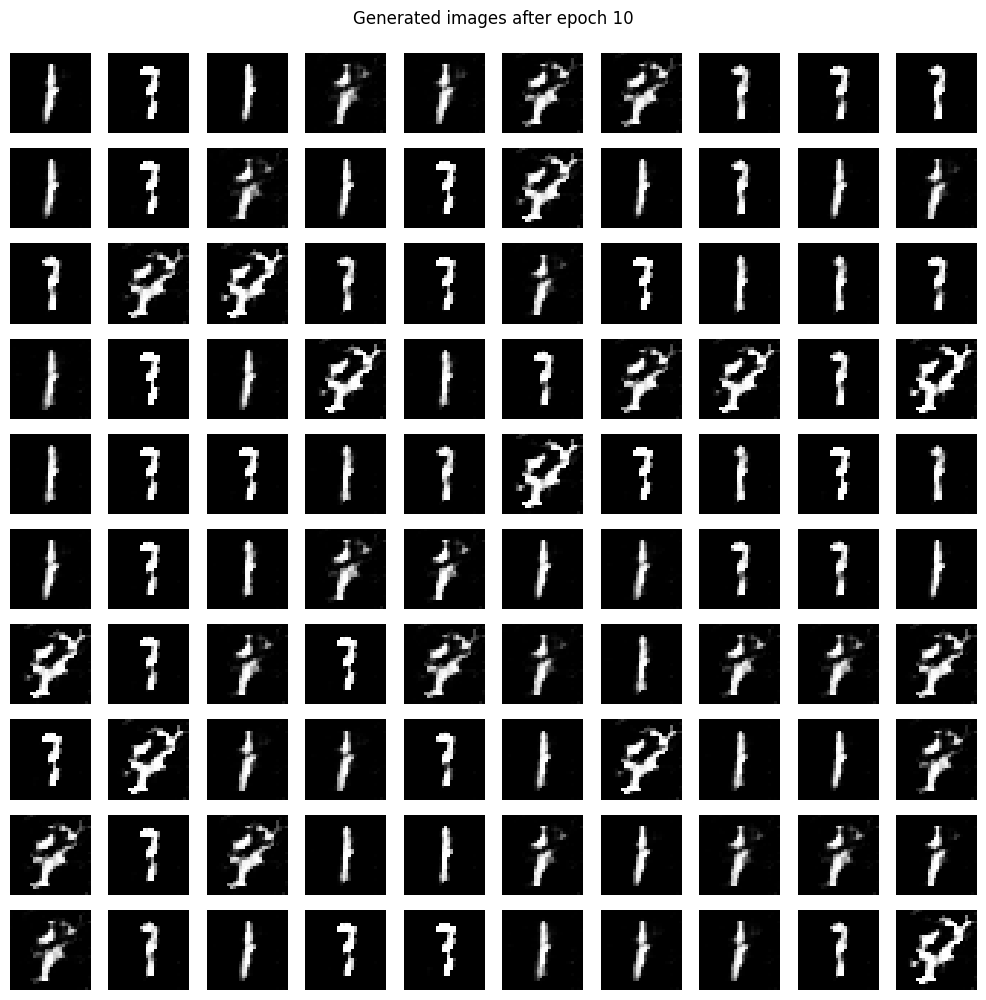


Epoch 11/50
Batch 400, D Loss: 0.5814, G Loss: 3.4786
Epoch 12/50
Batch 400, D Loss: 0.5546, G Loss: 3.8405
Epoch 13/50
Batch 400, D Loss: 0.6074, G Loss: 3.7597
Epoch 14/50
Batch 400, D Loss: 0.5338, G Loss: 3.9404
Epoch 15/50
Batch 400, D Loss: 0.5479, G Loss: 3.7179
Epoch 16/50
Batch 400, D Loss: 0.5954, G Loss: 3.5935
Epoch 17/50
Batch 400, D Loss: 0.6159, G Loss: 3.8897
Epoch 18/50
Batch 400, D Loss: 0.5319, G Loss: 3.7741
Epoch 19/50
Batch 400, D Loss: 0.5969, G Loss: 3.8669
Epoch 20/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


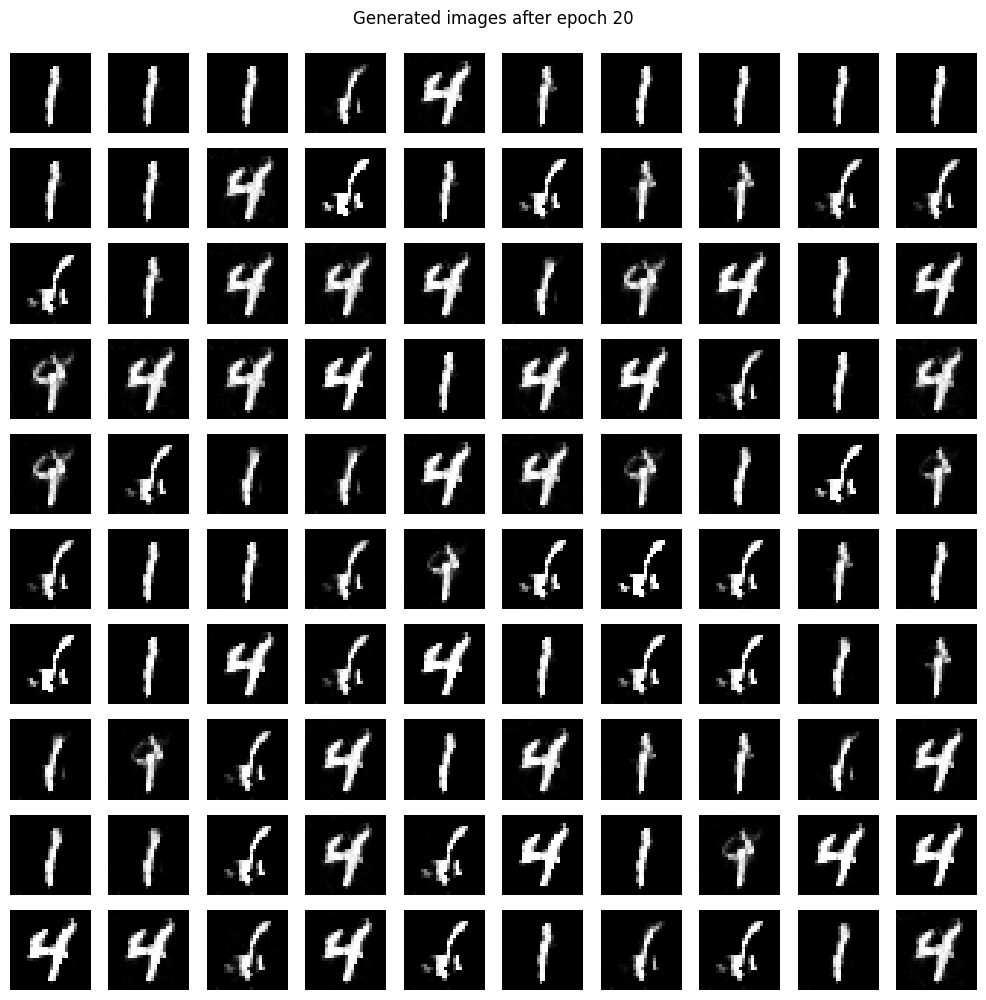


Epoch 21/50
Batch 400, D Loss: 0.5587, G Loss: 4.1323
Epoch 22/50
Batch 400, D Loss: 0.5765, G Loss: 4.0545
Epoch 23/50
Batch 400, D Loss: 0.6596, G Loss: 3.4339
Epoch 24/50
Batch 400, D Loss: 0.6244, G Loss: 3.6549
Epoch 25/50
Batch 400, D Loss: 0.5672, G Loss: 3.8604
Epoch 26/50
Batch 400, D Loss: 0.5603, G Loss: 3.8636
Epoch 27/50
Batch 400, D Loss: 0.6589, G Loss: 3.4463
Epoch 28/50
Batch 400, D Loss: 0.6000, G Loss: 3.9586
Epoch 29/50
Batch 400, D Loss: 0.6028, G Loss: 3.5379
Epoch 30/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


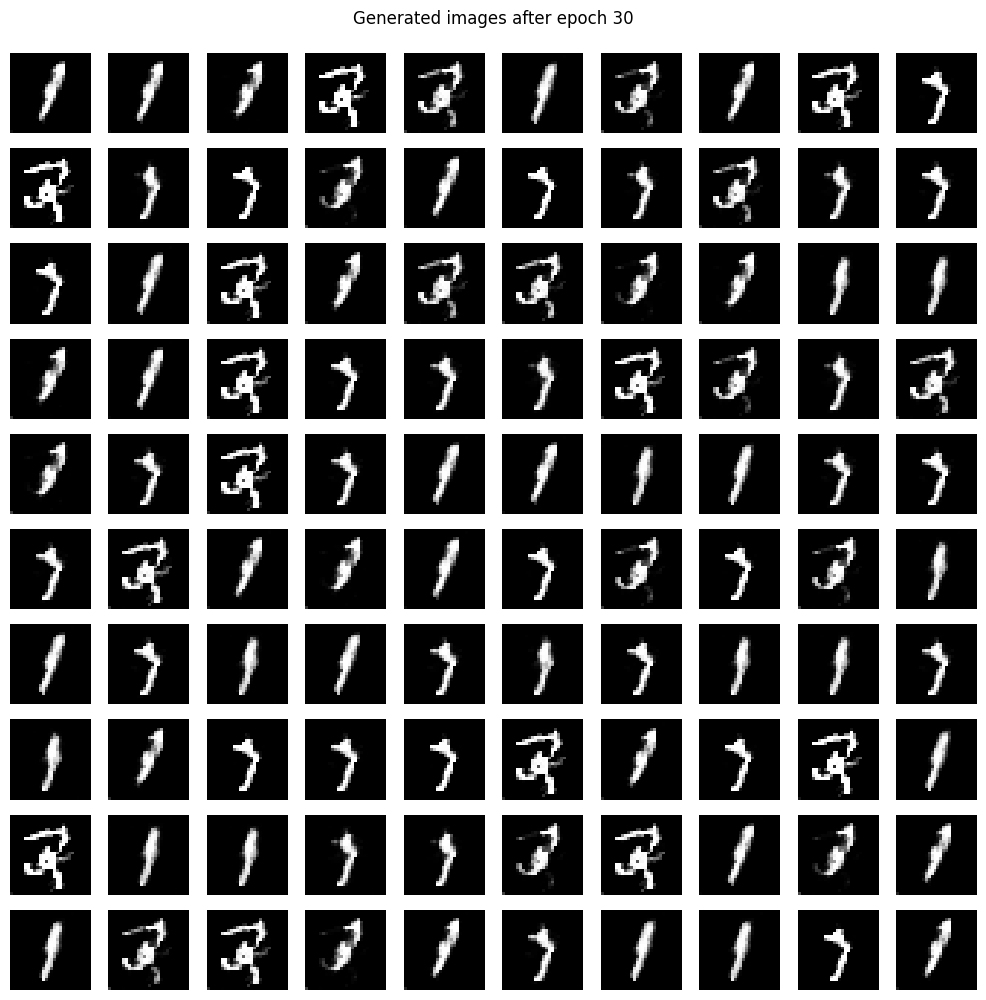


Epoch 31/50
Batch 400, D Loss: 0.6808, G Loss: 3.3296
Epoch 32/50
Batch 400, D Loss: 0.6721, G Loss: 3.4956
Epoch 33/50
Batch 400, D Loss: 0.7133, G Loss: 3.6670
Epoch 34/50
Batch 400, D Loss: 0.5747, G Loss: 4.0521
Epoch 35/50
Batch 400, D Loss: 0.6281, G Loss: 3.5852
Epoch 36/50
Batch 100, D Loss: 0.6057, G Loss: 3.7152

KeyboardInterrupt: 

In [212]:
train(epochs=50, batch_size=128)

PART-2

In [229]:
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # Normalize to [-1, 1]
    x_train = (x_train.astype(np.float32) - 127.5) / 127.5
    x_train = np.expand_dims(x_train, axis=-1)  # Shape becomes (60000, 28, 28, 1)
    x_test = (x_test.astype(np.float32) - 127.5) / 127.5
    x_test = np.expand_dims(x_test, axis=-1)  # Shape becomes (10000, 28, 28, 1)
    return (x_train, y_train, x_test, y_test)

In [230]:
(X_train, y_train,X_test, y_test)=load_data()
print(X_train.shape)

(60000, 28, 28, 1)


In [231]:
from tensorflow.keras.layers import Conv2D, LeakyReLU, Dropout, Flatten, Dense, BatchNormalization

def define_discriminator():
    model = Sequential()
    #model.add(Reshape((28, 28, 1), input_shape=(784,)))
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    #model.add(Dropout(0.4))
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    #model.add(Dropout(0.4))

    # Flatten the 3D input to 1D
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return model

In [232]:
from tensorflow.keras.layers import Conv2D, LeakyReLU, Dropout, Reshape, Flatten, Dense, BatchNormalization, Conv2DTranspose
from tensorflow.keras.initializers import GlorotNormal

def define_generator():
    model = Sequential()
    # Foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=100, kernel_initializer=GlorotNormal()))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # Upsample to 14x14
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=GlorotNormal()))
    model.add(LeakyReLU(alpha=0.2))
    # Upsample to 28x28
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=GlorotNormal()))
    model.add(LeakyReLU(alpha=0.2))
    # Output layer with tanh activation
    model.add(Conv2D(1, (7, 7), activation='tanh', padding='same', kernel_initializer=GlorotNormal()))
    model.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return model

In [233]:
def adam_optimizer():
    return Adam(learning_rate=0.0005, beta_1=0.5)

In [234]:
class GAN:
    def __init__(self):
        # Initialize models
        self.generator = define_generator()
        #print("Generator weights:", self.generator.get_weights()[:5])
        self.discriminator = define_discriminator()

        learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.0002,
        decay_steps=10000,
        decay_rate=0.9,
        staircase=True)

        # Initialize optimizers with mixed precision
        self.g_optimizer = Adam(learning_rate=learning_rate, beta_1=0.5)
        self.d_optimizer = Adam(learning_rate=learning_rate, beta_1=0.5)

        # Loss function
        self.loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    @tf.function(reduce_retracing=True)
    def train_discriminator(self, real_images, batch_size):
        real_images = tf.cast(real_images, tf.float16)
        noise = tf.random.normal([batch_size, 100], dtype=tf.float16)

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Get predictions
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)
            print(f"Real output range: {tf.reduce_min(real_output)}, {tf.reduce_max(real_output)}")
            print(f"Fake output range: {tf.reduce_min(fake_output)}, {tf.reduce_max(fake_output)}")

            # Create labels
            real_labels = tf.ones_like(real_output) *0.9
            fake_labels = tf.zeros_like(fake_output)

            # Calculate losses
            real_loss = self.loss_fn(real_labels, real_output)
            fake_loss = self.loss_fn(fake_labels, fake_output)
            total_loss = real_loss + fake_loss

        # Calculate gradients
        gradients = tape.gradient(total_loss, self.discriminator.trainable_variables)

        # Apply gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))

        return total_loss

    @tf.function(reduce_retracing=True)
    def train_generator(self, batch_size):
        noise = tf.random.normal([batch_size, 100], dtype=tf.float16)

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)
            print(f"Generated images shape: {generated_images.shape}")
            print(f"Generated images min value: {tf.reduce_min(generated_images)}")
            print(f"Generated images max value: {tf.reduce_max(generated_images)}")

            # Get predictions
            fake_output = self.discriminator(generated_images, training=False)

            # Calculate loss
            labels = tf.ones_like(fake_output)
            loss = self.loss_fn(labels, fake_output)

        # Calculate gradients
        gradients = tape.gradient(loss, self.generator.trainable_variables)

        # Apply gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        return loss



def train(epochs=50, batch_size=128):
    # Load and prepare data
    x_train, _, _, _ = load_data()
    dataset_size = x_train.shape[0]

    # Create dataset with fixed shapes and types
    dataset = tf.data.Dataset.from_tensor_slices(x_train) \
        .shuffle(dataset_size) \
        .batch(batch_size, drop_remainder=True) \
        .prefetch(tf.data.AUTOTUNE)

    # Initialize GAN
    gan = GAN()

    # Training loop
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        for batch_idx, real_images in enumerate(dataset):
            d_loss = gan.train_discriminator(real_images, batch_size)
            g_loss = gan.train_generator(batch_size)

            if batch_idx % 100 == 0:
                print(f"\rBatch {batch_idx}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}", end="")

        # Generate and save images every 10 epochs
        if (epoch + 1) % 10 == 0:
            plot_generated_images(epoch + 1, gan.generator)


Epoch 1/50
Real output range: Tensor("Min:0", shape=(), dtype=float16), Tensor("Max:0", shape=(), dtype=float16)
Fake output range: Tensor("Min_1:0", shape=(), dtype=float16), Tensor("Max_1:0", shape=(), dtype=float16)
Real output range: Tensor("Min:0", shape=(), dtype=float16), Tensor("Max:0", shape=(), dtype=float16)
Fake output range: Tensor("Min_1:0", shape=(), dtype=float16), Tensor("Max_1:0", shape=(), dtype=float16)
Generated images shape: (128, 28, 28, 1)
Generated images min value: Tensor("Min:0", shape=(), dtype=float16)
Generated images max value: Tensor("Max:0", shape=(), dtype=float16)
Generated images shape: (128, 28, 28, 1)
Generated images min value: Tensor("Min:0", shape=(), dtype=float16)
Generated images max value: Tensor("Max:0", shape=(), dtype=float16)
Batch 400, D Loss: 1.2981, G Loss: 0.8627
Epoch 2/50
Batch 400, D Loss: 1.3502, G Loss: 0.8804
Epoch 3/50
Batch 400, D Loss: 1.3924, G Loss: 0.7987
Epoch 4/50
Batch 400, D Loss: 1.2609, G Loss: 0.9058
Epoch 5/50
Ba

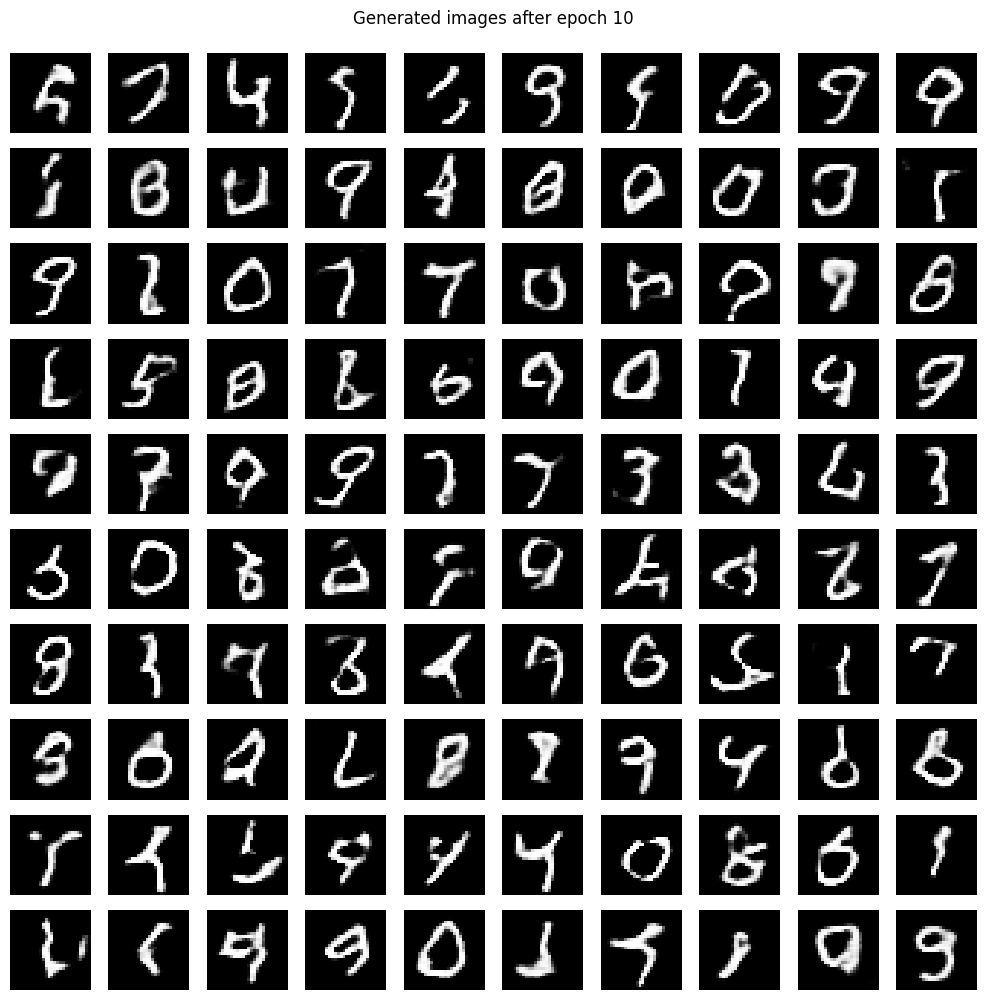


Epoch 11/50
Batch 400, D Loss: 1.3362, G Loss: 0.8070
Epoch 12/50
Batch 400, D Loss: 1.3415, G Loss: 0.7513
Epoch 13/50
Batch 400, D Loss: 1.2981, G Loss: 0.9115
Epoch 14/50
Batch 400, D Loss: 1.3359, G Loss: 0.9586
Epoch 15/50
Batch 400, D Loss: 1.3491, G Loss: 0.8784
Epoch 16/50
Batch 400, D Loss: 1.3396, G Loss: 0.8027
Epoch 17/50
Batch 400, D Loss: 1.3384, G Loss: 0.8194
Epoch 18/50
Batch 400, D Loss: 1.3385, G Loss: 0.8904
Epoch 19/50
Batch 400, D Loss: 1.3612, G Loss: 0.7028
Epoch 20/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


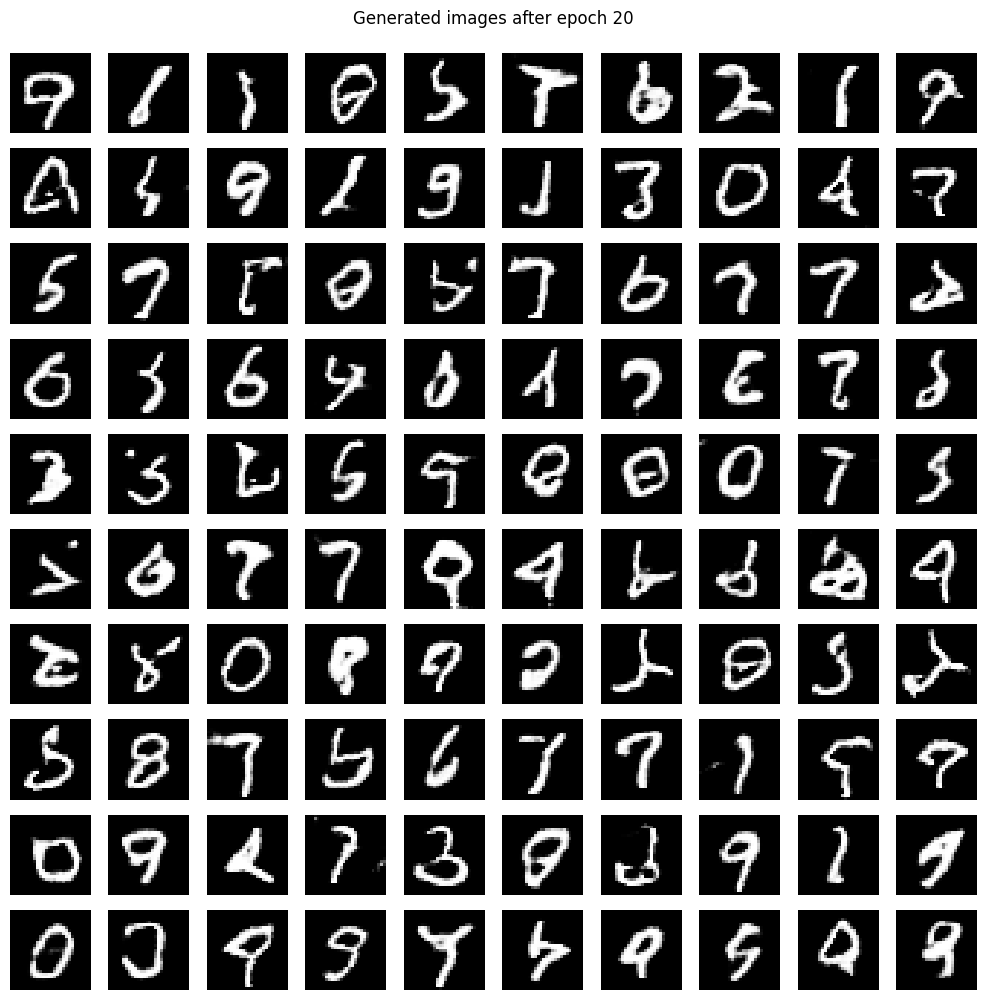


Epoch 21/50
Batch 400, D Loss: 1.3575, G Loss: 0.8802
Epoch 22/50
Batch 400, D Loss: 1.3575, G Loss: 0.7287
Epoch 23/50
Batch 400, D Loss: 1.3564, G Loss: 0.8262
Epoch 24/50
Batch 400, D Loss: 1.3570, G Loss: 0.8565
Epoch 25/50
Batch 400, D Loss: 1.3544, G Loss: 0.7871
Epoch 26/50
Batch 400, D Loss: 1.3267, G Loss: 0.7923
Epoch 27/50
Batch 400, D Loss: 1.3692, G Loss: 0.8852
Epoch 28/50
Batch 400, D Loss: 1.3619, G Loss: 0.7937
Epoch 29/50
Batch 400, D Loss: 1.3736, G Loss: 0.8071
Epoch 30/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


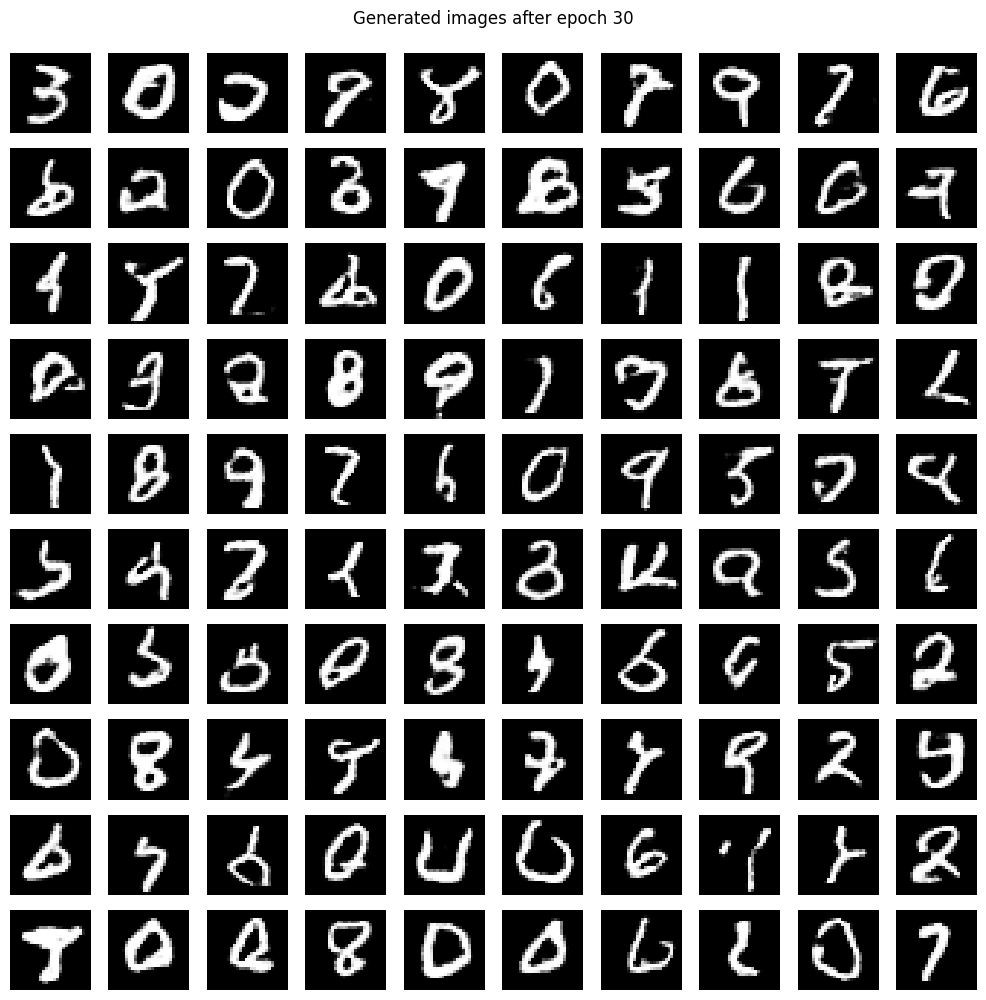


Epoch 31/50
Batch 400, D Loss: 1.3516, G Loss: 0.7967
Epoch 32/50
Batch 400, D Loss: 1.3755, G Loss: 0.7855
Epoch 33/50
Batch 400, D Loss: 1.3600, G Loss: 0.8626
Epoch 34/50
Batch 400, D Loss: 1.3659, G Loss: 0.8595
Epoch 35/50
Batch 400, D Loss: 1.3689, G Loss: 0.7838
Epoch 36/50
Batch 400, D Loss: 1.3762, G Loss: 0.7752
Epoch 37/50
Batch 400, D Loss: 1.3642, G Loss: 0.8821
Epoch 38/50
Batch 400, D Loss: 1.3717, G Loss: 0.8121
Epoch 39/50
Batch 400, D Loss: 1.3616, G Loss: 0.7681
Epoch 40/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


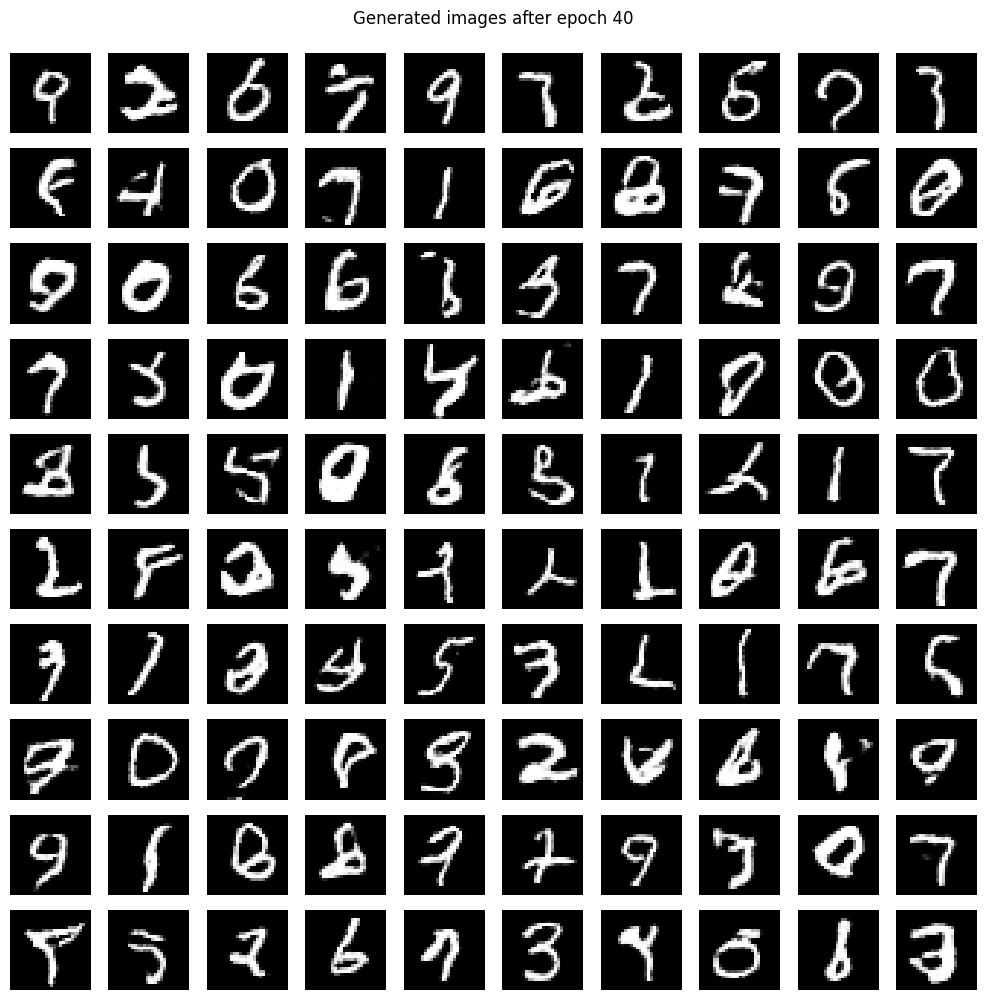


Epoch 41/50
Batch 400, D Loss: 1.3835, G Loss: 0.8905
Epoch 42/50
Batch 400, D Loss: 1.3717, G Loss: 0.8761
Epoch 43/50
Batch 400, D Loss: 1.3652, G Loss: 0.8068
Epoch 44/50
Batch 400, D Loss: 1.3649, G Loss: 0.8201
Epoch 45/50
Batch 400, D Loss: 1.3792, G Loss: 0.8222
Epoch 46/50
Batch 400, D Loss: 1.3902, G Loss: 0.8523
Epoch 47/50
Batch 400, D Loss: 1.3769, G Loss: 0.8120
Epoch 48/50
Batch 400, D Loss: 1.3839, G Loss: 0.7914
Epoch 49/50
Batch 400, D Loss: 1.3728, G Loss: 0.7936
Epoch 50/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


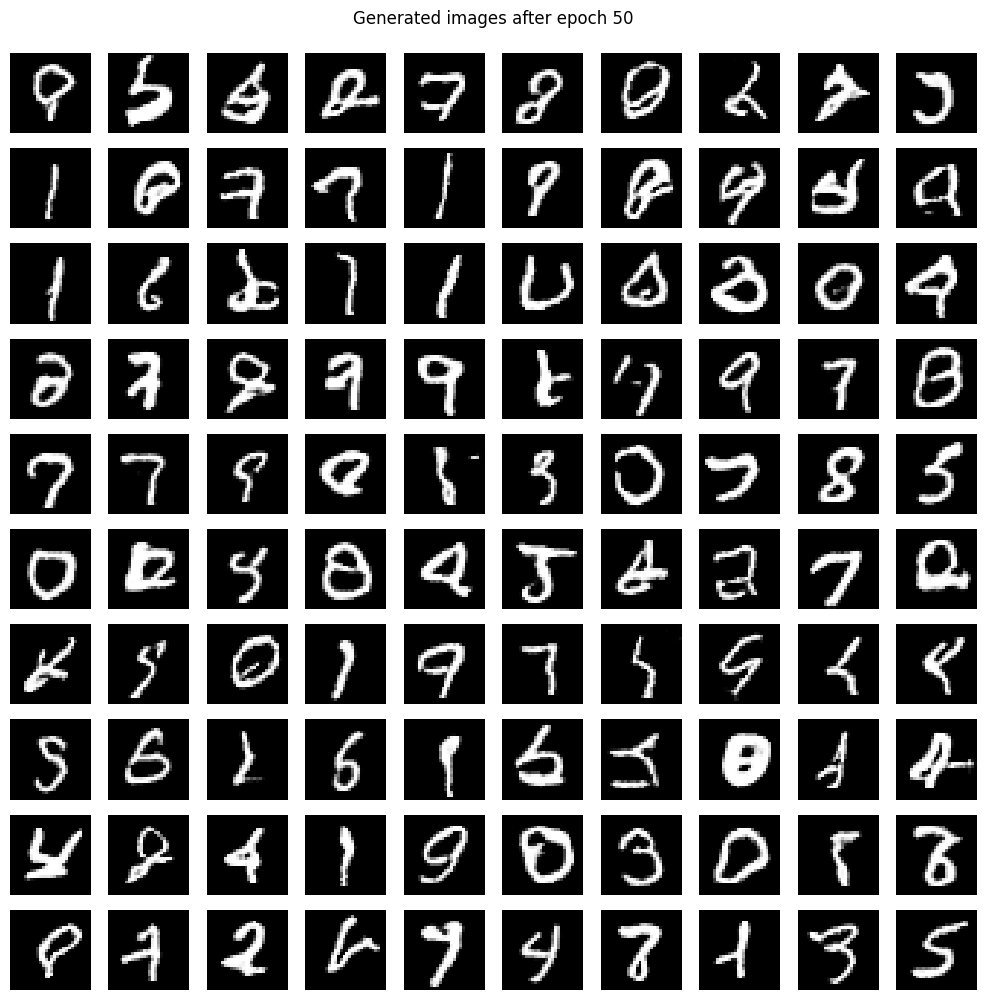

In [152]:
train(epochs=50, batch_size=128)

In [153]:
def adam_optimizer():
    return Adam(learning_rate=0.0004, beta_1=0.5)

In [154]:
class GAN:
    def __init__(self):
        # Initialize models
        self.generator = define_generator()
        #print("Generator weights:", self.generator.get_weights()[:5])
        self.discriminator = define_discriminator()

        learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.0002,
        decay_steps=10000,
        decay_rate=0.9,
        staircase=True)

        # Initialize optimizers with mixed precision
        self.g_optimizer = Adam(learning_rate=learning_rate, beta_1=0.5)
        self.d_optimizer = Adam(learning_rate=learning_rate, beta_1=0.5)

        # Loss function
        self.loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    @tf.function(reduce_retracing=True)
    def train_discriminator(self, real_images, batch_size):
        real_images = tf.cast(real_images, tf.float16)
        noise = tf.random.normal([batch_size, 100], dtype=tf.float16)

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Get predictions
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)
            print(f"Real output range: {tf.reduce_min(real_output)}, {tf.reduce_max(real_output)}")
            print(f"Fake output range: {tf.reduce_min(fake_output)}, {tf.reduce_max(fake_output)}")

            # Create labels
            real_labels = tf.ones_like(real_output) *0.9
            fake_labels = tf.zeros_like(fake_output)

            # Calculate losses
            real_loss = self.loss_fn(real_labels, real_output)
            fake_loss = self.loss_fn(fake_labels, fake_output)
            total_loss = real_loss + fake_loss

        # Calculate gradients
        gradients = tape.gradient(total_loss, self.discriminator.trainable_variables)

        # Apply gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))

        return total_loss

    @tf.function(reduce_retracing=True)
    def train_generator(self, batch_size):
        noise = tf.random.normal([batch_size, 100], dtype=tf.float16)

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)
            print(f"Generated images shape: {generated_images.shape}")
            print(f"Generated images min value: {tf.reduce_min(generated_images)}")
            print(f"Generated images max value: {tf.reduce_max(generated_images)}")

            # Get predictions
            fake_output = self.discriminator(generated_images, training=False)

            # Calculate loss
            labels = tf.ones_like(fake_output)
            loss = self.loss_fn(labels, fake_output)

        # Calculate gradients
        gradients = tape.gradient(loss, self.generator.trainable_variables)

        # Apply gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        return loss



def train(epochs=50, batch_size=128):
    # Load and prepare data
    x_train, _, _, _ = load_data()
    dataset_size = x_train.shape[0]

    # Create dataset with fixed shapes and types
    dataset = tf.data.Dataset.from_tensor_slices(x_train) \
        .shuffle(dataset_size) \
        .batch(batch_size, drop_remainder=True) \
        .prefetch(tf.data.AUTOTUNE)

    # Initialize GAN
    gan = GAN()

    # Training loop
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        for batch_idx, real_images in enumerate(dataset):
            d_loss = gan.train_discriminator(real_images, batch_size)
            g_loss = gan.train_generator(batch_size)

            if batch_idx % 100 == 0:
                print(f"\rBatch {batch_idx}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}", end="")

        # Generate and save images every 10 epochs
        if (epoch + 1) % 10 == 0:
            plot_generated_images(epoch + 1, gan.generator)


Epoch 1/50
Real output range: Tensor("Min:0", shape=(), dtype=float16), Tensor("Max:0", shape=(), dtype=float16)
Fake output range: Tensor("Min_1:0", shape=(), dtype=float16), Tensor("Max_1:0", shape=(), dtype=float16)
Real output range: Tensor("Min:0", shape=(), dtype=float16), Tensor("Max:0", shape=(), dtype=float16)
Fake output range: Tensor("Min_1:0", shape=(), dtype=float16), Tensor("Max_1:0", shape=(), dtype=float16)
Generated images shape: (128, 28, 28, 1)
Generated images min value: Tensor("Min:0", shape=(), dtype=float16)
Generated images max value: Tensor("Max:0", shape=(), dtype=float16)
Generated images shape: (128, 28, 28, 1)
Generated images min value: Tensor("Min:0", shape=(), dtype=float16)
Generated images max value: Tensor("Max:0", shape=(), dtype=float16)
Batch 400, D Loss: 1.3429, G Loss: 0.8273
Epoch 2/50
Batch 400, D Loss: 1.4213, G Loss: 0.7631
Epoch 3/50
Batch 400, D Loss: 1.3817, G Loss: 0.7926
Epoch 4/50
Batch 400, D Loss: 1.3971, G Loss: 0.8860
Epoch 5/50
Ba

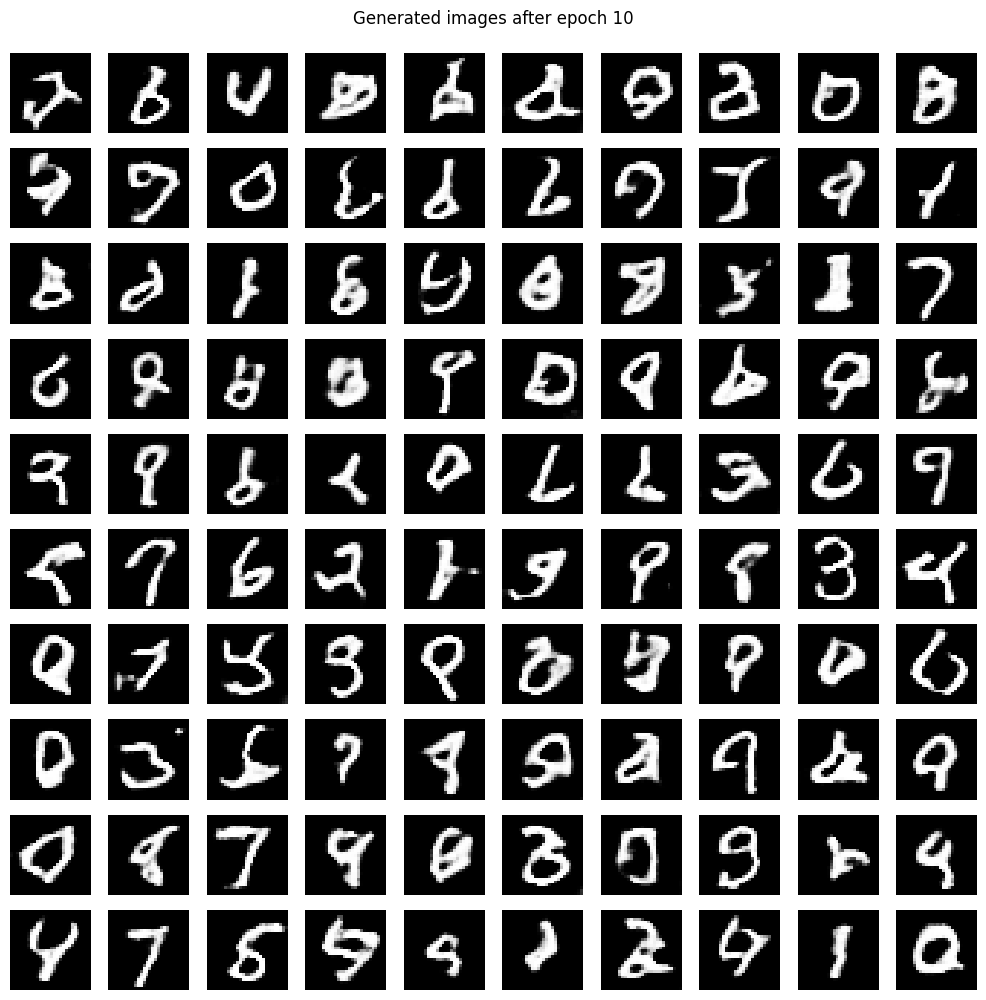


Epoch 11/50
Batch 400, D Loss: 1.3522, G Loss: 0.8818
Epoch 12/50
Batch 400, D Loss: 1.3488, G Loss: 0.8671
Epoch 13/50
Batch 400, D Loss: 1.3572, G Loss: 0.8970
Epoch 14/50
Batch 400, D Loss: 1.3458, G Loss: 0.8672
Epoch 15/50
Batch 400, D Loss: 1.3545, G Loss: 0.7356
Epoch 16/50
Batch 400, D Loss: 1.3554, G Loss: 0.7953
Epoch 17/50
Batch 400, D Loss: 1.3734, G Loss: 0.8183
Epoch 18/50
Batch 400, D Loss: 1.3524, G Loss: 0.8066
Epoch 19/50
Batch 400, D Loss: 1.3576, G Loss: 0.8325
Epoch 20/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


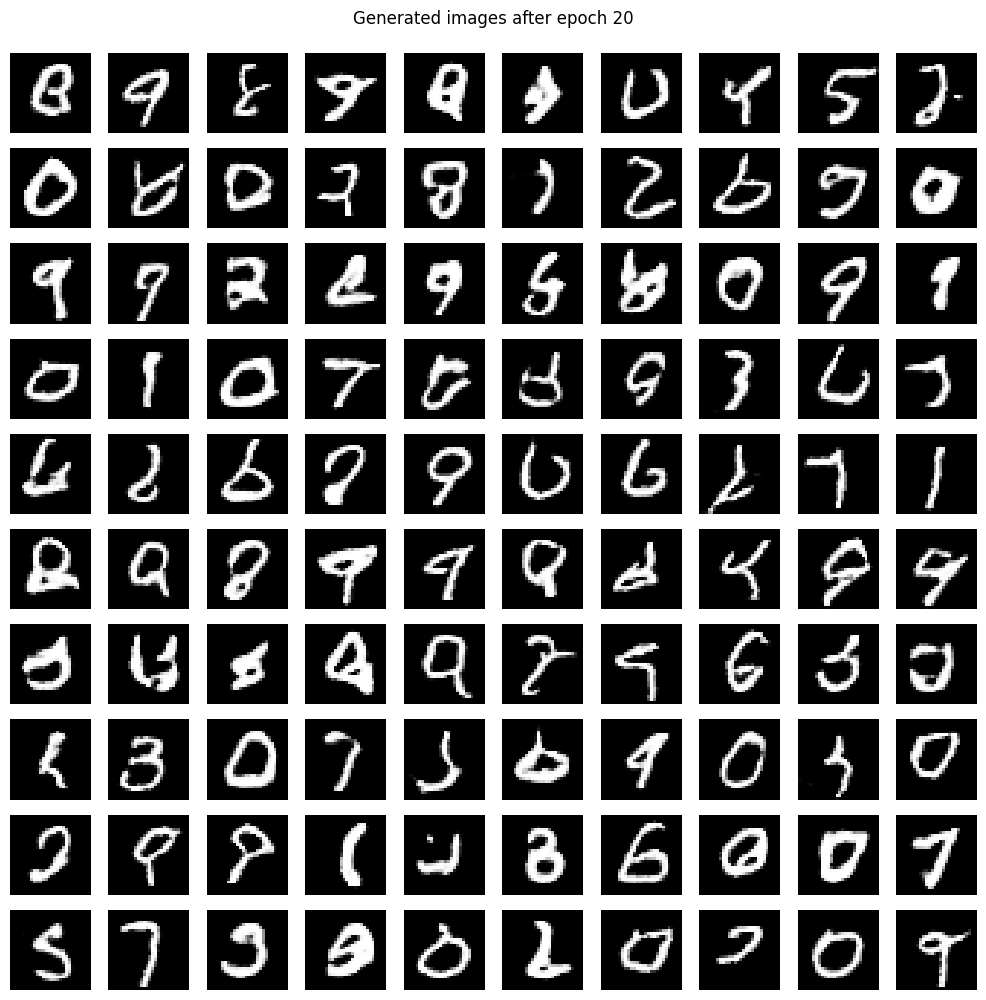


Epoch 21/50
Batch 400, D Loss: 1.3881, G Loss: 0.7604
Epoch 22/50
Batch 400, D Loss: 1.3812, G Loss: 0.8256
Epoch 23/50
Batch 400, D Loss: 1.3741, G Loss: 0.7737
Epoch 24/50
Batch 400, D Loss: 1.3650, G Loss: 0.8539
Epoch 25/50
Batch 400, D Loss: 1.3710, G Loss: 0.8672
Epoch 26/50
Batch 400, D Loss: 1.3654, G Loss: 0.8106
Epoch 27/50
Batch 400, D Loss: 1.3852, G Loss: 0.7994
Epoch 28/50
Batch 400, D Loss: 1.3625, G Loss: 0.8417
Epoch 29/50
Batch 400, D Loss: 1.3614, G Loss: 0.8171
Epoch 30/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


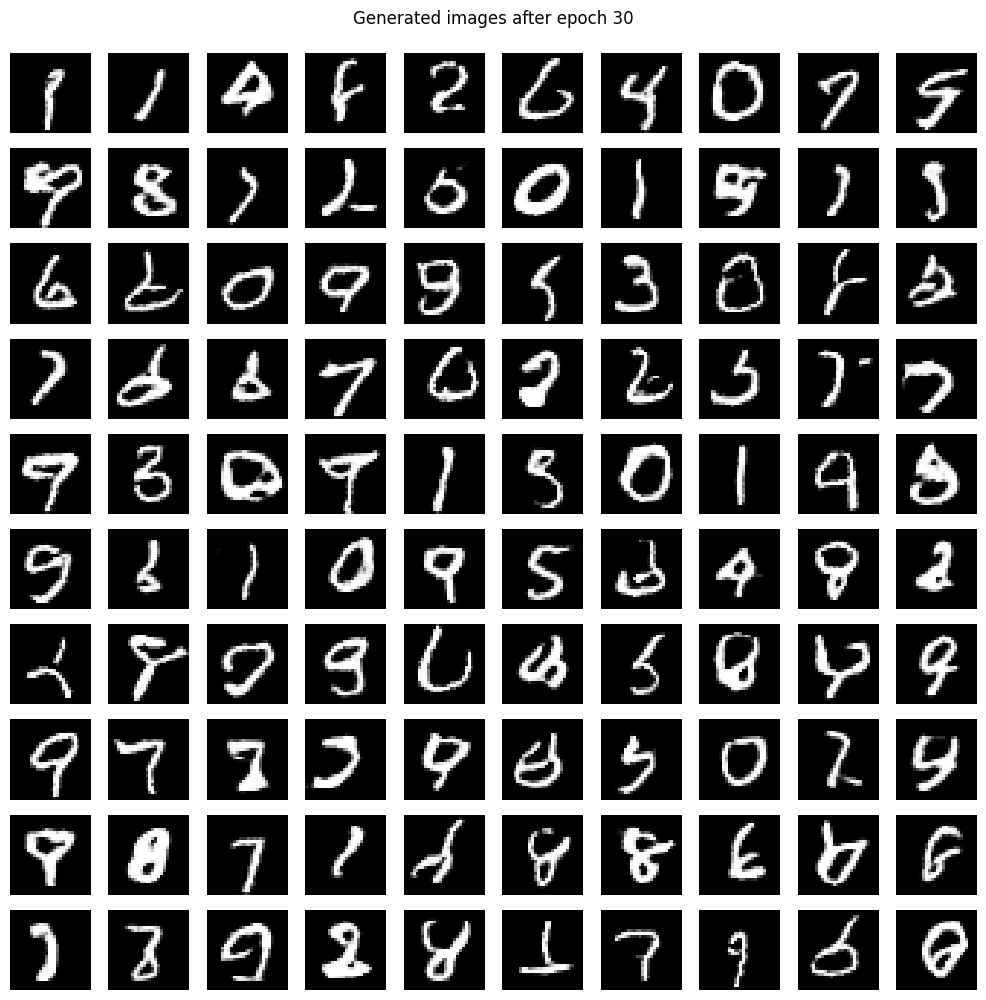


Epoch 31/50
Batch 400, D Loss: 1.3729, G Loss: 0.8239
Epoch 32/50
Batch 400, D Loss: 1.3677, G Loss: 0.8335
Epoch 33/50
Batch 400, D Loss: 1.3751, G Loss: 0.7387
Epoch 34/50
Batch 400, D Loss: 1.3710, G Loss: 0.7993
Epoch 35/50
Batch 400, D Loss: 1.3660, G Loss: 0.8003
Epoch 36/50
Batch 400, D Loss: 1.3713, G Loss: 0.8953
Epoch 37/50
Batch 400, D Loss: 1.3648, G Loss: 0.8234
Epoch 38/50
Batch 400, D Loss: 1.3589, G Loss: 0.8278
Epoch 39/50
Batch 400, D Loss: 1.3613, G Loss: 0.8603
Epoch 40/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


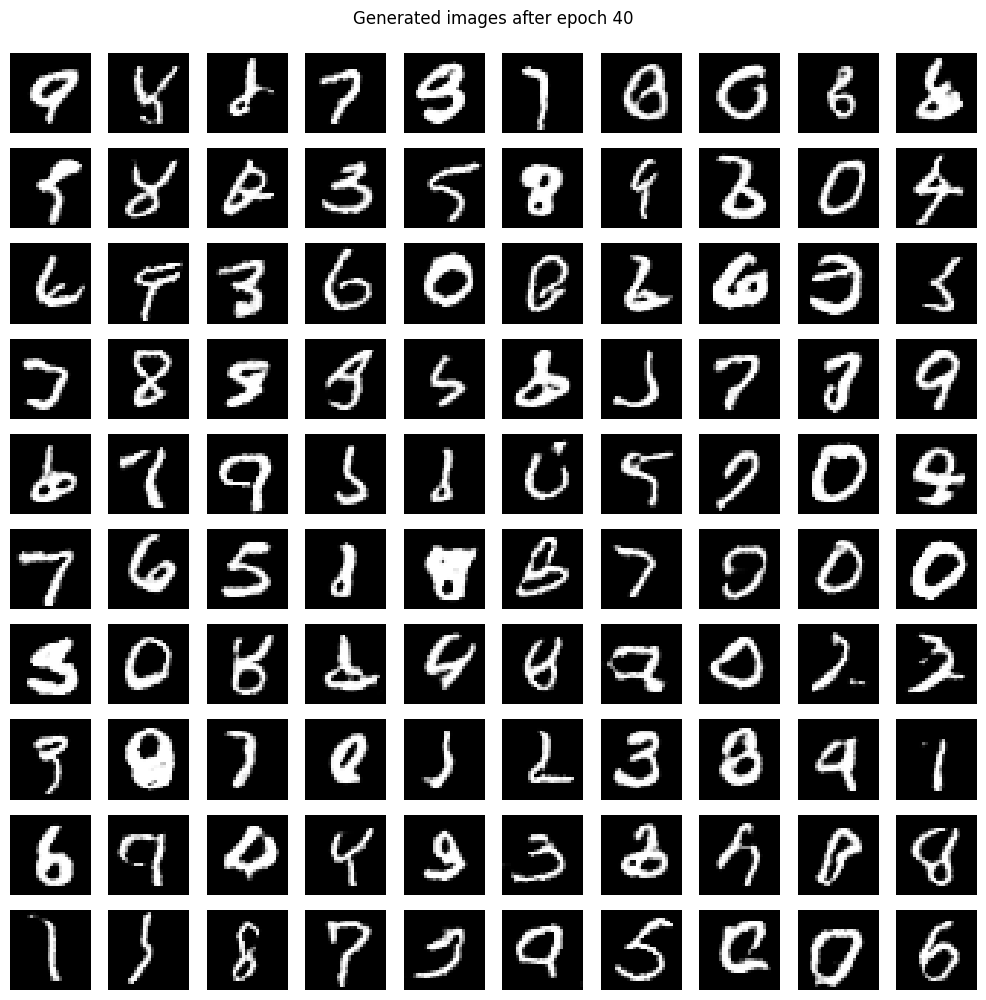


Epoch 41/50
Batch 400, D Loss: 1.3830, G Loss: 0.8631
Epoch 42/50
Batch 400, D Loss: 1.3809, G Loss: 0.8523
Epoch 43/50
Batch 400, D Loss: 1.3686, G Loss: 0.8218
Epoch 44/50
Batch 400, D Loss: 1.3745, G Loss: 0.7893
Epoch 45/50
Batch 400, D Loss: 1.3739, G Loss: 0.8285
Epoch 46/50
Batch 400, D Loss: 1.3795, G Loss: 0.8090
Epoch 47/50
Batch 400, D Loss: 1.3749, G Loss: 0.8200
Epoch 48/50
Batch 400, D Loss: 1.3774, G Loss: 0.8442
Epoch 49/50
Batch 400, D Loss: 1.3782, G Loss: 0.8070
Epoch 50/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


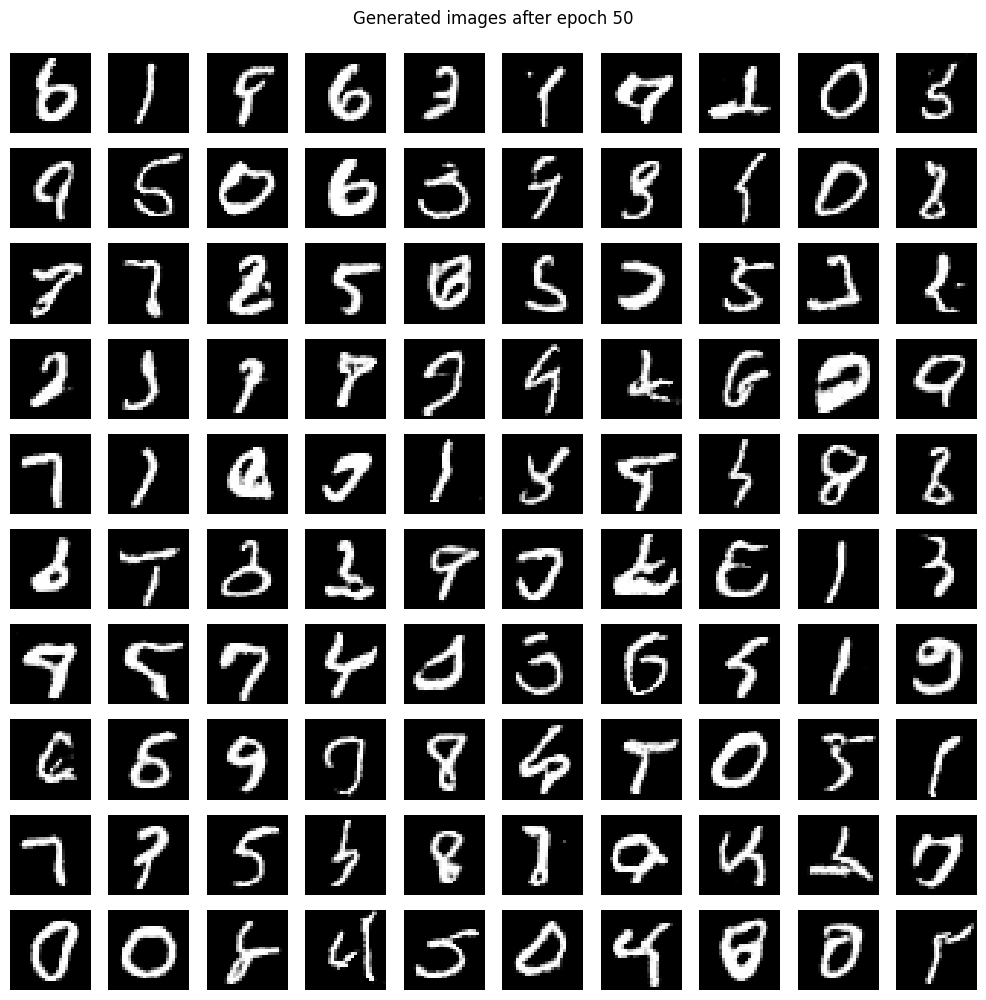

In [155]:
train(epochs=50, batch_size=128)

In [156]:
def adam_optimizer():
    return Adam(learning_rate=0.0006, beta_1=0.5)

In [157]:
class GAN:
    def __init__(self):
        # Initialize models
        self.generator = define_generator()
        #print("Generator weights:", self.generator.get_weights()[:5])
        self.discriminator = define_discriminator()

        learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.0002,
        decay_steps=10000,
        decay_rate=0.9,
        staircase=True)

        # Initialize optimizers with mixed precision
        self.g_optimizer = Adam(learning_rate=learning_rate, beta_1=0.5)
        self.d_optimizer = Adam(learning_rate=learning_rate, beta_1=0.5)

        # Loss function
        self.loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    @tf.function(reduce_retracing=True)
    def train_discriminator(self, real_images, batch_size):
        real_images = tf.cast(real_images, tf.float16)
        noise = tf.random.normal([batch_size, 100], dtype=tf.float16)

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Get predictions
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)
            print(f"Real output range: {tf.reduce_min(real_output)}, {tf.reduce_max(real_output)}")
            print(f"Fake output range: {tf.reduce_min(fake_output)}, {tf.reduce_max(fake_output)}")

            # Create labels
            real_labels = tf.ones_like(real_output) *0.9
            fake_labels = tf.zeros_like(fake_output)

            # Calculate losses
            real_loss = self.loss_fn(real_labels, real_output)
            fake_loss = self.loss_fn(fake_labels, fake_output)
            total_loss = real_loss + fake_loss

        # Calculate gradients
        gradients = tape.gradient(total_loss, self.discriminator.trainable_variables)

        # Apply gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))

        return total_loss

    @tf.function(reduce_retracing=True)
    def train_generator(self, batch_size):
        noise = tf.random.normal([batch_size, 100], dtype=tf.float16)

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)
            print(f"Generated images shape: {generated_images.shape}")
            print(f"Generated images min value: {tf.reduce_min(generated_images)}")
            print(f"Generated images max value: {tf.reduce_max(generated_images)}")

            # Get predictions
            fake_output = self.discriminator(generated_images, training=False)

            # Calculate loss
            labels = tf.ones_like(fake_output)
            loss = self.loss_fn(labels, fake_output)

        # Calculate gradients
        gradients = tape.gradient(loss, self.generator.trainable_variables)

        # Apply gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        return loss



def train(epochs=50, batch_size=128):
    # Load and prepare data
    x_train, _, _, _ = load_data()
    dataset_size = x_train.shape[0]

    # Create dataset with fixed shapes and types
    dataset = tf.data.Dataset.from_tensor_slices(x_train) \
        .shuffle(dataset_size) \
        .batch(batch_size, drop_remainder=True) \
        .prefetch(tf.data.AUTOTUNE)

    # Initialize GAN
    gan = GAN()

    # Training loop
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        for batch_idx, real_images in enumerate(dataset):
            d_loss = gan.train_discriminator(real_images, batch_size)
            g_loss = gan.train_generator(batch_size)

            if batch_idx % 100 == 0:
                print(f"\rBatch {batch_idx}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}", end="")

        # Generate and save images every 10 epochs
        if (epoch + 1) % 10 == 0:
            plot_generated_images(epoch + 1, gan.generator)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(



Epoch 1/50
Real output range: Tensor("Min:0", shape=(), dtype=float16), Tensor("Max:0", shape=(), dtype=float16)
Fake output range: Tensor("Min_1:0", shape=(), dtype=float16), Tensor("Max_1:0", shape=(), dtype=float16)
Real output range: Tensor("Min:0", shape=(), dtype=float16), Tensor("Max:0", shape=(), dtype=float16)
Fake output range: Tensor("Min_1:0", shape=(), dtype=float16), Tensor("Max_1:0", shape=(), dtype=float16)
Generated images shape: (128, 28, 28, 1)
Generated images min value: Tensor("Min:0", shape=(), dtype=float16)
Generated images max value: Tensor("Max:0", shape=(), dtype=float16)
Generated images shape: (128, 28, 28, 1)
Generated images min value: Tensor("Min:0", shape=(), dtype=float16)
Generated images max value: Tensor("Max:0", shape=(), dtype=float16)
Batch 400, D Loss: 1.3659, G Loss: 0.8629
Epoch 2/50
Batch 400, D Loss: 1.3008, G Loss: 0.8667
Epoch 3/50
Batch 400, D Loss: 1.3374, G Loss: 0.8189
Epoch 4/50
Batch 400, D Loss: 1.3434, G Loss: 0.8327
Epoch 5/50
Ba

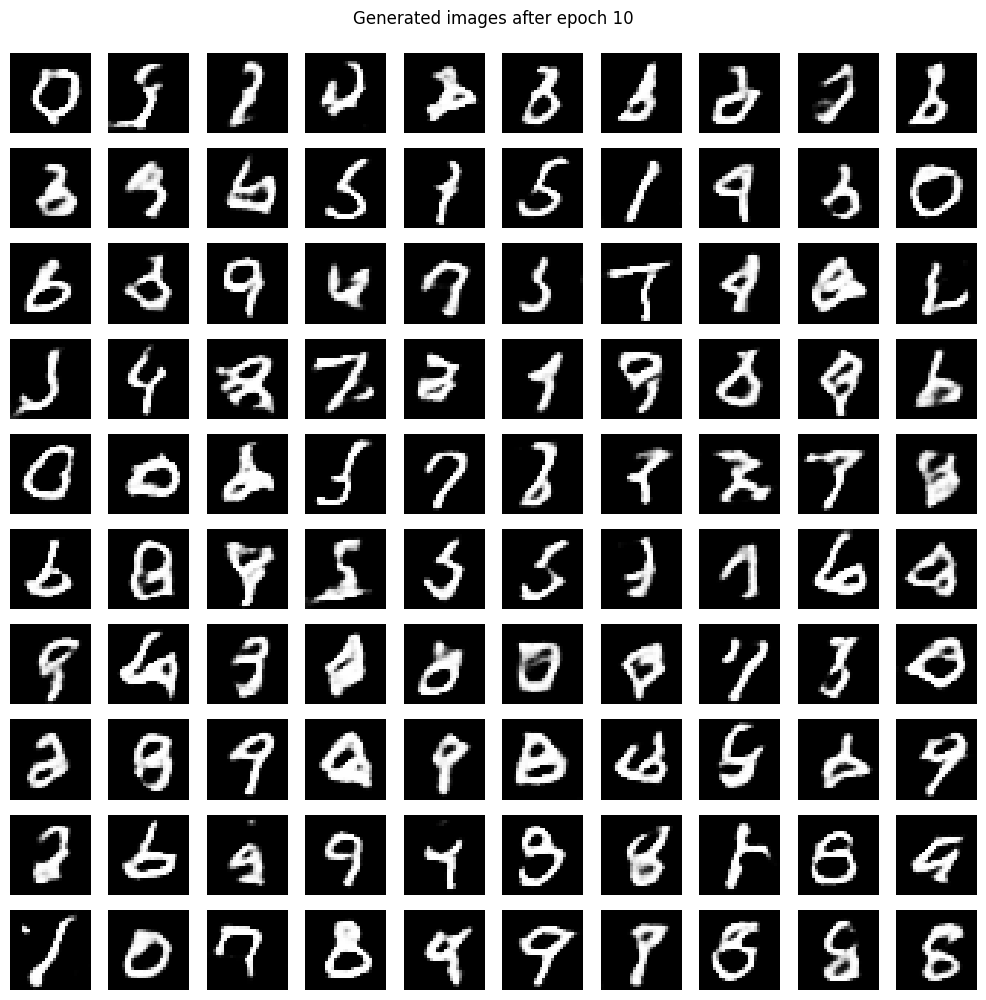


Epoch 11/50
Batch 400, D Loss: 1.3311, G Loss: 0.8881
Epoch 12/50
Batch 400, D Loss: 1.3278, G Loss: 0.8438
Epoch 13/50
Batch 400, D Loss: 1.3446, G Loss: 0.9022
Epoch 14/50
Batch 400, D Loss: 1.3012, G Loss: 0.9821
Epoch 15/50
Batch 400, D Loss: 1.3368, G Loss: 0.7752
Epoch 16/50
Batch 400, D Loss: 1.3483, G Loss: 0.7955
Epoch 17/50
Batch 400, D Loss: 1.3508, G Loss: 0.8844
Epoch 18/50
Batch 400, D Loss: 1.3819, G Loss: 1.0030
Epoch 19/50
Batch 400, D Loss: 1.3566, G Loss: 0.9664
Epoch 20/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


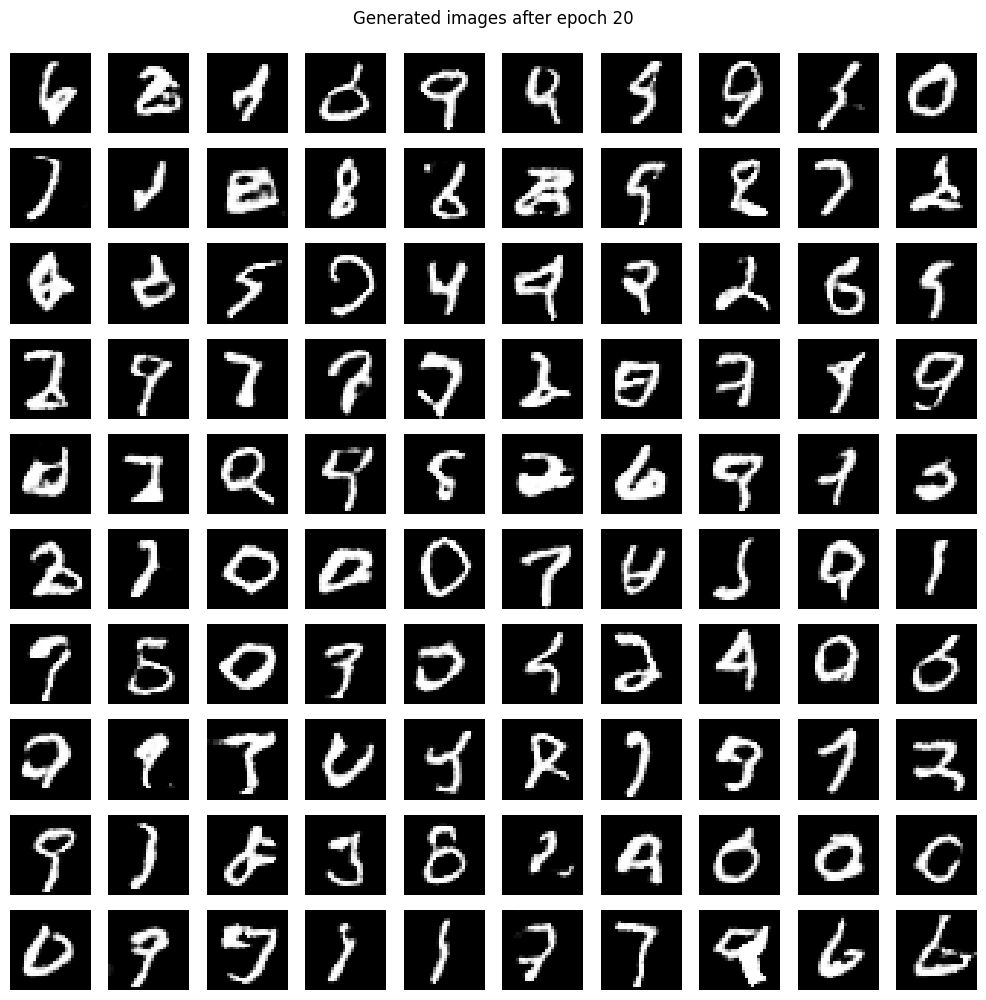


Epoch 21/50
Batch 400, D Loss: 1.3705, G Loss: 0.9303
Epoch 22/50
Batch 400, D Loss: 1.3679, G Loss: 0.7550
Epoch 23/50
Batch 400, D Loss: 1.3564, G Loss: 0.8219
Epoch 24/50
Batch 400, D Loss: 1.3804, G Loss: 0.7776
Epoch 25/50
Batch 400, D Loss: 1.3735, G Loss: 0.7929
Epoch 26/50
Batch 400, D Loss: 1.3730, G Loss: 0.8931
Epoch 27/50
Batch 400, D Loss: 1.3642, G Loss: 0.8079
Epoch 28/50
Batch 400, D Loss: 1.3652, G Loss: 0.8261
Epoch 29/50
Batch 400, D Loss: 1.3576, G Loss: 0.9100
Epoch 30/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


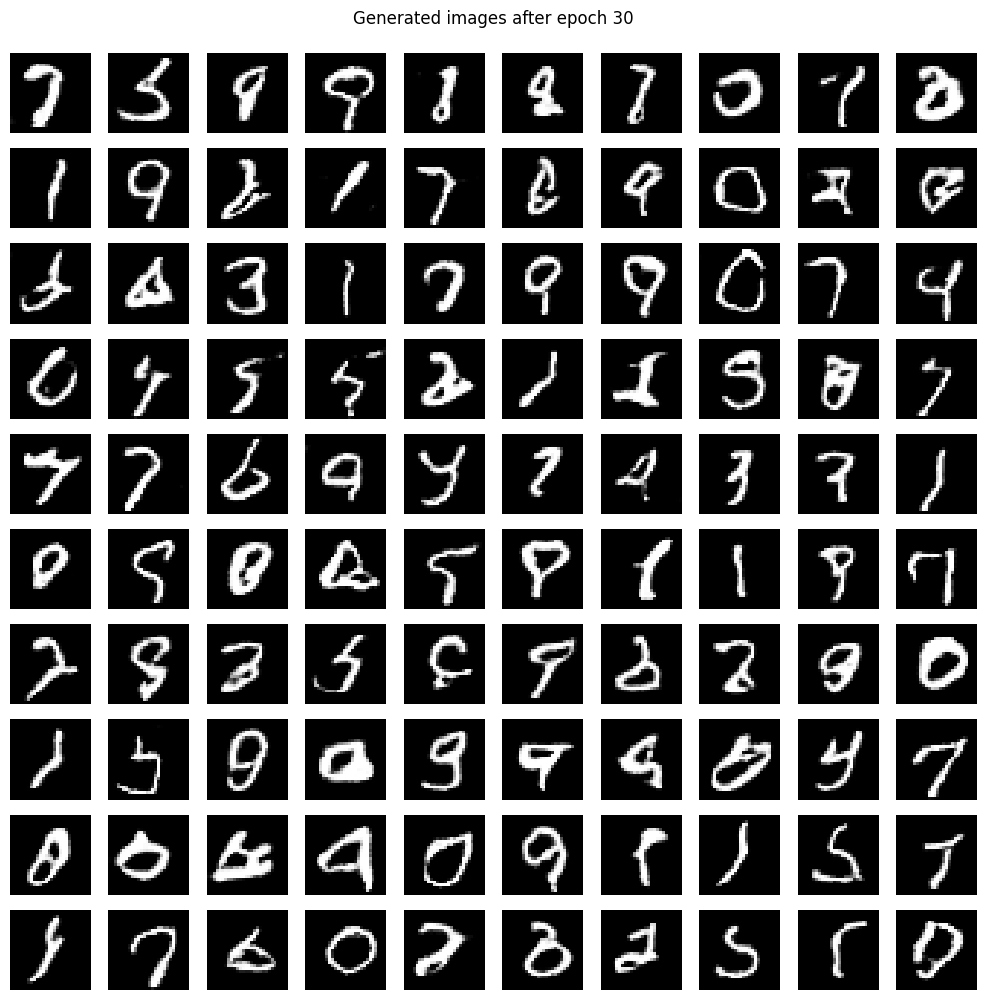


Epoch 31/50
Batch 400, D Loss: 1.4836, G Loss: 0.8900
Epoch 32/50
Batch 400, D Loss: 1.3679, G Loss: 0.7742
Epoch 33/50
Batch 400, D Loss: 1.3701, G Loss: 0.7790
Epoch 34/50
Batch 400, D Loss: 1.3619, G Loss: 0.8738
Epoch 35/50
Batch 400, D Loss: 1.3464, G Loss: 0.8404
Epoch 36/50
Batch 400, D Loss: 1.3706, G Loss: 0.7969
Epoch 37/50
Batch 400, D Loss: 1.3674, G Loss: 0.8415
Epoch 38/50
Batch 400, D Loss: 1.3734, G Loss: 0.8970
Epoch 39/50
Batch 400, D Loss: 1.3751, G Loss: 0.8005
Epoch 40/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


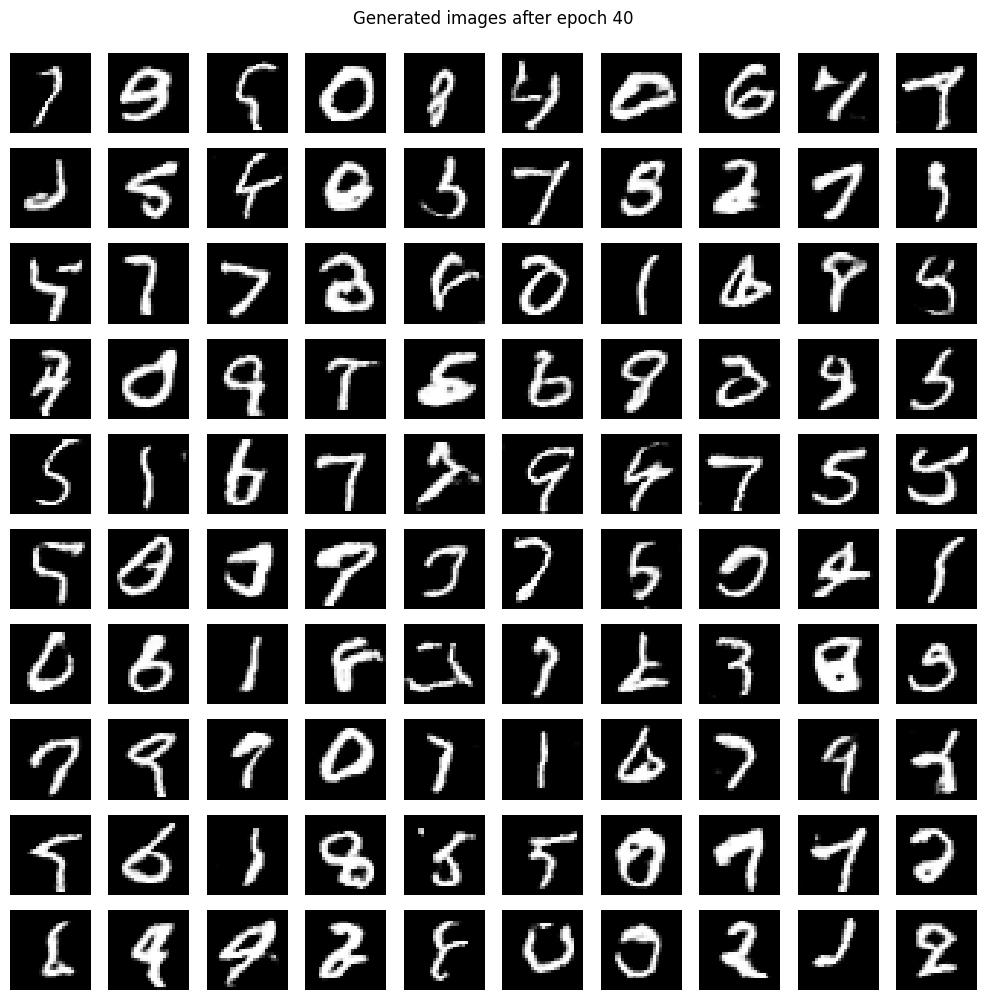


Epoch 41/50
Batch 400, D Loss: 1.3731, G Loss: 0.8308
Epoch 42/50
Batch 400, D Loss: 1.3772, G Loss: 0.7503
Epoch 43/50
Batch 400, D Loss: 1.3778, G Loss: 0.8274
Epoch 44/50
Batch 400, D Loss: 1.3769, G Loss: 0.8343
Epoch 45/50
Batch 400, D Loss: 1.3894, G Loss: 0.8267
Epoch 46/50
Batch 400, D Loss: 1.3670, G Loss: 0.7890
Epoch 47/50
Batch 400, D Loss: 1.3801, G Loss: 0.7673
Epoch 48/50
Batch 400, D Loss: 1.3793, G Loss: 0.8138
Epoch 49/50
Batch 400, D Loss: 1.3579, G Loss: 0.8213
Epoch 50/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


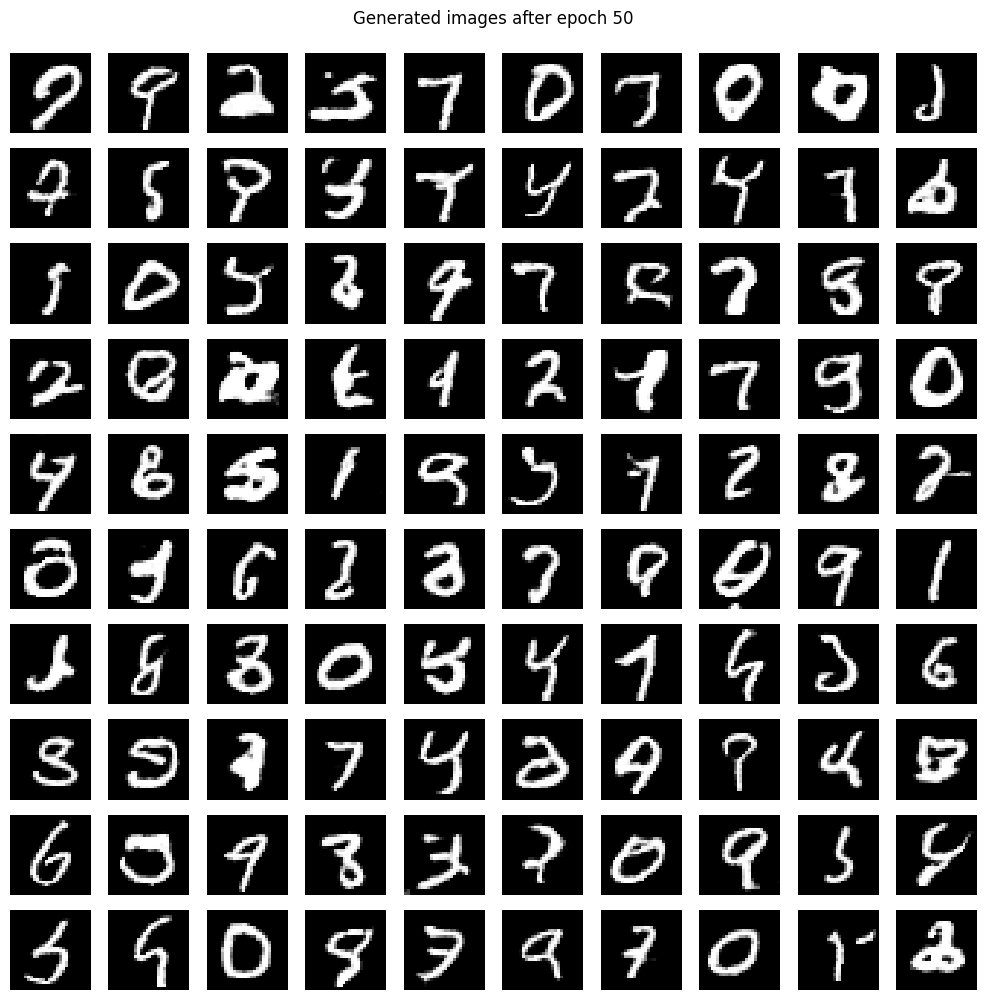

In [158]:
train(epochs=50, batch_size=128)

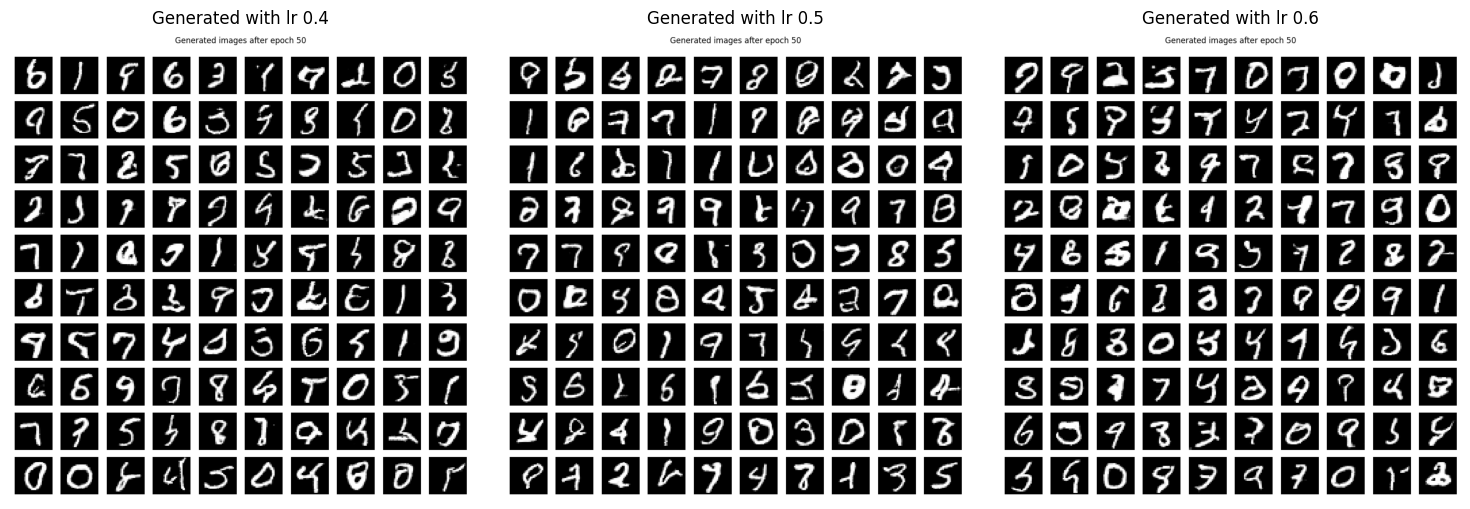

In [160]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

img1 = Image.open('/content/output_lr_0.4.png')
img2 = Image.open('/content/output_lr_0.5.png')
img3 = Image.open('/content/output_lr_0.6.png')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img1)
axes[0].axis('off')
axes[0].set_title('Generated with lr 0.4')

axes[1].imshow(img2)
axes[1].axis('off')
axes[1].set_title('Generated with lr 0.5')

axes[2].imshow(img3)
axes[2].axis('off')
axes[2].set_title('Generated with lr 0.6')

plt.tight_layout()
plt.show()
